In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm
#import pytorch3d

/home/xingchenliu/anaconda3/envs/vae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset:

In [2]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [3]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [4]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

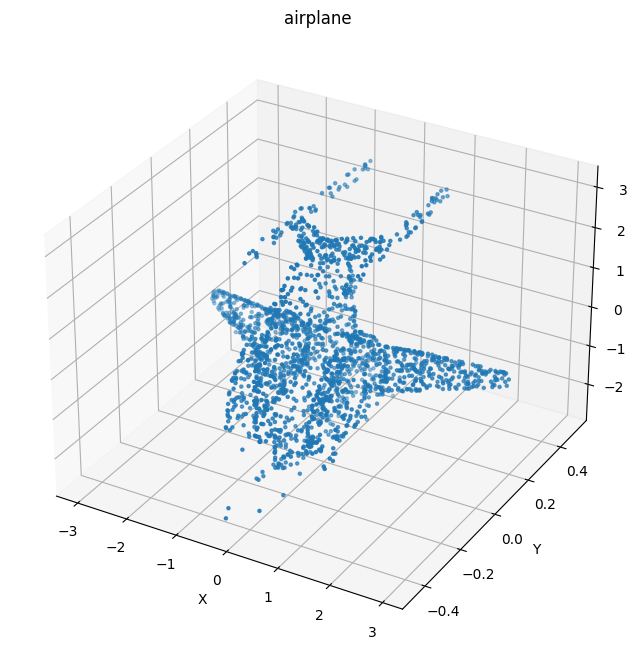

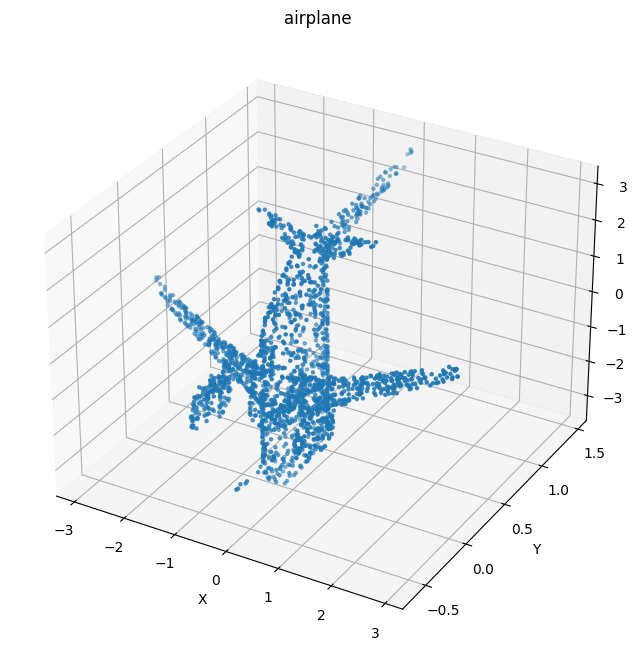

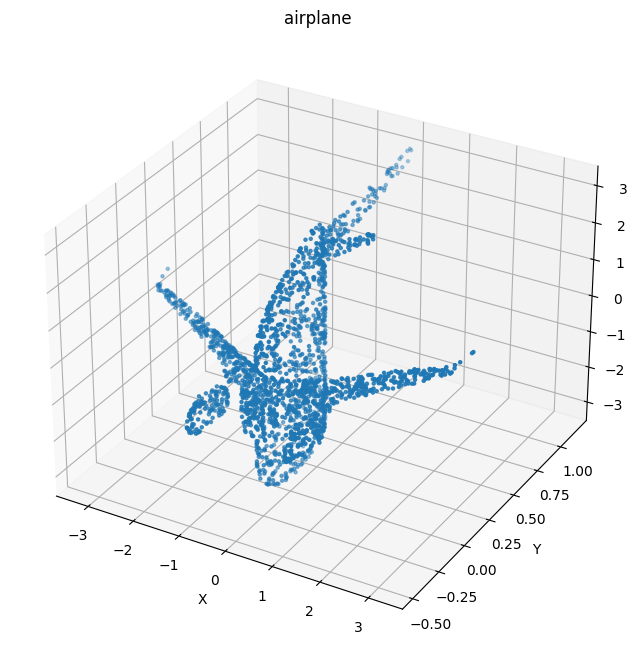

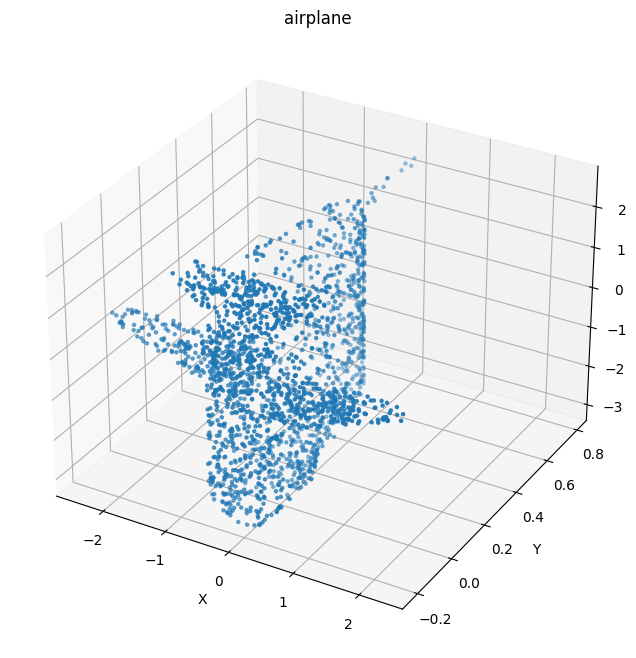

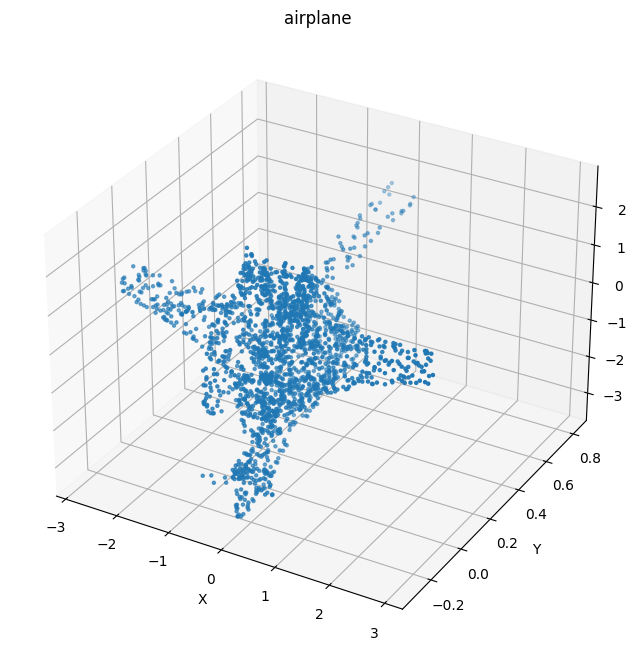

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [6]:
class TransformNet(nn.Module):
    def __init__(self, k=3):
        super(TransformNet, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)  # k*k for transformation matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Initialize the weights/bias with Identity transformation
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.copy_(torch.eye(k).view(-1))

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.gelu(self.bn4(self.fc1(x)))
        x = F.gelu(self.bn5(self.fc2(x)))
        
        x = self.fc3(x)
        
        # Reshape to the transformation matrix
        x = x.view(batch_size, -1)
        iden = torch.eye(self.fc3.out_features // x.size(-1)).view(-1).to(x.device)
        x = x + iden
        x = x.view(batch_size, x.size(1) // int(x.size(1)**0.5), int(x.size(1)**0.5))
        
        return x

In [7]:
class VariationalPointNetEncoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(VariationalPointNetEncoder, self).__init__()
        
        # Input transform
        self.input_transform = TransformNet(k=3)
        
        # Shared MLP
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # Feature transform
        self.feature_transform = TransformNet(k=64)
        
        # Batch Norm layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.transpose(2, 1)
        
        # Apply input transform
        input_transform = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), input_transform).transpose(1, 2)

        
        # Shared MLP layers
        x = F.gelu(self.bn1(self.conv1(x)))
        
        # Apply feature transform
        feature_transform = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), feature_transform).transpose(1, 2)

        
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        # Transition layers
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        
        # Get mu and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        # Reparametrization trick
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        # KL divergence
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z


Decoder:

In [8]:
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointNetDecoder, self).__init__()
        
        self.num_points = num_points
        
        # More expressive layers
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, num_points * 3)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x.view(-1, self.num_points, 3)


In [9]:
def chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two point clouds.
    
    Args:
    - p1 (torch.Tensor): A tensor of shape (B, N, D) representing a batch of point clouds, each of which has N points of dimension D.
    - p2 (torch.Tensor): A tensor of the same shape as p1.
    
    Returns:
    - distance (torch.Tensor): A tensor of shape (B,) representing the Chamfer Distance for each pair of point clouds in the batch.
    """
    
    # Compute the pairwise squared distances between points
    # p1 has shape (B, N, D) and p2 has shape (B, M, D)
    # The resulting dists will have shape (B, N, M)
    dists = torch.sum(p1**2, dim=2).unsqueeze(2) + torch.sum(p2**2, dim=2).unsqueeze(1) - 2 * torch.matmul(p1, p2.permute(0, 2, 1))
    
    # For each point in p1, find the closest distance in p2
    min_dists_p1 = torch.min(dists, dim=2)[0]  # Shape (B, N)
    
    # For each point in p2, find the closest distance in p1
    min_dists_p2 = torch.min(dists, dim=1)[0]  # Shape (B, M)
    
    # Combine the two distances by taking the average
    distance = (torch.sum(min_dists_p1, dim=1) + torch.sum(min_dists_p2, dim=1)) / 2
    
    return distance

# Test with the given point clouds
p1 = torch.tensor([[[8.8977, 4.1709, 1.2839],
                    [8.5640, 7.7767, 9.4214]],
                   [[0.5431, 6.4495, 11.4914],
                    [3.2126, 8.0865, 3.1018]]], dtype=torch.float)
p2 = torch.tensor([[[6.9340, 6.1152, 3.4435],
                    [0.1032, 9.8181, 11.3350]],
                   [[11.4006, 2.2154, 7.9589],
                    [4.2586, 1.4133, 7.2606]]], dtype=torch.float)

print(chamfer_distance(p1, p2))  # Expected output: tensor([ 72.5838, 151.0809])


tensor([ 72.5838, 151.0809])


VAE

In [10]:
class PointCloudVAE(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointCloudVAE, self).__init__()
        
        # Using the VariationalPointNetEncoder
        self.encoder = VariationalPointNetEncoder(num_points=num_points, latent_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        # Encode input point cloud and get latent variable z
        z = self.encoder(x)
        
        # Decode z to get the reconstructed point cloud
        reconstructed = self.decoder(z)
        
        return reconstructed, self.encoder.kl

# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=0.0):
    # Reconstruction loss
    recon_loss = chamfer_distance(reconstructed, original).mean()
    
    # Return combined loss
    return recon_loss + beta * kl_div

# Usage remains largely the same:

# Create a VAE
vae = PointCloudVAE(num_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)


Train

In [11]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_kl_div, total_recon_loss = 0, 0, 0
        
        # Training
        for i, batch in enumerate(tqdm(train_loader)):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
            combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
            
            combined_loss.backward()
            optimizer.step()
            
            total_train_loss += combined_loss.item()
            total_kl_div += kl_div.item()
            total_recon_loss += recon_loss.item()
            
            # Print batch-level losses
            print(f"Epoch {epoch+1}, Batch {i+1} - Combined Loss: {combined_loss.item():.4f}, KL Div: {kl_div.item():.4f}, Recon Loss: {recon_loss.item():.4f}")
            
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_kl_div = total_kl_div / len(train_loader)
        avg_train_recon_loss = total_recon_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss, total_val_kl_div, total_val_recon_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                
                recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
                combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
                
                total_val_loss += combined_loss.item()
                total_val_kl_div += kl_div.item()
                total_val_recon_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_kl_div = total_val_kl_div / len(val_loader)
        avg_val_recon_loss = total_val_recon_loss / len(val_loader)
        
        # Print epoch-level average losses
        print(f"\nEpoch: {epoch+1} Summary:")
        print(f"Train Avg Combined Loss: {avg_train_loss:.4f}, Train Avg KL Div: {avg_train_kl_div:.4f}, Train Avg Recon Loss: {avg_train_recon_loss:.4f}")
        print(f"Val Avg Combined Loss: {avg_val_loss:.4f}, Val Avg KL Div: {avg_val_kl_div:.4f}, Val Avg Recon Loss: {avg_val_recon_loss:.4f}\n")



In [12]:
vae = PointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [13]:
train_vae(vae, train_loader, val_loader, optimizer)

  7%|▋         | 2/27 [00:00<00:05,  4.59it/s]

Epoch 1, Batch 1 - Combined Loss: 2426.4175, KL Div: 1020.3837, Recon Loss: 2426.4175
Epoch 1, Batch 2 - Combined Loss: 1603.6233, KL Div: 28285.4980, Recon Loss: 1603.6233


 15%|█▍        | 4/27 [00:00<00:04,  5.53it/s]

Epoch 1, Batch 3 - Combined Loss: 6448.3525, KL Div: 1432566.2500, Recon Loss: 6448.3525
Epoch 1, Batch 4 - Combined Loss: 731.7040, KL Div: 83432.4844, Recon Loss: 731.7040


 22%|██▏       | 6/27 [00:01<00:03,  5.88it/s]

Epoch 1, Batch 5 - Combined Loss: 1422.4976, KL Div: 41882.4883, Recon Loss: 1422.4976
Epoch 1, Batch 6 - Combined Loss: 1502.6078, KL Div: 37104.3203, Recon Loss: 1502.6078


 30%|██▉       | 8/27 [00:01<00:03,  6.04it/s]

Epoch 1, Batch 7 - Combined Loss: 1260.5377, KL Div: 42448.4453, Recon Loss: 1260.5377
Epoch 1, Batch 8 - Combined Loss: 824.9955, KL Div: 62934.6133, Recon Loss: 824.9955


 37%|███▋      | 10/27 [00:01<00:02,  6.10it/s]

Epoch 1, Batch 9 - Combined Loss: 499.0942, KL Div: 103593.7500, Recon Loss: 499.0942
Epoch 1, Batch 10 - Combined Loss: 357.4895, KL Div: 195462.1875, Recon Loss: 357.4895


 44%|████▍     | 12/27 [00:02<00:02,  6.13it/s]

Epoch 1, Batch 11 - Combined Loss: 478.3171, KL Div: 264066.6250, Recon Loss: 478.3171
Epoch 1, Batch 12 - Combined Loss: 472.7609, KL Div: 278801.3125, Recon Loss: 472.7609


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 1, Batch 13 - Combined Loss: 272.1078, KL Div: 229686.5625, Recon Loss: 272.1078
Epoch 1, Batch 14 - Combined Loss: 196.7135, KL Div: 174527.9062, Recon Loss: 196.7135


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 1, Batch 15 - Combined Loss: 179.9964, KL Div: 136166.7812, Recon Loss: 179.9964
Epoch 1, Batch 16 - Combined Loss: 169.1766, KL Div: 118764.6562, Recon Loss: 169.1766


 67%|██████▋   | 18/27 [00:03<00:01,  6.16it/s]

Epoch 1, Batch 17 - Combined Loss: 159.0495, KL Div: 104416.8906, Recon Loss: 159.0495
Epoch 1, Batch 18 - Combined Loss: 137.8944, KL Div: 94785.4688, Recon Loss: 137.8944


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 1, Batch 19 - Combined Loss: 134.8025, KL Div: 90297.3438, Recon Loss: 134.8025
Epoch 1, Batch 20 - Combined Loss: 117.2693, KL Div: 83044.5391, Recon Loss: 117.2693


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 1, Batch 21 - Combined Loss: 105.9156, KL Div: 80038.1875, Recon Loss: 105.9156
Epoch 1, Batch 22 - Combined Loss: 102.3596, KL Div: 76886.5156, Recon Loss: 102.3596


 89%|████████▉ | 24/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 23 - Combined Loss: 99.1802, KL Div: 72187.4531, Recon Loss: 99.1802
Epoch 1, Batch 24 - Combined Loss: 100.7953, KL Div: 69530.0391, Recon Loss: 100.7953


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 1, Batch 25 - Combined Loss: 103.1286, KL Div: 64360.6172, Recon Loss: 103.1286
Epoch 1, Batch 26 - Combined Loss: 93.4157, KL Div: 62341.6172, Recon Loss: 93.4157


100%|██████████| 27/27 [00:04<00:00,  6.01it/s]


Epoch 1, Batch 27 - Combined Loss: 96.0404, KL Div: 51173.0078, Recon Loss: 96.0404

Epoch: 1 Summary:
Train Avg Combined Loss: 744.3053, Train Avg KL Div: 151103.9239, Train Avg Recon Loss: 744.3053
Val Avg Combined Loss: 82.7157, Val Avg KL Div: 71610.5398, Val Avg Recon Loss: 82.7157



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 2, Batch 1 - Combined Loss: 86.5963, KL Div: 55245.9609, Recon Loss: 86.5963


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 2, Batch 2 - Combined Loss: 87.3020, KL Div: 52889.3281, Recon Loss: 87.3020


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 3 - Combined Loss: 79.9498, KL Div: 50733.7734, Recon Loss: 79.9498


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 4 - Combined Loss: 86.1022, KL Div: 50233.4531, Recon Loss: 86.1022


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 5 - Combined Loss: 80.1665, KL Div: 49748.7734, Recon Loss: 80.1665


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 2, Batch 6 - Combined Loss: 81.5655, KL Div: 50760.1406, Recon Loss: 81.5655


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 7 - Combined Loss: 79.3732, KL Div: 50560.1172, Recon Loss: 79.3732


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 2, Batch 8 - Combined Loss: 82.8208, KL Div: 52681.5078, Recon Loss: 82.8208


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 9 - Combined Loss: 82.9194, KL Div: 52622.2539, Recon Loss: 82.9194


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 10 - Combined Loss: 73.6418, KL Div: 52030.0508, Recon Loss: 73.6418


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 11 - Combined Loss: 72.6520, KL Div: 51385.9844, Recon Loss: 72.6520


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 2, Batch 12 - Combined Loss: 79.3292, KL Div: 51883.1250, Recon Loss: 79.3292


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 2, Batch 13 - Combined Loss: 76.9573, KL Div: 51553.6406, Recon Loss: 76.9573


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 2, Batch 14 - Combined Loss: 73.4811, KL Div: 50863.6641, Recon Loss: 73.4811


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 15 - Combined Loss: 75.4423, KL Div: 49309.8203, Recon Loss: 75.4423


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 16 - Combined Loss: 75.1340, KL Div: 50141.7500, Recon Loss: 75.1340


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 17 - Combined Loss: 69.4427, KL Div: 49732.4258, Recon Loss: 69.4427


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 2, Batch 18 - Combined Loss: 72.0906, KL Div: 49440.5508, Recon Loss: 72.0906


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 2, Batch 19 - Combined Loss: 75.5336, KL Div: 50216.6094, Recon Loss: 75.5336


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 2, Batch 20 - Combined Loss: 73.8102, KL Div: 48982.7500, Recon Loss: 73.8102


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 21 - Combined Loss: 68.2315, KL Div: 49769.7109, Recon Loss: 68.2315


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 2, Batch 22 - Combined Loss: 69.2409, KL Div: 50447.9883, Recon Loss: 69.2409


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 23 - Combined Loss: 71.0604, KL Div: 49847.3750, Recon Loss: 71.0604


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 2, Batch 24 - Combined Loss: 74.1869, KL Div: 50736.5469, Recon Loss: 74.1869


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 25 - Combined Loss: 76.5210, KL Div: 49640.7422, Recon Loss: 76.5210


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 2, Batch 26 - Combined Loss: 70.7823, KL Div: 50418.4297, Recon Loss: 70.7823


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 2, Batch 27 - Combined Loss: 75.3464, KL Div: 43783.6250, Recon Loss: 75.3464



Epoch: 2 Summary:
Train Avg Combined Loss: 76.6548, Train Avg KL Div: 50580.0036, Train Avg Recon Loss: 76.6548
Val Avg Combined Loss: 65.6958, Val Avg KL Div: 47835.8398, Val Avg Recon Loss: 65.6958



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 3, Batch 1 - Combined Loss: 66.1749, KL Div: 50121.4492, Recon Loss: 66.1749


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 3, Batch 2 - Combined Loss: 71.4814, KL Div: 49992.5586, Recon Loss: 71.4814


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 3 - Combined Loss: 62.6214, KL Div: 49611.1328, Recon Loss: 62.6214


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 4 - Combined Loss: 70.9919, KL Div: 49722.5039, Recon Loss: 70.9919


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 5 - Combined Loss: 68.0801, KL Div: 49257.5586, Recon Loss: 68.0801


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 3, Batch 6 - Combined Loss: 67.9359, KL Div: 49400.0117, Recon Loss: 67.9359


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 3, Batch 7 - Combined Loss: 68.8151, KL Div: 48253.3125, Recon Loss: 68.8151


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 3, Batch 8 - Combined Loss: 72.8025, KL Div: 49306.6094, Recon Loss: 72.8025


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 9 - Combined Loss: 73.7997, KL Div: 48637.7266, Recon Loss: 73.7997


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 10 - Combined Loss: 62.8103, KL Div: 47772.6445, Recon Loss: 62.8103


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 11 - Combined Loss: 62.8399, KL Div: 47119.0078, Recon Loss: 62.8399


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 3, Batch 12 - Combined Loss: 69.0780, KL Div: 47737.0117, Recon Loss: 69.0780


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 3, Batch 13 - Combined Loss: 69.0423, KL Div: 47591.5625, Recon Loss: 69.0423


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 3, Batch 14 - Combined Loss: 65.6956, KL Div: 47636.5703, Recon Loss: 65.6956


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 15 - Combined Loss: 68.9430, KL Div: 46969.7852, Recon Loss: 68.9430


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 16 - Combined Loss: 68.1469, KL Div: 48121.4375, Recon Loss: 68.1469


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 3, Batch 17 - Combined Loss: 62.9479, KL Div: 48195.4336, Recon Loss: 62.9479


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 3, Batch 18 - Combined Loss: 63.7850, KL Div: 47876.4062, Recon Loss: 63.7850


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 3, Batch 19 - Combined Loss: 68.9742, KL Div: 48348.4688, Recon Loss: 68.9742


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 3, Batch 20 - Combined Loss: 64.7764, KL Div: 46837.3203, Recon Loss: 64.7764


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 3, Batch 21 - Combined Loss: 63.8275, KL Div: 47075.0156, Recon Loss: 63.8275


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 3, Batch 22 - Combined Loss: 63.8300, KL Div: 47105.3789, Recon Loss: 63.8300


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 3, Batch 23 - Combined Loss: 65.5261, KL Div: 45827.9297, Recon Loss: 65.5261


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 3, Batch 24 - Combined Loss: 67.5567, KL Div: 46074.2500, Recon Loss: 67.5567


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 3, Batch 25 - Combined Loss: 69.6574, KL Div: 44968.7500, Recon Loss: 69.6574


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 3, Batch 26 - Combined Loss: 66.8909, KL Div: 45484.4375, Recon Loss: 66.8909


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 3, Batch 27 - Combined Loss: 70.1872, KL Div: 39387.8203, Recon Loss: 70.1872



Epoch: 3 Summary:
Train Avg Combined Loss: 67.3044, Train Avg KL Div: 47571.5590, Train Avg Recon Loss: 67.3044
Val Avg Combined Loss: 62.8025, Val Avg KL Div: 43079.6469, Val Avg Recon Loss: 62.8025



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 4, Batch 1 - Combined Loss: 61.2944, KL Div: 45440.2109, Recon Loss: 61.2944


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 4, Batch 2 - Combined Loss: 66.8126, KL Div: 45483.3477, Recon Loss: 66.8126


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 3 - Combined Loss: 57.7935, KL Div: 45425.6602, Recon Loss: 57.7935


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 4 - Combined Loss: 66.5001, KL Div: 45651.7188, Recon Loss: 66.5001


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 5 - Combined Loss: 63.1347, KL Div: 45416.5664, Recon Loss: 63.1347


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 4, Batch 6 - Combined Loss: 63.3688, KL Div: 45450.1797, Recon Loss: 63.3688


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 7 - Combined Loss: 64.7076, KL Div: 44148.7578, Recon Loss: 64.7076


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 4, Batch 8 - Combined Loss: 68.2432, KL Div: 44975.7266, Recon Loss: 68.2432


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 9 - Combined Loss: 71.4997, KL Div: 44386.6172, Recon Loss: 71.4997


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 10 - Combined Loss: 60.2746, KL Div: 43554.8906, Recon Loss: 60.2746


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 11 - Combined Loss: 60.1170, KL Div: 43046.1602, Recon Loss: 60.1170


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 4, Batch 12 - Combined Loss: 66.7714, KL Div: 43582.7422, Recon Loss: 66.7714


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 13 - Combined Loss: 65.5229, KL Div: 43610.0703, Recon Loss: 65.5229


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 4, Batch 14 - Combined Loss: 62.5830, KL Div: 43859.6562, Recon Loss: 62.5830


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 15 - Combined Loss: 64.8217, KL Div: 43343.1289, Recon Loss: 64.8217


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 16 - Combined Loss: 64.6627, KL Div: 44419.5625, Recon Loss: 64.6627


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 17 - Combined Loss: 59.6179, KL Div: 44658.1172, Recon Loss: 59.6179


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 4, Batch 18 - Combined Loss: 61.5614, KL Div: 44589.7891, Recon Loss: 61.5614


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 4, Batch 19 - Combined Loss: 66.0951, KL Div: 45123.3672, Recon Loss: 66.0951


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 4, Batch 20 - Combined Loss: 63.2555, KL Div: 44099.6836, Recon Loss: 63.2555


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 21 - Combined Loss: 60.0731, KL Div: 44620.7891, Recon Loss: 60.0731


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 4, Batch 22 - Combined Loss: 59.6201, KL Div: 45025.8125, Recon Loss: 59.6201


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 23 - Combined Loss: 62.5198, KL Div: 44324.3594, Recon Loss: 62.5198


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 4, Batch 24 - Combined Loss: 64.3133, KL Div: 45000.8164, Recon Loss: 64.3133


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 4, Batch 25 - Combined Loss: 67.1126, KL Div: 44295.1484, Recon Loss: 67.1126


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 4, Batch 26 - Combined Loss: 63.3978, KL Div: 44672.5000, Recon Loss: 63.3978


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 4, Batch 27 - Combined Loss: 69.5683, KL Div: 38659.4609, Recon Loss: 69.5683



Epoch: 4 Summary:
Train Avg Combined Loss: 63.8979, Train Avg KL Div: 44328.3274, Train Avg Recon Loss: 63.8979
Val Avg Combined Loss: 60.5150, Val Avg KL Div: 42576.2555, Val Avg Recon Loss: 60.5150



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 5, Batch 1 - Combined Loss: 59.0873, KL Div: 44795.6133, Recon Loss: 59.0873


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 5, Batch 2 - Combined Loss: 64.5827, KL Div: 44514.4023, Recon Loss: 64.5827


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 5, Batch 3 - Combined Loss: 54.6809, KL Div: 44692.2344, Recon Loss: 54.6809


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 5, Batch 4 - Combined Loss: 64.0640, KL Div: 45038.6875, Recon Loss: 64.0640


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 5, Batch 5 - Combined Loss: 60.6058, KL Div: 44646.2461, Recon Loss: 60.6058


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 5, Batch 6 - Combined Loss: 61.2222, KL Div: 45342.1875, Recon Loss: 61.2222


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 5, Batch 7 - Combined Loss: 61.9312, KL Div: 44524.5469, Recon Loss: 61.9312


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 5, Batch 8 - Combined Loss: 66.9486, KL Div: 45809.1133, Recon Loss: 66.9486


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 9 - Combined Loss: 67.7146, KL Div: 45850.0742, Recon Loss: 67.7146


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 10 - Combined Loss: 58.2054, KL Div: 45496.4336, Recon Loss: 58.2054


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 11 - Combined Loss: 56.9214, KL Div: 45603.5625, Recon Loss: 56.9214


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 5, Batch 12 - Combined Loss: 64.2451, KL Div: 46112.7422, Recon Loss: 64.2451


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 5, Batch 13 - Combined Loss: 62.9517, KL Div: 45941.7227, Recon Loss: 62.9517


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 5, Batch 14 - Combined Loss: 61.1977, KL Div: 46441.7188, Recon Loss: 61.1977


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 15 - Combined Loss: 63.5906, KL Div: 45720.6914, Recon Loss: 63.5906


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 16 - Combined Loss: 62.2232, KL Div: 46539.5156, Recon Loss: 62.2232


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 17 - Combined Loss: 57.9250, KL Div: 46929.4297, Recon Loss: 57.9250


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 5, Batch 18 - Combined Loss: 59.6299, KL Div: 46747.1211, Recon Loss: 59.6299


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 5, Batch 19 - Combined Loss: 63.4223, KL Div: 47369.3984, Recon Loss: 63.4223


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 5, Batch 20 - Combined Loss: 61.0698, KL Div: 46830.0430, Recon Loss: 61.0698


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 5, Batch 21 - Combined Loss: 57.9542, KL Div: 47465.5664, Recon Loss: 57.9542


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 5, Batch 22 - Combined Loss: 57.7884, KL Div: 47831.7422, Recon Loss: 57.7884


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 5, Batch 23 - Combined Loss: 60.1446, KL Div: 47570.2734, Recon Loss: 60.1446


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 5, Batch 24 - Combined Loss: 62.4148, KL Div: 48203.8906, Recon Loss: 62.4148


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 5, Batch 25 - Combined Loss: 65.9242, KL Div: 47909.2070, Recon Loss: 65.9242


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 5, Batch 26 - Combined Loss: 61.1732, KL Div: 48198.2266, Recon Loss: 61.1732


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 5, Batch 27 - Combined Loss: 65.2175, KL Div: 41814.4844, Recon Loss: 65.2175



Epoch: 5 Summary:
Train Avg Combined Loss: 61.5865, Train Avg KL Div: 46071.8102, Train Avg Recon Loss: 61.5865
Val Avg Combined Loss: 58.1905, Val Avg KL Div: 46819.2883, Val Avg Recon Loss: 58.1905



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 6, Batch 1 - Combined Loss: 57.1025, KL Div: 48865.8672, Recon Loss: 57.1025


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 6, Batch 2 - Combined Loss: 61.8958, KL Div: 48351.8242, Recon Loss: 61.8958


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 3 - Combined Loss: 53.2323, KL Div: 49262.8516, Recon Loss: 53.2323


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 4 - Combined Loss: 61.4029, KL Div: 50100.4961, Recon Loss: 61.4029


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 5 - Combined Loss: 57.9255, KL Div: 49481.8047, Recon Loss: 57.9255


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 6, Batch 6 - Combined Loss: 58.0947, KL Div: 50801.1602, Recon Loss: 58.0947


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 6, Batch 7 - Combined Loss: 58.9957, KL Div: 50088.5820, Recon Loss: 58.9957


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 6, Batch 8 - Combined Loss: 63.6440, KL Div: 51537.6250, Recon Loss: 63.6440


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 9 - Combined Loss: 64.5835, KL Div: 51415.2812, Recon Loss: 64.5835


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 10 - Combined Loss: 54.4033, KL Div: 51277.4570, Recon Loss: 54.4033


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 6, Batch 11 - Combined Loss: 55.1247, KL Div: 51629.4570, Recon Loss: 55.1247


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 6, Batch 12 - Combined Loss: 62.5179, KL Div: 52414.9219, Recon Loss: 62.5179


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 6, Batch 13 - Combined Loss: 60.4514, KL Div: 52050.6094, Recon Loss: 60.4514


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 6, Batch 14 - Combined Loss: 58.2394, KL Div: 53187.0625, Recon Loss: 58.2394


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 15 - Combined Loss: 60.4168, KL Div: 52545.5312, Recon Loss: 60.4168


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 16 - Combined Loss: 59.4428, KL Div: 53626.8750, Recon Loss: 59.4428


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 17 - Combined Loss: 56.1686, KL Div: 54304.1914, Recon Loss: 56.1686


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 6, Batch 18 - Combined Loss: 55.9658, KL Div: 54478.6055, Recon Loss: 55.9658


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 6, Batch 19 - Combined Loss: 59.9699, KL Div: 55282.8633, Recon Loss: 59.9699


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 6, Batch 20 - Combined Loss: 57.5380, KL Div: 54936.5938, Recon Loss: 57.5380


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 21 - Combined Loss: 55.1233, KL Div: 55398.0469, Recon Loss: 55.1233


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 22 - Combined Loss: 54.7677, KL Div: 55902.1016, Recon Loss: 54.7677


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 23 - Combined Loss: 56.9926, KL Div: 55850.3672, Recon Loss: 56.9926


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 6, Batch 24 - Combined Loss: 60.5622, KL Div: 56752.4727, Recon Loss: 60.5622


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 6, Batch 25 - Combined Loss: 62.2858, KL Div: 56094.6484, Recon Loss: 62.2858


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 6, Batch 26 - Combined Loss: 59.1388, KL Div: 56894.7617, Recon Loss: 59.1388


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 6, Batch 27 - Combined Loss: 62.1333, KL Div: 48934.2148, Recon Loss: 62.1333



Epoch: 6 Summary:
Train Avg Combined Loss: 58.8192, Train Avg KL Div: 52646.8990, Train Avg Recon Loss: 58.8192
Val Avg Combined Loss: 55.2055, Val Avg KL Div: 55724.6898, Val Avg Recon Loss: 55.2055



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 7, Batch 1 - Combined Loss: 54.7402, KL Div: 57188.7266, Recon Loss: 54.7402


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 7, Batch 2 - Combined Loss: 59.7731, KL Div: 56583.0859, Recon Loss: 59.7731


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 3 - Combined Loss: 52.1030, KL Div: 57745.6367, Recon Loss: 52.1030


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 4 - Combined Loss: 58.6421, KL Div: 59016.4336, Recon Loss: 58.6421


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 5 - Combined Loss: 54.7785, KL Div: 57920.1992, Recon Loss: 54.7785


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 7, Batch 6 - Combined Loss: 56.7176, KL Div: 60112.1172, Recon Loss: 56.7176


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 7 - Combined Loss: 55.6364, KL Div: 58886.0391, Recon Loss: 55.6364


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 7, Batch 8 - Combined Loss: 60.2281, KL Div: 60474.2617, Recon Loss: 60.2281


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 7, Batch 9 - Combined Loss: 62.0600, KL Div: 60514.0312, Recon Loss: 62.0600


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 7, Batch 10 - Combined Loss: 50.9114, KL Div: 59476.1641, Recon Loss: 50.9114


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 7, Batch 11 - Combined Loss: 52.6712, KL Div: 60251.1211, Recon Loss: 52.6712


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 7, Batch 12 - Combined Loss: 60.1073, KL Div: 61168.7930, Recon Loss: 60.1073


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 7, Batch 13 - Combined Loss: 57.8020, KL Div: 60732.0078, Recon Loss: 57.8020


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 7, Batch 14 - Combined Loss: 54.8263, KL Div: 62102.9688, Recon Loss: 54.8263


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 7, Batch 15 - Combined Loss: 57.7623, KL Div: 61632.8867, Recon Loss: 57.7623


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 16 - Combined Loss: 56.5924, KL Div: 62697.9844, Recon Loss: 56.5924


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 17 - Combined Loss: 52.3956, KL Div: 62998.6484, Recon Loss: 52.3956


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 7, Batch 18 - Combined Loss: 54.2553, KL Div: 63312.3594, Recon Loss: 54.2553


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 19 - Combined Loss: 57.0206, KL Div: 64182.9297, Recon Loss: 57.0206


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 7, Batch 20 - Combined Loss: 54.3144, KL Div: 63687.3984, Recon Loss: 54.3144


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 7, Batch 21 - Combined Loss: 51.8083, KL Div: 64507.9727, Recon Loss: 51.8083


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 22 - Combined Loss: 52.7213, KL Div: 65125.2734, Recon Loss: 52.7213


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 23 - Combined Loss: 54.6739, KL Div: 65107.1250, Recon Loss: 54.6739


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 7, Batch 24 - Combined Loss: 57.4184, KL Div: 65669.5938, Recon Loss: 57.4184


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 7, Batch 25 - Combined Loss: 59.5619, KL Div: 64678.9297, Recon Loss: 59.5619


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 7, Batch 26 - Combined Loss: 56.2064, KL Div: 65722.2500, Recon Loss: 56.2064


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 7, Batch 27 - Combined Loss: 58.2683, KL Div: 56271.7734, Recon Loss: 58.2683



Epoch: 7 Summary:
Train Avg Combined Loss: 56.0739, Train Avg KL Div: 61398.7671, Train Avg Recon Loss: 56.0739
Val Avg Combined Loss: 52.3563, Val Avg KL Div: 63167.7328, Val Avg Recon Loss: 52.3563



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 8, Batch 1 - Combined Loss: 51.8730, KL Div: 65390.8906, Recon Loss: 51.8730


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 8, Batch 2 - Combined Loss: 56.1934, KL Div: 64810.7266, Recon Loss: 56.1934


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 3 - Combined Loss: 47.9612, KL Div: 65921.9688, Recon Loss: 47.9612


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 4 - Combined Loss: 55.5507, KL Div: 67297.5625, Recon Loss: 55.5507


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 5 - Combined Loss: 52.3647, KL Div: 65648.7344, Recon Loss: 52.3647


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 8, Batch 6 - Combined Loss: 55.0584, KL Div: 68405.6016, Recon Loss: 55.0584


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 8, Batch 7 - Combined Loss: 53.9031, KL Div: 66462.9766, Recon Loss: 53.9031


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 8, Batch 8 - Combined Loss: 58.0325, KL Div: 67932.3281, Recon Loss: 58.0325


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 9 - Combined Loss: 59.2062, KL Div: 68385.3906, Recon Loss: 59.2062


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 10 - Combined Loss: 48.5427, KL Div: 67204.9297, Recon Loss: 48.5427


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 11 - Combined Loss: 49.3854, KL Div: 68046.3047, Recon Loss: 49.3854


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 8, Batch 12 - Combined Loss: 57.7519, KL Div: 68894.2500, Recon Loss: 57.7519


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 13 - Combined Loss: 55.3549, KL Div: 68511.1719, Recon Loss: 55.3549


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 8, Batch 14 - Combined Loss: 52.0955, KL Div: 69855.1719, Recon Loss: 52.0955


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 15 - Combined Loss: 55.9351, KL Div: 69381.0000, Recon Loss: 55.9351


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 16 - Combined Loss: 54.2468, KL Div: 70401.6719, Recon Loss: 54.2468


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 17 - Combined Loss: 51.2368, KL Div: 70465.9844, Recon Loss: 51.2368


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 8, Batch 18 - Combined Loss: 51.7791, KL Div: 70856.0938, Recon Loss: 51.7791


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 8, Batch 19 - Combined Loss: 55.2222, KL Div: 71881.0547, Recon Loss: 55.2222


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 8, Batch 20 - Combined Loss: 51.9733, KL Div: 71113.8828, Recon Loss: 51.9733


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 8, Batch 21 - Combined Loss: 49.2657, KL Div: 72437.7812, Recon Loss: 49.2657


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 8, Batch 22 - Combined Loss: 50.7969, KL Div: 72745.9297, Recon Loss: 50.7969


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 8, Batch 23 - Combined Loss: 52.1526, KL Div: 73501.3281, Recon Loss: 52.1526


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 8, Batch 24 - Combined Loss: 54.8777, KL Div: 73465.1406, Recon Loss: 54.8777


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 8, Batch 25 - Combined Loss: 57.2593, KL Div: 72705.5078, Recon Loss: 57.2593


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 8, Batch 26 - Combined Loss: 53.5982, KL Div: 74283.3906, Recon Loss: 53.5982


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 8, Batch 27 - Combined Loss: 56.0932, KL Div: 63684.0664, Recon Loss: 56.0932



Epoch: 8 Summary:
Train Avg Combined Loss: 53.6189, Train Avg KL Div: 69247.8089, Train Avg Recon Loss: 53.6189
Val Avg Combined Loss: 50.0367, Val Avg KL Div: 69507.3469, Val Avg Recon Loss: 50.0367



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 9, Batch 1 - Combined Loss: 50.1736, KL Div: 74523.8594, Recon Loss: 50.1736


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 9, Batch 2 - Combined Loss: 53.5754, KL Div: 73907.9375, Recon Loss: 53.5754


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 3 - Combined Loss: 46.8015, KL Div: 74996.9219, Recon Loss: 46.8015


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 9, Batch 4 - Combined Loss: 53.7879, KL Div: 76247.6406, Recon Loss: 53.7879


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 9, Batch 5 - Combined Loss: 50.3388, KL Div: 74038.4531, Recon Loss: 50.3388


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 9, Batch 6 - Combined Loss: 53.0730, KL Div: 76559.7500, Recon Loss: 53.0730


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 9, Batch 7 - Combined Loss: 51.6521, KL Div: 73833.1641, Recon Loss: 51.6521


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 9, Batch 8 - Combined Loss: 56.2956, KL Div: 75852.5781, Recon Loss: 56.2956


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 9 - Combined Loss: 56.9223, KL Div: 76283.2500, Recon Loss: 56.9223


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 10 - Combined Loss: 46.7652, KL Div: 75084.3594, Recon Loss: 46.7652


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 11 - Combined Loss: 47.5718, KL Div: 76004.6094, Recon Loss: 47.5718


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 9, Batch 12 - Combined Loss: 55.9628, KL Div: 76814.7188, Recon Loss: 55.9628


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 9, Batch 13 - Combined Loss: 52.5398, KL Div: 76065.1484, Recon Loss: 52.5398


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 9, Batch 14 - Combined Loss: 50.1156, KL Div: 77268.3750, Recon Loss: 50.1156


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 15 - Combined Loss: 54.4869, KL Div: 76292.8203, Recon Loss: 54.4869


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 16 - Combined Loss: 53.3793, KL Div: 77065.2109, Recon Loss: 53.3793


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 17 - Combined Loss: 50.8622, KL Div: 77144.2656, Recon Loss: 50.8622


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 9, Batch 18 - Combined Loss: 49.6357, KL Div: 77707.1328, Recon Loss: 49.6357


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 9, Batch 19 - Combined Loss: 53.8018, KL Div: 78464.4609, Recon Loss: 53.8018


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 9, Batch 20 - Combined Loss: 49.7841, KL Div: 77192.4609, Recon Loss: 49.7841


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 9, Batch 21 - Combined Loss: 48.8155, KL Div: 78215.7188, Recon Loss: 48.8155


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 9, Batch 22 - Combined Loss: 49.1684, KL Div: 77908.0625, Recon Loss: 49.1684


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 9, Batch 23 - Combined Loss: 51.4225, KL Div: 78153.5312, Recon Loss: 51.4225


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 9, Batch 24 - Combined Loss: 53.5681, KL Div: 77548.5156, Recon Loss: 53.5681


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 9, Batch 25 - Combined Loss: 55.2747, KL Div: 76744.6016, Recon Loss: 55.2747


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 9, Batch 26 - Combined Loss: 51.7574, KL Div: 78357.5469, Recon Loss: 51.7574


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 9, Batch 27 - Combined Loss: 54.1337, KL Div: 67265.0625, Recon Loss: 54.1337



Epoch: 9 Summary:
Train Avg Combined Loss: 51.9135, Train Avg KL Div: 76131.1169, Train Avg Recon Loss: 51.9135
Val Avg Combined Loss: 49.1342, Val Avg KL Div: 75518.4414, Val Avg Recon Loss: 49.1342



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 10, Batch 1 - Combined Loss: 49.2495, KL Div: 78475.4062, Recon Loss: 49.2495


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 10, Batch 2 - Combined Loss: 51.4167, KL Div: 77729.9688, Recon Loss: 51.4167


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 10, Batch 3 - Combined Loss: 44.8321, KL Div: 78854.4922, Recon Loss: 44.8321


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 10, Batch 4 - Combined Loss: 52.4928, KL Div: 79781.5078, Recon Loss: 52.4928


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 10, Batch 5 - Combined Loss: 48.0103, KL Div: 77980.3047, Recon Loss: 48.0103


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 10, Batch 6 - Combined Loss: 51.1855, KL Div: 80938.3594, Recon Loss: 51.1855


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 10, Batch 7 - Combined Loss: 50.0634, KL Div: 78205.5156, Recon Loss: 50.0634


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 10, Batch 8 - Combined Loss: 54.2778, KL Div: 81026.3750, Recon Loss: 54.2778


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 10, Batch 9 - Combined Loss: 55.2171, KL Div: 80994.4609, Recon Loss: 55.2171


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 10, Batch 10 - Combined Loss: 44.7348, KL Div: 79682.7656, Recon Loss: 44.7348


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 10, Batch 11 - Combined Loss: 46.9692, KL Div: 80256.3438, Recon Loss: 46.9692


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 10, Batch 12 - Combined Loss: 53.8788, KL Div: 81101.3359, Recon Loss: 53.8788


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 10, Batch 13 - Combined Loss: 50.9080, KL Div: 79987.9219, Recon Loss: 50.9080


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 10, Batch 14 - Combined Loss: 48.7695, KL Div: 80908.8281, Recon Loss: 48.7695


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 15 - Combined Loss: 52.6626, KL Div: 79974.2969, Recon Loss: 52.6626


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 10, Batch 16 - Combined Loss: 52.5571, KL Div: 81213.0781, Recon Loss: 52.5571


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 10, Batch 17 - Combined Loss: 49.3645, KL Div: 81089.5391, Recon Loss: 49.3645


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 10, Batch 18 - Combined Loss: 48.8211, KL Div: 81175.0000, Recon Loss: 48.8211


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 10, Batch 19 - Combined Loss: 51.7890, KL Div: 81532.5156, Recon Loss: 51.7890


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 10, Batch 20 - Combined Loss: 48.2536, KL Div: 80229.2656, Recon Loss: 48.2536


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 21 - Combined Loss: 47.5433, KL Div: 81318.7031, Recon Loss: 47.5433


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 22 - Combined Loss: 47.6874, KL Div: 81274.0000, Recon Loss: 47.6874


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 23 - Combined Loss: 49.6589, KL Div: 82317.0000, Recon Loss: 49.6589


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 10, Batch 24 - Combined Loss: 51.4764, KL Div: 81924.2266, Recon Loss: 51.4764


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 10, Batch 25 - Combined Loss: 55.0746, KL Div: 80818.9453, Recon Loss: 55.0746


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 10, Batch 26 - Combined Loss: 51.1436, KL Div: 82429.5469, Recon Loss: 51.1436


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 10, Batch 27 - Combined Loss: 52.6248, KL Div: 70339.4844, Recon Loss: 52.6248



Epoch: 10 Summary:
Train Avg Combined Loss: 50.3949, Train Avg KL Div: 80057.7477, Train Avg Recon Loss: 50.3949
Val Avg Combined Loss: 48.7581, Val Avg KL Div: 79295.0641, Val Avg Recon Loss: 48.7581



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 11, Batch 1 - Combined Loss: 48.4592, KL Div: 81843.5234, Recon Loss: 48.4592


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 11, Batch 2 - Combined Loss: 49.9536, KL Div: 80714.4922, Recon Loss: 49.9536


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 3 - Combined Loss: 44.8147, KL Div: 82108.9141, Recon Loss: 44.8147


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 4 - Combined Loss: 51.3505, KL Div: 83103.5547, Recon Loss: 51.3505


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 11, Batch 5 - Combined Loss: 47.6252, KL Div: 81343.3203, Recon Loss: 47.6252


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 11, Batch 6 - Combined Loss: 49.7779, KL Div: 84313.0234, Recon Loss: 49.7779


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 11, Batch 7 - Combined Loss: 48.5104, KL Div: 81726.3438, Recon Loss: 48.5104


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 11, Batch 8 - Combined Loss: 53.5819, KL Div: 84703.2656, Recon Loss: 53.5819


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 9 - Combined Loss: 53.2814, KL Div: 83817.5625, Recon Loss: 53.2814


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 10 - Combined Loss: 44.1603, KL Div: 81919.3438, Recon Loss: 44.1603


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 11 - Combined Loss: 45.7547, KL Div: 82114.0312, Recon Loss: 45.7547


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 11, Batch 12 - Combined Loss: 52.6731, KL Div: 83032.1250, Recon Loss: 52.6731


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 11, Batch 13 - Combined Loss: 49.0376, KL Div: 82205.5391, Recon Loss: 49.0376


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 11, Batch 14 - Combined Loss: 46.9159, KL Div: 83143.9688, Recon Loss: 46.9159


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 11, Batch 15 - Combined Loss: 51.3694, KL Div: 82367.8438, Recon Loss: 51.3694


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 11, Batch 16 - Combined Loss: 51.0062, KL Div: 84070.1641, Recon Loss: 51.0062


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 11, Batch 17 - Combined Loss: 48.8910, KL Div: 84221.7812, Recon Loss: 48.8910


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 11, Batch 18 - Combined Loss: 47.5997, KL Div: 84255.2656, Recon Loss: 47.5997


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 19 - Combined Loss: 50.8291, KL Div: 84455.8359, Recon Loss: 50.8291


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 11, Batch 20 - Combined Loss: 47.3575, KL Div: 82594.7422, Recon Loss: 47.3575


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 21 - Combined Loss: 45.7026, KL Div: 83240.4219, Recon Loss: 45.7026


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 22 - Combined Loss: 46.6520, KL Div: 82927.7344, Recon Loss: 46.6520


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 23 - Combined Loss: 49.3048, KL Div: 83671.6719, Recon Loss: 49.3048


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 11, Batch 24 - Combined Loss: 50.1294, KL Div: 82846.3906, Recon Loss: 50.1294


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 25 - Combined Loss: 53.3785, KL Div: 82011.2500, Recon Loss: 53.3785


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 11, Batch 26 - Combined Loss: 49.4464, KL Div: 83881.3750, Recon Loss: 49.4464


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 11, Batch 27 - Combined Loss: 50.5145, KL Div: 71481.4219, Recon Loss: 50.5145



Epoch: 11 Summary:
Train Avg Combined Loss: 49.1881, Train Avg KL Div: 82522.7743, Train Avg Recon Loss: 49.1881
Val Avg Combined Loss: 46.9928, Val Avg KL Div: 79621.4891, Val Avg Recon Loss: 46.9928



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 12, Batch 1 - Combined Loss: 46.6706, KL Div: 82951.3125, Recon Loss: 46.6706


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 12, Batch 2 - Combined Loss: 47.9599, KL Div: 81653.5703, Recon Loss: 47.9599


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 3 - Combined Loss: 42.5388, KL Div: 83300.8203, Recon Loss: 42.5388


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 4 - Combined Loss: 51.3347, KL Div: 84360.9141, Recon Loss: 51.3347


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 5 - Combined Loss: 45.1394, KL Div: 82126.3047, Recon Loss: 45.1394


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 12, Batch 6 - Combined Loss: 49.2334, KL Div: 84823.3906, Recon Loss: 49.2334


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 12, Batch 7 - Combined Loss: 47.6273, KL Div: 82286.6953, Recon Loss: 47.6273


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 12, Batch 8 - Combined Loss: 51.6654, KL Div: 85678.0547, Recon Loss: 51.6654


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 9 - Combined Loss: 52.8885, KL Div: 84906.9688, Recon Loss: 52.8885


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 10 - Combined Loss: 43.0494, KL Div: 82608.3359, Recon Loss: 43.0494


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 11 - Combined Loss: 45.0113, KL Div: 82268.5547, Recon Loss: 45.0113


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 12, Batch 12 - Combined Loss: 51.3882, KL Div: 82764.3359, Recon Loss: 51.3882


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 12, Batch 13 - Combined Loss: 47.5046, KL Div: 81636.0000, Recon Loss: 47.5046


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 12, Batch 14 - Combined Loss: 47.1388, KL Div: 82374.7188, Recon Loss: 47.1388


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 12, Batch 15 - Combined Loss: 50.8921, KL Div: 81467.8359, Recon Loss: 50.8921


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 12, Batch 16 - Combined Loss: 50.7312, KL Div: 83461.4688, Recon Loss: 50.7312


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 12, Batch 17 - Combined Loss: 48.2795, KL Div: 83813.1562, Recon Loss: 48.2795


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 12, Batch 18 - Combined Loss: 47.6889, KL Div: 83506.5156, Recon Loss: 47.6889


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 12, Batch 19 - Combined Loss: 50.4791, KL Div: 83445.5703, Recon Loss: 50.4791


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 12, Batch 20 - Combined Loss: 46.7144, KL Div: 81518.7656, Recon Loss: 46.7144


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 21 - Combined Loss: 44.7264, KL Div: 81238.5000, Recon Loss: 44.7264


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 22 - Combined Loss: 46.0533, KL Div: 80272.8906, Recon Loss: 46.0533


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 23 - Combined Loss: 48.9084, KL Div: 80396.3594, Recon Loss: 48.9084


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 12, Batch 24 - Combined Loss: 48.8326, KL Div: 79576.3438, Recon Loss: 48.8326


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 12, Batch 25 - Combined Loss: 51.4488, KL Div: 79577.7891, Recon Loss: 51.4488


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 12, Batch 26 - Combined Loss: 49.8622, KL Div: 81208.2969, Recon Loss: 49.8622


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 12, Batch 27 - Combined Loss: 49.6993, KL Div: 69431.0078, Recon Loss: 49.6993



Epoch: 12 Summary:
Train Avg Combined Loss: 48.2765, Train Avg KL Div: 81950.1658, Train Avg Recon Loss: 48.2765
Val Avg Combined Loss: 46.8242, Val Avg KL Div: 77745.9906, Val Avg Recon Loss: 46.8242



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 13, Batch 1 - Combined Loss: 46.7888, KL Div: 80797.0781, Recon Loss: 46.7888


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 13, Batch 2 - Combined Loss: 48.3329, KL Div: 79415.8359, Recon Loss: 48.3329


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 3 - Combined Loss: 43.0324, KL Div: 80818.6406, Recon Loss: 43.0324


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 13, Batch 4 - Combined Loss: 50.2560, KL Div: 81885.3594, Recon Loss: 50.2560


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 13, Batch 5 - Combined Loss: 45.0858, KL Div: 79628.4531, Recon Loss: 45.0858


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 13, Batch 6 - Combined Loss: 47.1848, KL Div: 81678.6875, Recon Loss: 47.1848


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 13, Batch 7 - Combined Loss: 46.5915, KL Div: 78351.4062, Recon Loss: 46.5915


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 13, Batch 8 - Combined Loss: 53.5462, KL Div: 81119.9531, Recon Loss: 53.5462


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 13, Batch 9 - Combined Loss: 51.2074, KL Div: 80513.0391, Recon Loss: 51.2074


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 13, Batch 10 - Combined Loss: 42.8747, KL Div: 79944.3438, Recon Loss: 42.8747


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 13, Batch 11 - Combined Loss: 43.1337, KL Div: 80639.0703, Recon Loss: 43.1337


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 13, Batch 12 - Combined Loss: 49.9717, KL Div: 80844.6250, Recon Loss: 49.9717


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 13, Batch 13 - Combined Loss: 45.9447, KL Div: 79320.2656, Recon Loss: 45.9447


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 13, Batch 14 - Combined Loss: 44.5589, KL Div: 79118.1250, Recon Loss: 44.5589


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 13, Batch 15 - Combined Loss: 50.1106, KL Div: 77646.1094, Recon Loss: 50.1106


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 13, Batch 16 - Combined Loss: 47.2509, KL Div: 79320.3438, Recon Loss: 47.2509


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 13, Batch 17 - Combined Loss: 47.3465, KL Div: 79190.4219, Recon Loss: 47.3465


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 13, Batch 18 - Combined Loss: 45.7455, KL Div: 79442.3750, Recon Loss: 45.7455


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 13, Batch 19 - Combined Loss: 45.9579, KL Div: 79745.3594, Recon Loss: 45.9579


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 13, Batch 20 - Combined Loss: 45.3653, KL Div: 79368.9688, Recon Loss: 45.3653


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 21 - Combined Loss: 42.9915, KL Div: 79802.2031, Recon Loss: 42.9915


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 13, Batch 22 - Combined Loss: 44.1908, KL Div: 79731.2969, Recon Loss: 44.1908


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 13, Batch 23 - Combined Loss: 47.7073, KL Div: 79856.7266, Recon Loss: 47.7073


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 13, Batch 24 - Combined Loss: 47.3871, KL Div: 78966.1406, Recon Loss: 47.3871


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 13, Batch 25 - Combined Loss: 49.2962, KL Div: 79081.0469, Recon Loss: 49.2962


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 13, Batch 26 - Combined Loss: 47.8012, KL Div: 79973.2344, Recon Loss: 47.8012


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 13, Batch 27 - Combined Loss: 48.0901, KL Div: 68402.3125, Recon Loss: 48.0901



Epoch: 13 Summary:
Train Avg Combined Loss: 46.9537, Train Avg KL Div: 79429.6823, Train Avg Recon Loss: 46.9537
Val Avg Combined Loss: 43.4637, Val Avg KL Div: 73793.3703, Val Avg Recon Loss: 43.4637



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 14, Batch 1 - Combined Loss: 45.4234, KL Div: 79980.4531, Recon Loss: 45.4234


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 14, Batch 2 - Combined Loss: 45.8821, KL Div: 78991.4531, Recon Loss: 45.8821


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 14, Batch 3 - Combined Loss: 41.6327, KL Div: 80892.0000, Recon Loss: 41.6327


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 14, Batch 4 - Combined Loss: 47.9439, KL Div: 82719.5781, Recon Loss: 47.9439


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 14, Batch 5 - Combined Loss: 44.1714, KL Div: 81640.5625, Recon Loss: 44.1714


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 14, Batch 6 - Combined Loss: 46.4883, KL Div: 83423.0938, Recon Loss: 46.4883


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 14, Batch 7 - Combined Loss: 44.1867, KL Div: 79123.4219, Recon Loss: 44.1867


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 14, Batch 8 - Combined Loss: 50.8080, KL Div: 81424.7031, Recon Loss: 50.8080


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 14, Batch 9 - Combined Loss: 50.0933, KL Div: 80851.6328, Recon Loss: 50.0933


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 14, Batch 10 - Combined Loss: 41.4049, KL Div: 80727.7891, Recon Loss: 41.4049


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 14, Batch 11 - Combined Loss: 41.0839, KL Div: 81837.3438, Recon Loss: 41.0839


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 14, Batch 12 - Combined Loss: 48.4942, KL Div: 82576.5156, Recon Loss: 48.4942


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 14, Batch 13 - Combined Loss: 43.8970, KL Div: 81595.0156, Recon Loss: 43.8970


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 14, Batch 14 - Combined Loss: 42.2238, KL Div: 81371.6250, Recon Loss: 42.2238


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 15 - Combined Loss: 48.5272, KL Div: 80095.5625, Recon Loss: 48.5272


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 14, Batch 16 - Combined Loss: 45.9231, KL Div: 81515.1875, Recon Loss: 45.9231


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 17 - Combined Loss: 44.6142, KL Div: 81306.7344, Recon Loss: 44.6142


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 14, Batch 18 - Combined Loss: 44.6703, KL Div: 81288.4531, Recon Loss: 44.6703


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 14, Batch 19 - Combined Loss: 44.3937, KL Div: 82151.7656, Recon Loss: 44.3937


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 14, Batch 20 - Combined Loss: 43.7006, KL Div: 81599.3594, Recon Loss: 43.7006


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 21 - Combined Loss: 42.7444, KL Div: 82343.6250, Recon Loss: 42.7444


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 22 - Combined Loss: 42.6167, KL Div: 82205.6172, Recon Loss: 42.6167


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 23 - Combined Loss: 46.1578, KL Div: 82406.7969, Recon Loss: 46.1578


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 14, Batch 24 - Combined Loss: 46.2668, KL Div: 81865.0156, Recon Loss: 46.2668


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 14, Batch 25 - Combined Loss: 48.0528, KL Div: 81573.4531, Recon Loss: 48.0528


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 14, Batch 26 - Combined Loss: 47.0079, KL Div: 82502.5000, Recon Loss: 47.0079


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 14, Batch 27 - Combined Loss: 47.3436, KL Div: 70565.2734, Recon Loss: 47.3436



Epoch: 14 Summary:
Train Avg Combined Loss: 45.3982, Train Avg KL Div: 81058.3160, Train Avg Recon Loss: 45.3982
Val Avg Combined Loss: 43.5851, Val Avg KL Div: 78754.6703, Val Avg Recon Loss: 43.5851



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 15, Batch 1 - Combined Loss: 44.8844, KL Div: 82161.2188, Recon Loss: 44.8844


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 15, Batch 2 - Combined Loss: 45.8357, KL Div: 80457.1719, Recon Loss: 45.8357


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 3 - Combined Loss: 40.4453, KL Div: 82796.6406, Recon Loss: 40.4453


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 4 - Combined Loss: 47.5827, KL Div: 84513.2031, Recon Loss: 47.5827


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 5 - Combined Loss: 43.7962, KL Div: 83274.3281, Recon Loss: 43.7962


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 15, Batch 6 - Combined Loss: 45.5738, KL Div: 84679.3203, Recon Loss: 45.5738


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 15, Batch 7 - Combined Loss: 42.3005, KL Div: 80161.7578, Recon Loss: 42.3005


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 15, Batch 8 - Combined Loss: 49.8457, KL Div: 81925.6875, Recon Loss: 49.8457


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 9 - Combined Loss: 48.4208, KL Div: 80940.9688, Recon Loss: 48.4208


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 10 - Combined Loss: 39.8644, KL Div: 80712.8750, Recon Loss: 39.8644


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 11 - Combined Loss: 40.9628, KL Div: 81890.3828, Recon Loss: 40.9628


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 15, Batch 12 - Combined Loss: 47.2064, KL Div: 82833.2656, Recon Loss: 47.2064


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 15, Batch 13 - Combined Loss: 43.0836, KL Div: 81489.5000, Recon Loss: 43.0836


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 15, Batch 14 - Combined Loss: 42.1269, KL Div: 80512.0000, Recon Loss: 42.1269


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 15 - Combined Loss: 47.3217, KL Div: 79640.8047, Recon Loss: 47.3217


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 16 - Combined Loss: 46.2274, KL Div: 81548.8984, Recon Loss: 46.2274


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 17 - Combined Loss: 43.8905, KL Div: 81677.7969, Recon Loss: 43.8905


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 15, Batch 18 - Combined Loss: 44.6551, KL Div: 82139.2031, Recon Loss: 44.6551


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 15, Batch 19 - Combined Loss: 43.5307, KL Div: 82917.4375, Recon Loss: 43.5307


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 15, Batch 20 - Combined Loss: 42.5897, KL Div: 81641.8750, Recon Loss: 42.5897


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 21 - Combined Loss: 40.9505, KL Div: 81572.6641, Recon Loss: 40.9505


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 22 - Combined Loss: 42.2959, KL Div: 80797.2812, Recon Loss: 42.2959


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 23 - Combined Loss: 45.5981, KL Div: 81199.9062, Recon Loss: 45.5981


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 15, Batch 24 - Combined Loss: 45.8312, KL Div: 81376.2500, Recon Loss: 45.8312


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 25 - Combined Loss: 45.9824, KL Div: 81863.2656, Recon Loss: 45.9824


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 15, Batch 26 - Combined Loss: 46.5541, KL Div: 83524.0156, Recon Loss: 46.5541


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 15, Batch 27 - Combined Loss: 48.7513, KL Div: 71396.9219, Recon Loss: 48.7513



Epoch: 15 Summary:
Train Avg Combined Loss: 44.6707, Train Avg KL Div: 81468.3200, Train Avg Recon Loss: 44.6707
Val Avg Combined Loss: 42.0799, Val Avg KL Div: 75416.9281, Val Avg Recon Loss: 42.0799



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 16, Batch 1 - Combined Loss: 43.5534, KL Div: 81735.0234, Recon Loss: 43.5534


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 16, Batch 2 - Combined Loss: 45.7656, KL Div: 80121.5938, Recon Loss: 45.7656


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 3 - Combined Loss: 42.0227, KL Div: 81926.9531, Recon Loss: 42.0227


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 4 - Combined Loss: 47.0899, KL Div: 83947.3438, Recon Loss: 47.0899


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 5 - Combined Loss: 42.7015, KL Div: 83301.5078, Recon Loss: 42.7015


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 16, Batch 6 - Combined Loss: 45.7329, KL Div: 84836.1406, Recon Loss: 45.7329


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 16, Batch 7 - Combined Loss: 42.1713, KL Div: 80181.6406, Recon Loss: 42.1713


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 16, Batch 8 - Combined Loss: 48.4352, KL Div: 80905.1094, Recon Loss: 48.4352


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 9 - Combined Loss: 48.5950, KL Div: 80149.5781, Recon Loss: 48.5950


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 10 - Combined Loss: 39.0800, KL Div: 79996.7344, Recon Loss: 39.0800


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 11 - Combined Loss: 40.0101, KL Div: 81023.1719, Recon Loss: 40.0101


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 16, Batch 12 - Combined Loss: 47.0319, KL Div: 82169.8281, Recon Loss: 47.0319


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 16, Batch 13 - Combined Loss: 42.5277, KL Div: 81339.8906, Recon Loss: 42.5277


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 16, Batch 14 - Combined Loss: 43.2529, KL Div: 79895.4453, Recon Loss: 43.2529


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 15 - Combined Loss: 46.0366, KL Div: 78375.2969, Recon Loss: 46.0366


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 16 - Combined Loss: 45.5782, KL Div: 79411.5625, Recon Loss: 45.5782


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 17 - Combined Loss: 43.0790, KL Div: 79055.0781, Recon Loss: 43.0790


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 16, Batch 18 - Combined Loss: 42.6834, KL Div: 79472.3672, Recon Loss: 42.6834


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 16, Batch 19 - Combined Loss: 42.7731, KL Div: 81098.8438, Recon Loss: 42.7731


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 16, Batch 20 - Combined Loss: 42.1160, KL Div: 80867.1406, Recon Loss: 42.1160


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 21 - Combined Loss: 40.5677, KL Div: 80986.0625, Recon Loss: 40.5677


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 22 - Combined Loss: 40.8151, KL Div: 78967.7969, Recon Loss: 40.8151


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 23 - Combined Loss: 45.4533, KL Div: 78194.5312, Recon Loss: 45.4533


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 16, Batch 24 - Combined Loss: 45.4912, KL Div: 77522.1406, Recon Loss: 45.4912


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 16, Batch 25 - Combined Loss: 45.8149, KL Div: 78475.8203, Recon Loss: 45.8149


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 16, Batch 26 - Combined Loss: 44.7062, KL Div: 80706.1406, Recon Loss: 44.7062


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 16, Batch 27 - Combined Loss: 46.7544, KL Div: 70501.6875, Recon Loss: 46.7544



Epoch: 16 Summary:
Train Avg Combined Loss: 44.0681, Train Avg KL Div: 80191.2752, Train Avg Recon Loss: 44.0681
Val Avg Combined Loss: 41.4092, Val Avg KL Div: 74298.1922, Val Avg Recon Loss: 41.4092



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 17, Batch 1 - Combined Loss: 43.1471, KL Div: 81255.6406, Recon Loss: 43.1471


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 17, Batch 2 - Combined Loss: 42.8794, KL Div: 79310.7969, Recon Loss: 42.8794


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 3 - Combined Loss: 40.3018, KL Div: 79521.1719, Recon Loss: 40.3018


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 4 - Combined Loss: 46.4213, KL Div: 80919.6562, Recon Loss: 46.4213


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 5 - Combined Loss: 40.1795, KL Div: 79375.8906, Recon Loss: 40.1795


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 17, Batch 6 - Combined Loss: 42.8952, KL Div: 82551.4609, Recon Loss: 42.8952


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 17, Batch 7 - Combined Loss: 42.1112, KL Div: 79659.8594, Recon Loss: 42.1112


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 17, Batch 8 - Combined Loss: 45.9762, KL Div: 81438.2891, Recon Loss: 45.9762


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 9 - Combined Loss: 46.5116, KL Div: 80106.8594, Recon Loss: 46.5116


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 10 - Combined Loss: 38.4558, KL Div: 78166.9219, Recon Loss: 38.4558


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 11 - Combined Loss: 40.1449, KL Div: 78171.2031, Recon Loss: 40.1449


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 17, Batch 12 - Combined Loss: 47.8044, KL Div: 78807.4375, Recon Loss: 47.8044


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 13 - Combined Loss: 41.6918, KL Div: 79170.2031, Recon Loss: 41.6918


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 17, Batch 14 - Combined Loss: 40.9101, KL Div: 79600.1562, Recon Loss: 40.9101


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 15 - Combined Loss: 47.4007, KL Div: 78862.5547, Recon Loss: 47.4007


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 16 - Combined Loss: 43.0821, KL Div: 79671.9844, Recon Loss: 43.0821


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 17 - Combined Loss: 41.2617, KL Div: 78805.7812, Recon Loss: 41.2617


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 17, Batch 18 - Combined Loss: 41.9214, KL Div: 77574.4609, Recon Loss: 41.9214


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 17, Batch 19 - Combined Loss: 42.2124, KL Div: 78760.9375, Recon Loss: 42.2124


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 17, Batch 20 - Combined Loss: 42.1299, KL Div: 78607.4141, Recon Loss: 42.1299


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 21 - Combined Loss: 40.3744, KL Div: 78806.7734, Recon Loss: 40.3744


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 22 - Combined Loss: 40.7154, KL Div: 78500.2500, Recon Loss: 40.7154


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 17, Batch 23 - Combined Loss: 44.2124, KL Div: 78267.5781, Recon Loss: 44.2124


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 17, Batch 24 - Combined Loss: 43.2761, KL Div: 77781.0547, Recon Loss: 43.2761


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 17, Batch 25 - Combined Loss: 43.7694, KL Div: 77885.2109, Recon Loss: 43.7694


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 17, Batch 26 - Combined Loss: 43.2688, KL Div: 78500.5156, Recon Loss: 43.2688


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 17, Batch 27 - Combined Loss: 43.7325, KL Div: 67566.2031, Recon Loss: 43.7325



Epoch: 17 Summary:
Train Avg Combined Loss: 42.8440, Train Avg KL Div: 78801.7135, Train Avg Recon Loss: 42.8440
Val Avg Combined Loss: 40.1709, Val Avg KL Div: 76641.1109, Val Avg Recon Loss: 40.1709



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 18, Batch 1 - Combined Loss: 41.5765, KL Div: 78379.6484, Recon Loss: 41.5765


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 18, Batch 2 - Combined Loss: 41.8483, KL Div: 76870.8906, Recon Loss: 41.8483


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 3 - Combined Loss: 38.7687, KL Div: 78860.9375, Recon Loss: 38.7687


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 4 - Combined Loss: 43.7877, KL Div: 80283.1406, Recon Loss: 43.7877


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 5 - Combined Loss: 40.0454, KL Div: 79060.6328, Recon Loss: 40.0454


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 18, Batch 6 - Combined Loss: 42.9699, KL Div: 82046.6719, Recon Loss: 42.9699


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 18, Batch 7 - Combined Loss: 39.6053, KL Div: 79466.2656, Recon Loss: 39.6053


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 18, Batch 8 - Combined Loss: 44.1516, KL Div: 82420.8281, Recon Loss: 44.1516


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 9 - Combined Loss: 46.5233, KL Div: 81866.1562, Recon Loss: 46.5233


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 10 - Combined Loss: 37.8179, KL Div: 80367.2344, Recon Loss: 37.8179


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 11 - Combined Loss: 38.4125, KL Div: 80871.4688, Recon Loss: 38.4125


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 18, Batch 12 - Combined Loss: 45.5232, KL Div: 81619.3438, Recon Loss: 45.5232


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 18, Batch 13 - Combined Loss: 40.6004, KL Div: 82414.6953, Recon Loss: 40.6004


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 18, Batch 14 - Combined Loss: 40.3762, KL Div: 83157.6562, Recon Loss: 40.3762


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 15 - Combined Loss: 44.6205, KL Div: 82503.4688, Recon Loss: 44.6205


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 16 - Combined Loss: 42.3036, KL Div: 83467.6250, Recon Loss: 42.3036


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 17 - Combined Loss: 40.7251, KL Div: 82634.4609, Recon Loss: 40.7251


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 18, Batch 18 - Combined Loss: 40.0867, KL Div: 82235.5938, Recon Loss: 40.0867


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 18, Batch 19 - Combined Loss: 40.6813, KL Div: 84038.2734, Recon Loss: 40.6813


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 18, Batch 20 - Combined Loss: 40.1454, KL Div: 83980.3594, Recon Loss: 40.1454


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 21 - Combined Loss: 39.8750, KL Div: 84696.6406, Recon Loss: 39.8750


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 22 - Combined Loss: 39.8580, KL Div: 83696.1406, Recon Loss: 39.8580


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 23 - Combined Loss: 42.8593, KL Div: 82661.6719, Recon Loss: 42.8593


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 18, Batch 24 - Combined Loss: 43.0361, KL Div: 82720.2969, Recon Loss: 43.0361


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 18, Batch 25 - Combined Loss: 43.6082, KL Div: 83496.5156, Recon Loss: 43.6082


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 18, Batch 26 - Combined Loss: 43.4796, KL Div: 85354.6016, Recon Loss: 43.4796


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 18, Batch 27 - Combined Loss: 43.5022, KL Div: 73770.2969, Recon Loss: 43.5022



Epoch: 18 Summary:
Train Avg Combined Loss: 41.7329, Train Avg KL Div: 81590.4265, Train Avg Recon Loss: 41.7329
Val Avg Combined Loss: 39.3321, Val Avg KL Div: 77655.2125, Val Avg Recon Loss: 39.3321



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 19, Batch 1 - Combined Loss: 41.7710, KL Div: 84533.7188, Recon Loss: 41.7710


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 19, Batch 2 - Combined Loss: 41.1593, KL Div: 81336.5391, Recon Loss: 41.1593


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 3 - Combined Loss: 38.4913, KL Div: 83098.4141, Recon Loss: 38.4913


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 4 - Combined Loss: 43.4189, KL Div: 84239.8594, Recon Loss: 43.4189


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 5 - Combined Loss: 38.4417, KL Div: 83048.8906, Recon Loss: 38.4417


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 19, Batch 6 - Combined Loss: 42.2005, KL Div: 86633.9688, Recon Loss: 42.2005


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 19, Batch 7 - Combined Loss: 39.6964, KL Div: 83994.9688, Recon Loss: 39.6964


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 19, Batch 8 - Combined Loss: 44.9098, KL Div: 85808.4062, Recon Loss: 44.9098


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 9 - Combined Loss: 46.7493, KL Div: 84249.2656, Recon Loss: 46.7493


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 10 - Combined Loss: 37.0762, KL Div: 82734.3984, Recon Loss: 37.0762


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 11 - Combined Loss: 38.5968, KL Div: 83316.3594, Recon Loss: 38.5968


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 19, Batch 12 - Combined Loss: 44.0306, KL Div: 84114.5234, Recon Loss: 44.0306


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 19, Batch 13 - Combined Loss: 39.9397, KL Div: 84302.1484, Recon Loss: 39.9397


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 19, Batch 14 - Combined Loss: 39.4717, KL Div: 84777.1484, Recon Loss: 39.4717


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 15 - Combined Loss: 43.7416, KL Div: 83712.3281, Recon Loss: 43.7416


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 16 - Combined Loss: 41.1204, KL Div: 84556.8359, Recon Loss: 41.1204


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 17 - Combined Loss: 40.4150, KL Div: 83721.6094, Recon Loss: 40.4150


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 19, Batch 18 - Combined Loss: 39.2981, KL Div: 82923.5000, Recon Loss: 39.2981


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 19, Batch 19 - Combined Loss: 40.3506, KL Div: 84437.2031, Recon Loss: 40.3506


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 19, Batch 20 - Combined Loss: 39.6096, KL Div: 85043.3438, Recon Loss: 39.6096


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 21 - Combined Loss: 39.6793, KL Div: 85682.6719, Recon Loss: 39.6793


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 22 - Combined Loss: 38.6767, KL Div: 84903.1719, Recon Loss: 38.6767


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 23 - Combined Loss: 42.0476, KL Div: 83473.8906, Recon Loss: 42.0476


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 19, Batch 24 - Combined Loss: 43.1348, KL Div: 83257.3281, Recon Loss: 43.1348


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 19, Batch 25 - Combined Loss: 42.8916, KL Div: 83837.7188, Recon Loss: 42.8916


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 19, Batch 26 - Combined Loss: 42.0739, KL Div: 85948.1406, Recon Loss: 42.0739


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 19, Batch 27 - Combined Loss: 44.0481, KL Div: 75008.9297, Recon Loss: 44.0481



Epoch: 19 Summary:
Train Avg Combined Loss: 41.2237, Train Avg KL Div: 83803.5289, Train Avg Recon Loss: 41.2237
Val Avg Combined Loss: 39.2437, Val Avg KL Div: 78188.4453, Val Avg Recon Loss: 39.2437



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 20, Batch 1 - Combined Loss: 40.4162, KL Div: 86124.1172, Recon Loss: 40.4162


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 20, Batch 2 - Combined Loss: 41.1271, KL Div: 82893.5781, Recon Loss: 41.1271


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 3 - Combined Loss: 38.9174, KL Div: 84833.0938, Recon Loss: 38.9174


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 4 - Combined Loss: 43.4887, KL Div: 85566.7656, Recon Loss: 43.4887


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 5 - Combined Loss: 38.4745, KL Div: 84557.7188, Recon Loss: 38.4745


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 20, Batch 6 - Combined Loss: 41.2023, KL Div: 88916.0078, Recon Loss: 41.2023


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 20, Batch 7 - Combined Loss: 39.1301, KL Div: 86011.1562, Recon Loss: 39.1301


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 20, Batch 8 - Combined Loss: 42.5835, KL Div: 88001.5312, Recon Loss: 42.5835


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 9 - Combined Loss: 44.8065, KL Div: 86475.2031, Recon Loss: 44.8065


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 10 - Combined Loss: 36.0423, KL Div: 84423.2578, Recon Loss: 36.0423


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 11 - Combined Loss: 37.6661, KL Div: 85359.4844, Recon Loss: 37.6661


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 20, Batch 12 - Combined Loss: 43.2159, KL Div: 86191.1172, Recon Loss: 43.2159


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 20, Batch 13 - Combined Loss: 39.6433, KL Div: 86002.0391, Recon Loss: 39.6433


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 20, Batch 14 - Combined Loss: 39.8533, KL Div: 86200.3906, Recon Loss: 39.8533


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 15 - Combined Loss: 43.4962, KL Div: 85986.9219, Recon Loss: 43.4962


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 16 - Combined Loss: 41.1837, KL Div: 86930.2500, Recon Loss: 41.1837


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 17 - Combined Loss: 39.5294, KL Div: 86596.3750, Recon Loss: 39.5294


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 20, Batch 18 - Combined Loss: 38.7048, KL Div: 84929.6719, Recon Loss: 38.7048


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 20, Batch 19 - Combined Loss: 39.6597, KL Div: 86459.7500, Recon Loss: 39.6597


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 20, Batch 20 - Combined Loss: 39.7684, KL Div: 86363.2344, Recon Loss: 39.7684


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 21 - Combined Loss: 39.3268, KL Div: 87669.9219, Recon Loss: 39.3268


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 22 - Combined Loss: 38.9745, KL Div: 87755.9219, Recon Loss: 38.9745


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 23 - Combined Loss: 41.2952, KL Div: 87624.1875, Recon Loss: 41.2952


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 20, Batch 24 - Combined Loss: 41.8303, KL Div: 88090.8828, Recon Loss: 41.8303


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 20, Batch 25 - Combined Loss: 42.4146, KL Div: 87195.2969, Recon Loss: 42.4146


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 20, Batch 26 - Combined Loss: 42.2509, KL Div: 88153.9219, Recon Loss: 42.2509


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 20, Batch 27 - Combined Loss: 43.2101, KL Div: 76417.0547, Recon Loss: 43.2101



Epoch: 20 Summary:
Train Avg Combined Loss: 40.6745, Train Avg KL Div: 85989.9575, Train Avg Recon Loss: 40.6745
Val Avg Combined Loss: 38.7036, Val Avg KL Div: 81767.1687, Val Avg Recon Loss: 38.7036



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 21, Batch 1 - Combined Loss: 40.2377, KL Div: 88477.0938, Recon Loss: 40.2377


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 21, Batch 2 - Combined Loss: 40.1404, KL Div: 86405.9531, Recon Loss: 40.1404


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 3 - Combined Loss: 37.7522, KL Div: 88288.8906, Recon Loss: 37.7522


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 4 - Combined Loss: 43.4967, KL Div: 89051.9688, Recon Loss: 43.4967


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 5 - Combined Loss: 38.2318, KL Div: 87271.0547, Recon Loss: 38.2318


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 21, Batch 6 - Combined Loss: 42.1983, KL Div: 90778.1016, Recon Loss: 42.1983


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 7 - Combined Loss: 39.2888, KL Div: 88016.7109, Recon Loss: 39.2888


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 21, Batch 8 - Combined Loss: 44.2862, KL Div: 89321.8281, Recon Loss: 44.2862


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 9 - Combined Loss: 44.6512, KL Div: 88130.1484, Recon Loss: 44.6512


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 10 - Combined Loss: 36.2142, KL Div: 86380.5781, Recon Loss: 36.2142


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 11 - Combined Loss: 37.5089, KL Div: 87679.1875, Recon Loss: 37.5089


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 21, Batch 12 - Combined Loss: 44.5373, KL Div: 89689.1875, Recon Loss: 44.5373


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 13 - Combined Loss: 39.5347, KL Div: 89786.6484, Recon Loss: 39.5347


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 21, Batch 14 - Combined Loss: 39.2798, KL Div: 89927.5000, Recon Loss: 39.2798


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 15 - Combined Loss: 42.8790, KL Div: 88018.8438, Recon Loss: 42.8790


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 16 - Combined Loss: 40.1637, KL Div: 89103.5312, Recon Loss: 40.1637


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 17 - Combined Loss: 39.7091, KL Div: 88379.8359, Recon Loss: 39.7091


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 21, Batch 18 - Combined Loss: 39.0580, KL Div: 87123.9141, Recon Loss: 39.0580


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 21, Batch 19 - Combined Loss: 39.2938, KL Div: 89615.8281, Recon Loss: 39.2938


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 21, Batch 20 - Combined Loss: 39.3572, KL Div: 90124.2344, Recon Loss: 39.3572


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 21 - Combined Loss: 39.0005, KL Div: 91192.0234, Recon Loss: 39.0005


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 22 - Combined Loss: 38.7378, KL Div: 90076.6406, Recon Loss: 38.7378


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 23 - Combined Loss: 42.4941, KL Div: 88787.6250, Recon Loss: 42.4941


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 21, Batch 24 - Combined Loss: 41.0188, KL Div: 88781.9062, Recon Loss: 41.0188


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 25 - Combined Loss: 41.3217, KL Div: 88748.6250, Recon Loss: 41.3217


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 21, Batch 26 - Combined Loss: 43.4339, KL Div: 90110.9688, Recon Loss: 43.4339


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 21, Batch 27 - Combined Loss: 44.0323, KL Div: 78745.4219, Recon Loss: 44.0323



Epoch: 21 Summary:
Train Avg Combined Loss: 40.6614, Train Avg KL Div: 88444.9722, Train Avg Recon Loss: 40.6614
Val Avg Combined Loss: 43.3102, Val Avg KL Div: 90244.3813, Val Avg Recon Loss: 43.3102



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 22, Batch 1 - Combined Loss: 40.0633, KL Div: 90773.9609, Recon Loss: 40.0633


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 22, Batch 2 - Combined Loss: 43.0889, KL Div: 88768.2500, Recon Loss: 43.0889


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 3 - Combined Loss: 37.7910, KL Div: 88733.8359, Recon Loss: 37.7910


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 4 - Combined Loss: 42.3488, KL Div: 89061.9688, Recon Loss: 42.3488


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 5 - Combined Loss: 39.4580, KL Div: 87260.5938, Recon Loss: 39.4580


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 22, Batch 6 - Combined Loss: 40.9593, KL Div: 91498.5000, Recon Loss: 40.9593


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 7 - Combined Loss: 40.0678, KL Div: 89966.2266, Recon Loss: 40.0678


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 22, Batch 8 - Combined Loss: 42.6452, KL Div: 90064.4297, Recon Loss: 42.6452


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 22, Batch 9 - Combined Loss: 45.5174, KL Div: 89849.2812, Recon Loss: 45.5174


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 22, Batch 10 - Combined Loss: 37.6036, KL Div: 86895.8203, Recon Loss: 37.6036


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 11 - Combined Loss: 37.0319, KL Div: 87353.2500, Recon Loss: 37.0319


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 22, Batch 12 - Combined Loss: 44.6606, KL Div: 88794.0547, Recon Loss: 44.6606


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 22, Batch 13 - Combined Loss: 39.5401, KL Div: 88775.2812, Recon Loss: 39.5401


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 22, Batch 14 - Combined Loss: 39.4797, KL Div: 90425.1562, Recon Loss: 39.4797


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 15 - Combined Loss: 43.3544, KL Div: 89202.7656, Recon Loss: 43.3544


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 22, Batch 16 - Combined Loss: 40.6566, KL Div: 88606.1406, Recon Loss: 40.6566


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 17 - Combined Loss: 39.1514, KL Div: 89224.3672, Recon Loss: 39.1514


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 22, Batch 18 - Combined Loss: 38.3225, KL Div: 87587.7344, Recon Loss: 38.3225


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 19 - Combined Loss: 39.5953, KL Div: 89560.7266, Recon Loss: 39.5953


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 22, Batch 20 - Combined Loss: 39.4511, KL Div: 89692.0312, Recon Loss: 39.4511


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 21 - Combined Loss: 39.1185, KL Div: 90121.4297, Recon Loss: 39.1185


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 22 - Combined Loss: 38.4681, KL Div: 89307.4062, Recon Loss: 38.4681


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 23 - Combined Loss: 41.4233, KL Div: 87982.1875, Recon Loss: 41.4233


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 22, Batch 24 - Combined Loss: 40.8624, KL Div: 88691.4375, Recon Loss: 40.8624


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 22, Batch 25 - Combined Loss: 40.9792, KL Div: 88600.5547, Recon Loss: 40.9792


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 22, Batch 26 - Combined Loss: 40.4910, KL Div: 89377.2344, Recon Loss: 40.4910


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 22, Batch 27 - Combined Loss: 41.5953, KL Div: 77510.7266, Recon Loss: 41.5953



Epoch: 22 Summary:
Train Avg Combined Loss: 40.5083, Train Avg KL Div: 88655.0130, Train Avg Recon Loss: 40.5083
Val Avg Combined Loss: 38.0857, Val Avg KL Div: 86706.9422, Val Avg Recon Loss: 38.0857



  4%|▎         | 1/27 [00:00<00:04,  6.19it/s]

Epoch 23, Batch 1 - Combined Loss: 39.8311, KL Div: 89480.4688, Recon Loss: 39.8311


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 23, Batch 2 - Combined Loss: 39.6512, KL Div: 87217.3281, Recon Loss: 39.6512


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 23, Batch 3 - Combined Loss: 37.1049, KL Div: 88832.8906, Recon Loss: 37.1049


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 23, Batch 4 - Combined Loss: 40.7242, KL Div: 89778.5469, Recon Loss: 40.7242


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 23, Batch 5 - Combined Loss: 37.4612, KL Div: 88106.3203, Recon Loss: 37.4612


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 23, Batch 6 - Combined Loss: 39.8720, KL Div: 91800.3359, Recon Loss: 39.8720


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 23, Batch 7 - Combined Loss: 38.9858, KL Div: 89522.3594, Recon Loss: 38.9858


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 23, Batch 8 - Combined Loss: 42.2725, KL Div: 91506.6562, Recon Loss: 42.2725


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 9 - Combined Loss: 44.1018, KL Div: 90742.3438, Recon Loss: 44.1018


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 23, Batch 10 - Combined Loss: 35.1778, KL Div: 88540.8281, Recon Loss: 35.1778


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 11 - Combined Loss: 36.1735, KL Div: 90030.6562, Recon Loss: 36.1735


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 23, Batch 12 - Combined Loss: 42.5566, KL Div: 91738.9375, Recon Loss: 42.5566


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 23, Batch 13 - Combined Loss: 39.2000, KL Div: 91819.6953, Recon Loss: 39.2000


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 23, Batch 14 - Combined Loss: 38.2745, KL Div: 91955.0469, Recon Loss: 38.2745


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 15 - Combined Loss: 42.0191, KL Div: 90255.2344, Recon Loss: 42.0191


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 16 - Combined Loss: 40.2994, KL Div: 91565.4688, Recon Loss: 40.2994


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 17 - Combined Loss: 39.2372, KL Div: 92225.1250, Recon Loss: 39.2372


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 23, Batch 18 - Combined Loss: 37.8123, KL Div: 90254.6562, Recon Loss: 37.8123


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 23, Batch 19 - Combined Loss: 39.3134, KL Div: 91811.1562, Recon Loss: 39.3134


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 23, Batch 20 - Combined Loss: 37.8583, KL Div: 91270.8438, Recon Loss: 37.8583


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 21 - Combined Loss: 37.8887, KL Div: 92484.5078, Recon Loss: 37.8887


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 22 - Combined Loss: 36.9523, KL Div: 91171.8047, Recon Loss: 36.9523


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 23 - Combined Loss: 39.7587, KL Div: 90531.7188, Recon Loss: 39.7587


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 23, Batch 24 - Combined Loss: 39.9525, KL Div: 92822.7969, Recon Loss: 39.9525


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 23, Batch 25 - Combined Loss: 40.0916, KL Div: 93991.0000, Recon Loss: 40.0916


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 23, Batch 26 - Combined Loss: 40.9169, KL Div: 94831.5703, Recon Loss: 40.9169


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 23, Batch 27 - Combined Loss: 41.7303, KL Div: 80835.0703, Recon Loss: 41.7303



Epoch: 23 Summary:
Train Avg Combined Loss: 39.4525, Train Avg KL Div: 90560.1247, Train Avg Recon Loss: 39.4525
Val Avg Combined Loss: 37.8088, Val Avg KL Div: 88389.0734, Val Avg Recon Loss: 37.8088



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 24, Batch 1 - Combined Loss: 38.3826, KL Div: 93145.4531, Recon Loss: 38.3826


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 24, Batch 2 - Combined Loss: 39.8115, KL Div: 89253.1406, Recon Loss: 39.8115


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 24, Batch 3 - Combined Loss: 36.7683, KL Div: 92559.9844, Recon Loss: 36.7683


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 24, Batch 4 - Combined Loss: 39.7694, KL Div: 93403.0938, Recon Loss: 39.7694


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 24, Batch 5 - Combined Loss: 37.7694, KL Div: 92797.2188, Recon Loss: 37.7694


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 24, Batch 6 - Combined Loss: 39.4620, KL Div: 96427.1406, Recon Loss: 39.4620


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 7 - Combined Loss: 37.0861, KL Div: 93198.1250, Recon Loss: 37.0861


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 24, Batch 8 - Combined Loss: 40.8993, KL Div: 94313.7812, Recon Loss: 40.8993


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 9 - Combined Loss: 42.5568, KL Div: 92795.4844, Recon Loss: 42.5568


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 10 - Combined Loss: 35.2165, KL Div: 91457.6328, Recon Loss: 35.2165


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 11 - Combined Loss: 36.6074, KL Div: 93250.7812, Recon Loss: 36.6074


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 24, Batch 12 - Combined Loss: 43.1992, KL Div: 93681.5625, Recon Loss: 43.1992


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 24, Batch 13 - Combined Loss: 38.4737, KL Div: 92593.9062, Recon Loss: 38.4737


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 24, Batch 14 - Combined Loss: 37.9058, KL Div: 93508.1406, Recon Loss: 37.9058


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 15 - Combined Loss: 42.2770, KL Div: 92829.8828, Recon Loss: 42.2770


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 16 - Combined Loss: 40.3704, KL Div: 94157.6875, Recon Loss: 40.3704


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 17 - Combined Loss: 38.2911, KL Div: 95054.9688, Recon Loss: 38.2911


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 24, Batch 18 - Combined Loss: 37.7470, KL Div: 92136.3203, Recon Loss: 37.7470


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 19 - Combined Loss: 39.2336, KL Div: 93249.4219, Recon Loss: 39.2336


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 24, Batch 20 - Combined Loss: 38.7242, KL Div: 93960.4062, Recon Loss: 38.7242


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 21 - Combined Loss: 37.6207, KL Div: 95130.5156, Recon Loss: 37.6207


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 22 - Combined Loss: 36.8728, KL Div: 93269.4062, Recon Loss: 36.8728


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 23 - Combined Loss: 39.7918, KL Div: 92387.5859, Recon Loss: 39.7918


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 24, Batch 24 - Combined Loss: 39.8607, KL Div: 93616.0938, Recon Loss: 39.8607


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 24, Batch 25 - Combined Loss: 39.6797, KL Div: 94923.3672, Recon Loss: 39.6797


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 24, Batch 26 - Combined Loss: 40.1688, KL Div: 96085.3828, Recon Loss: 40.1688


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 24, Batch 27 - Combined Loss: 41.2583, KL Div: 83329.6406, Recon Loss: 41.2583



Epoch: 24 Summary:
Train Avg Combined Loss: 39.1039, Train Avg KL Div: 93056.1528, Train Avg Recon Loss: 39.1039
Val Avg Combined Loss: 38.1651, Val Avg KL Div: 93650.5656, Val Avg Recon Loss: 38.1651



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 25, Batch 1 - Combined Loss: 37.9380, KL Div: 95484.2266, Recon Loss: 37.9380


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 25, Batch 2 - Combined Loss: 39.6202, KL Div: 91544.0312, Recon Loss: 39.6202


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 3 - Combined Loss: 36.4286, KL Div: 94124.8125, Recon Loss: 36.4286


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 4 - Combined Loss: 40.3814, KL Div: 95554.3281, Recon Loss: 40.3814


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 5 - Combined Loss: 37.0777, KL Div: 94923.4688, Recon Loss: 37.0777


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 25, Batch 6 - Combined Loss: 39.1121, KL Div: 98388.7344, Recon Loss: 39.1121


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 25, Batch 7 - Combined Loss: 36.9785, KL Div: 94772.4844, Recon Loss: 36.9785


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 25, Batch 8 - Combined Loss: 40.7034, KL Div: 95399.8125, Recon Loss: 40.7034


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 9 - Combined Loss: 42.6575, KL Div: 92853.3672, Recon Loss: 42.6575


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 10 - Combined Loss: 35.1476, KL Div: 91099.4688, Recon Loss: 35.1476


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 11 - Combined Loss: 35.7773, KL Div: 95270.5156, Recon Loss: 35.7773


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 25, Batch 12 - Combined Loss: 42.6206, KL Div: 96789.7969, Recon Loss: 42.6206


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 25, Batch 13 - Combined Loss: 38.3693, KL Div: 95545.0781, Recon Loss: 38.3693


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 25, Batch 14 - Combined Loss: 37.4263, KL Div: 94757.4609, Recon Loss: 37.4263


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 15 - Combined Loss: 42.0696, KL Div: 92566.4375, Recon Loss: 42.0696


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 16 - Combined Loss: 40.1073, KL Div: 93230.1562, Recon Loss: 40.1073


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 17 - Combined Loss: 37.9256, KL Div: 94122.6875, Recon Loss: 37.9256


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 25, Batch 18 - Combined Loss: 36.6974, KL Div: 92650.9141, Recon Loss: 36.6974


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 19 - Combined Loss: 38.7221, KL Div: 95221.2500, Recon Loss: 38.7221


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 25, Batch 20 - Combined Loss: 37.1668, KL Div: 94499.5625, Recon Loss: 37.1668


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 21 - Combined Loss: 37.0844, KL Div: 94732.5781, Recon Loss: 37.0844


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 22 - Combined Loss: 36.8765, KL Div: 92389.0781, Recon Loss: 36.8765


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 23 - Combined Loss: 39.9464, KL Div: 91831.7812, Recon Loss: 39.9464


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 25, Batch 24 - Combined Loss: 40.1279, KL Div: 93780.5469, Recon Loss: 40.1279


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 25, Batch 25 - Combined Loss: 39.2248, KL Div: 95083.4609, Recon Loss: 39.2248


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 25, Batch 26 - Combined Loss: 39.3186, KL Div: 95951.2188, Recon Loss: 39.3186


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 25, Batch 27 - Combined Loss: 41.3411, KL Div: 82459.4609, Recon Loss: 41.3411



Epoch: 25 Summary:
Train Avg Combined Loss: 38.7721, Train Avg KL Div: 93889.8785, Train Avg Recon Loss: 38.7721
Val Avg Combined Loss: 37.2206, Val Avg KL Div: 93192.2969, Val Avg Recon Loss: 37.2206



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 26, Batch 1 - Combined Loss: 38.0784, KL Div: 94462.5000, Recon Loss: 38.0784


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 26, Batch 2 - Combined Loss: 39.0063, KL Div: 90021.8594, Recon Loss: 39.0063


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 3 - Combined Loss: 36.4892, KL Div: 92756.4375, Recon Loss: 36.4892


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 4 - Combined Loss: 40.5971, KL Div: 93559.6094, Recon Loss: 40.5971


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 5 - Combined Loss: 36.9306, KL Div: 92800.9375, Recon Loss: 36.9306


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 26, Batch 6 - Combined Loss: 39.3174, KL Div: 96428.3125, Recon Loss: 39.3174


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 26, Batch 7 - Combined Loss: 36.8525, KL Div: 94011.5781, Recon Loss: 36.8525


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 26, Batch 8 - Combined Loss: 39.8140, KL Div: 95409.6016, Recon Loss: 39.8140


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 9 - Combined Loss: 43.1092, KL Div: 95198.9375, Recon Loss: 43.1092


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 10 - Combined Loss: 34.2756, KL Div: 93599.6719, Recon Loss: 34.2756


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 11 - Combined Loss: 35.6395, KL Div: 96074.4531, Recon Loss: 35.6395


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 26, Batch 12 - Combined Loss: 41.1355, KL Div: 97443.2188, Recon Loss: 41.1355


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 13 - Combined Loss: 37.8998, KL Div: 97006.3125, Recon Loss: 37.8998


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 26, Batch 14 - Combined Loss: 36.9502, KL Div: 96467.3594, Recon Loss: 36.9502


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 15 - Combined Loss: 42.5347, KL Div: 95073.7891, Recon Loss: 42.5347


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 16 - Combined Loss: 39.7099, KL Div: 96998.5312, Recon Loss: 39.7099


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 17 - Combined Loss: 37.3644, KL Div: 97544.3047, Recon Loss: 37.3644


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 26, Batch 18 - Combined Loss: 36.9783, KL Div: 95353.7734, Recon Loss: 36.9783


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 26, Batch 19 - Combined Loss: 38.6185, KL Div: 97774.8047, Recon Loss: 38.6185


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 26, Batch 20 - Combined Loss: 37.9377, KL Div: 97049.8750, Recon Loss: 37.9377


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 21 - Combined Loss: 37.6524, KL Div: 98266.1562, Recon Loss: 37.6524


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 22 - Combined Loss: 37.3503, KL Div: 94693.1016, Recon Loss: 37.3503


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 23 - Combined Loss: 40.0457, KL Div: 94962.6719, Recon Loss: 40.0457


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 26, Batch 24 - Combined Loss: 40.5633, KL Div: 97114.1719, Recon Loss: 40.5633


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 25 - Combined Loss: 40.1273, KL Div: 98414.9688, Recon Loss: 40.1273


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 26, Batch 26 - Combined Loss: 41.3666, KL Div: 99486.4141, Recon Loss: 41.3666


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 26, Batch 27 - Combined Loss: 42.4333, KL Div: 84303.7812, Recon Loss: 42.4333



Epoch: 26 Summary:
Train Avg Combined Loss: 38.8436, Train Avg KL Div: 95269.5234, Train Avg Recon Loss: 38.8436
Val Avg Combined Loss: 37.5946, Val Avg KL Div: 90751.4563, Val Avg Recon Loss: 37.5946



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 27, Batch 1 - Combined Loss: 37.3246, KL Div: 96408.8047, Recon Loss: 37.3246


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 27, Batch 2 - Combined Loss: 40.8314, KL Div: 91071.4688, Recon Loss: 40.8314


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 3 - Combined Loss: 37.5461, KL Div: 94235.4141, Recon Loss: 37.5461


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 4 - Combined Loss: 39.7789, KL Div: 94300.2109, Recon Loss: 39.7789


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 5 - Combined Loss: 37.3396, KL Div: 93434.8125, Recon Loss: 37.3396


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 27, Batch 6 - Combined Loss: 40.2020, KL Div: 97335.3203, Recon Loss: 40.2020


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 27, Batch 7 - Combined Loss: 37.9758, KL Div: 92921.5391, Recon Loss: 37.9758


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 27, Batch 8 - Combined Loss: 40.2136, KL Div: 92953.9453, Recon Loss: 40.2136


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 9 - Combined Loss: 40.8669, KL Div: 92147.8047, Recon Loss: 40.8669


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 10 - Combined Loss: 33.9654, KL Div: 89276.5000, Recon Loss: 33.9654


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 11 - Combined Loss: 35.3056, KL Div: 91659.1094, Recon Loss: 35.3056


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 27, Batch 12 - Combined Loss: 41.8508, KL Div: 92374.9141, Recon Loss: 41.8508


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 27, Batch 13 - Combined Loss: 37.4490, KL Div: 92299.1094, Recon Loss: 37.4490


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 27, Batch 14 - Combined Loss: 38.8997, KL Div: 92732.5781, Recon Loss: 38.8997


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 15 - Combined Loss: 40.0687, KL Div: 90578.6719, Recon Loss: 40.0687


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 16 - Combined Loss: 38.5182, KL Div: 92236.1328, Recon Loss: 38.5182


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 17 - Combined Loss: 37.2637, KL Div: 92364.6719, Recon Loss: 37.2637


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 27, Batch 18 - Combined Loss: 37.2588, KL Div: 91088.1094, Recon Loss: 37.2588


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 27, Batch 19 - Combined Loss: 38.0551, KL Div: 92428.2969, Recon Loss: 38.0551


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 27, Batch 20 - Combined Loss: 37.1844, KL Div: 91541.5625, Recon Loss: 37.1844


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 21 - Combined Loss: 36.8116, KL Div: 93689.4141, Recon Loss: 36.8116


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 22 - Combined Loss: 35.4121, KL Div: 91457.6406, Recon Loss: 35.4121


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 23 - Combined Loss: 39.1916, KL Div: 91826.5156, Recon Loss: 39.1916


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 27, Batch 24 - Combined Loss: 38.2664, KL Div: 92767.9453, Recon Loss: 38.2664


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 27, Batch 25 - Combined Loss: 39.2733, KL Div: 92611.5859, Recon Loss: 39.2733


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 27, Batch 26 - Combined Loss: 38.1988, KL Div: 93451.6875, Recon Loss: 38.1988


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 27, Batch 27 - Combined Loss: 40.3804, KL Div: 80201.2344, Recon Loss: 40.3804



Epoch: 27 Summary:
Train Avg Combined Loss: 38.3493, Train Avg KL Div: 92199.8148, Train Avg Recon Loss: 38.3493
Val Avg Combined Loss: 36.5089, Val Avg KL Div: 88793.5547, Val Avg Recon Loss: 36.5089



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 28, Batch 1 - Combined Loss: 37.6676, KL Div: 92585.3125, Recon Loss: 37.6676


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 28, Batch 2 - Combined Loss: 38.8008, KL Div: 88968.3438, Recon Loss: 38.8008


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 28, Batch 3 - Combined Loss: 35.6307, KL Div: 91841.0781, Recon Loss: 35.6307


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 4 - Combined Loss: 39.5215, KL Div: 91797.9531, Recon Loss: 39.5215


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 5 - Combined Loss: 35.8394, KL Div: 91734.7031, Recon Loss: 35.8394


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 28, Batch 6 - Combined Loss: 37.4467, KL Div: 95130.4844, Recon Loss: 37.4467


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 28, Batch 7 - Combined Loss: 36.1745, KL Div: 91661.7656, Recon Loss: 36.1745


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 28, Batch 8 - Combined Loss: 39.9220, KL Div: 92575.7812, Recon Loss: 39.9220


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 9 - Combined Loss: 40.9390, KL Div: 92315.0781, Recon Loss: 40.9390


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 10 - Combined Loss: 33.6091, KL Div: 90287.8594, Recon Loss: 33.6091


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 11 - Combined Loss: 34.9878, KL Div: 93249.5234, Recon Loss: 34.9878


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 28, Batch 12 - Combined Loss: 41.8095, KL Div: 93886.5469, Recon Loss: 41.8095


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 28, Batch 13 - Combined Loss: 37.0405, KL Div: 92514.0000, Recon Loss: 37.0405


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 28, Batch 14 - Combined Loss: 36.9452, KL Div: 92489.9844, Recon Loss: 36.9452


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 15 - Combined Loss: 39.5219, KL Div: 91243.6797, Recon Loss: 39.5219


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 16 - Combined Loss: 37.9296, KL Div: 94321.4375, Recon Loss: 37.9296


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 17 - Combined Loss: 36.3493, KL Div: 94160.7969, Recon Loss: 36.3493


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 28, Batch 18 - Combined Loss: 36.1594, KL Div: 92223.8125, Recon Loss: 36.1594


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 28, Batch 19 - Combined Loss: 37.4622, KL Div: 92326.4219, Recon Loss: 37.4622


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 28, Batch 20 - Combined Loss: 36.5072, KL Div: 91229.2891, Recon Loss: 36.5072


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 21 - Combined Loss: 36.0934, KL Div: 93515.3828, Recon Loss: 36.0934


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 22 - Combined Loss: 35.1000, KL Div: 92397.7031, Recon Loss: 35.1000


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 23 - Combined Loss: 38.2242, KL Div: 91831.2656, Recon Loss: 38.2242


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 28, Batch 24 - Combined Loss: 37.7125, KL Div: 92846.9531, Recon Loss: 37.7125


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 28, Batch 25 - Combined Loss: 38.0545, KL Div: 91511.2188, Recon Loss: 38.0545


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 28, Batch 26 - Combined Loss: 38.5545, KL Div: 91677.9062, Recon Loss: 38.5545


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 28, Batch 27 - Combined Loss: 39.6596, KL Div: 79292.1719, Recon Loss: 39.6596



Epoch: 28 Summary:
Train Avg Combined Loss: 37.5431, Train Avg KL Div: 91837.6464, Train Avg Recon Loss: 37.5431
Val Avg Combined Loss: 35.8018, Val Avg KL Div: 87127.8422, Val Avg Recon Loss: 35.8018



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 29, Batch 1 - Combined Loss: 36.7038, KL Div: 92424.6875, Recon Loss: 36.7038


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 29, Batch 2 - Combined Loss: 38.9709, KL Div: 89990.8906, Recon Loss: 38.9709


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 3 - Combined Loss: 35.3874, KL Div: 92662.7500, Recon Loss: 35.3874


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 4 - Combined Loss: 37.9755, KL Div: 91293.3125, Recon Loss: 37.9755


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 5 - Combined Loss: 36.0459, KL Div: 89226.6016, Recon Loss: 36.0459


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 29, Batch 6 - Combined Loss: 38.4666, KL Div: 92523.1719, Recon Loss: 38.4666


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 29, Batch 7 - Combined Loss: 36.1279, KL Div: 91779.7188, Recon Loss: 36.1279


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 29, Batch 8 - Combined Loss: 39.7005, KL Div: 95728.0156, Recon Loss: 39.7005


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 29, Batch 9 - Combined Loss: 41.4636, KL Div: 95469.8828, Recon Loss: 41.4636


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 29, Batch 10 - Combined Loss: 32.7633, KL Div: 91689.3828, Recon Loss: 32.7633


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 29, Batch 11 - Combined Loss: 34.7061, KL Div: 92142.7891, Recon Loss: 34.7061


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 29, Batch 12 - Combined Loss: 40.9098, KL Div: 92965.2656, Recon Loss: 40.9098


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 13 - Combined Loss: 36.4834, KL Div: 93835.1641, Recon Loss: 36.4834


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 29, Batch 14 - Combined Loss: 35.9654, KL Div: 95115.5312, Recon Loss: 35.9654


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 15 - Combined Loss: 39.1140, KL Div: 94099.1797, Recon Loss: 39.1140


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 16 - Combined Loss: 37.9316, KL Div: 95457.6719, Recon Loss: 37.9316


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 17 - Combined Loss: 36.6937, KL Div: 95043.2656, Recon Loss: 36.6937


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 29, Batch 18 - Combined Loss: 35.8812, KL Div: 91936.1094, Recon Loss: 35.8812


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 29, Batch 19 - Combined Loss: 37.3741, KL Div: 93223.1719, Recon Loss: 37.3741


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 29, Batch 20 - Combined Loss: 36.1279, KL Div: 92987.5312, Recon Loss: 36.1279


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 21 - Combined Loss: 35.5547, KL Div: 95031.5938, Recon Loss: 35.5547


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 22 - Combined Loss: 35.4855, KL Div: 93357.6797, Recon Loss: 35.4855


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 23 - Combined Loss: 38.3834, KL Div: 92716.7266, Recon Loss: 38.3834


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 29, Batch 24 - Combined Loss: 37.5943, KL Div: 94003.7031, Recon Loss: 37.5943


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 29, Batch 25 - Combined Loss: 37.6441, KL Div: 94443.1562, Recon Loss: 37.6441


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 29, Batch 26 - Combined Loss: 38.0935, KL Div: 94351.7812, Recon Loss: 38.0935


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 29, Batch 27 - Combined Loss: 38.7903, KL Div: 81030.7812, Recon Loss: 38.7903



Epoch: 29 Summary:
Train Avg Combined Loss: 37.2718, Train Avg KL Div: 92760.3524, Train Avg Recon Loss: 37.2718
Val Avg Combined Loss: 35.5752, Val Avg KL Div: 90268.4031, Val Avg Recon Loss: 35.5752



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 30, Batch 1 - Combined Loss: 36.4611, KL Div: 94194.0156, Recon Loss: 36.4611


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 30, Batch 2 - Combined Loss: 37.5099, KL Div: 91227.3281, Recon Loss: 37.5099


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 30, Batch 3 - Combined Loss: 34.9379, KL Div: 93719.6094, Recon Loss: 34.9379


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 30, Batch 4 - Combined Loss: 37.9206, KL Div: 92833.9688, Recon Loss: 37.9206


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 5 - Combined Loss: 35.3793, KL Div: 91882.2500, Recon Loss: 35.3793


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 30, Batch 6 - Combined Loss: 36.8932, KL Div: 97048.3516, Recon Loss: 36.8932


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 30, Batch 7 - Combined Loss: 35.1775, KL Div: 93789.6250, Recon Loss: 35.1775


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 30, Batch 8 - Combined Loss: 38.5393, KL Div: 96228.6562, Recon Loss: 38.5393


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 9 - Combined Loss: 40.9323, KL Div: 96118.6875, Recon Loss: 40.9323


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 10 - Combined Loss: 32.2168, KL Div: 92572.1172, Recon Loss: 32.2168


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 11 - Combined Loss: 33.7306, KL Div: 94667.1875, Recon Loss: 33.7306


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 30, Batch 12 - Combined Loss: 41.4599, KL Div: 94818.6719, Recon Loss: 41.4599


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 30, Batch 13 - Combined Loss: 36.2708, KL Div: 94247.3281, Recon Loss: 36.2708


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 30, Batch 14 - Combined Loss: 35.8759, KL Div: 95445.8281, Recon Loss: 35.8759


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 30, Batch 15 - Combined Loss: 38.6101, KL Div: 94414.1406, Recon Loss: 38.6101


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 30, Batch 16 - Combined Loss: 37.1350, KL Div: 96754.8047, Recon Loss: 37.1350


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 30, Batch 17 - Combined Loss: 36.7952, KL Div: 96971.0938, Recon Loss: 36.7952


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 30, Batch 18 - Combined Loss: 34.9352, KL Div: 93886.0469, Recon Loss: 34.9352


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 19 - Combined Loss: 37.1835, KL Div: 92976.7188, Recon Loss: 37.1835


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 30, Batch 20 - Combined Loss: 35.6853, KL Div: 92544.9688, Recon Loss: 35.6853


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 21 - Combined Loss: 35.4147, KL Div: 95184.3281, Recon Loss: 35.4147


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 22 - Combined Loss: 34.8273, KL Div: 95212.8906, Recon Loss: 34.8273


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 23 - Combined Loss: 37.7005, KL Div: 94178.4062, Recon Loss: 37.7005


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 30, Batch 24 - Combined Loss: 36.6283, KL Div: 95321.0469, Recon Loss: 36.6283


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 25 - Combined Loss: 36.1201, KL Div: 93793.6797, Recon Loss: 36.1201


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 30, Batch 26 - Combined Loss: 37.8284, KL Div: 93885.0469, Recon Loss: 37.8284


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 30, Batch 27 - Combined Loss: 39.6391, KL Div: 80946.6250, Recon Loss: 39.6391



Epoch: 30 Summary:
Train Avg Combined Loss: 36.7336, Train Avg KL Div: 93883.8304, Train Avg Recon Loss: 36.7336
Val Avg Combined Loss: 35.2767, Val Avg KL Div: 95503.0078, Val Avg Recon Loss: 35.2767



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 31, Batch 1 - Combined Loss: 35.3026, KL Div: 95315.3047, Recon Loss: 35.3026


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 31, Batch 2 - Combined Loss: 37.7197, KL Div: 92503.2109, Recon Loss: 37.7197


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 3 - Combined Loss: 34.9293, KL Div: 94099.5078, Recon Loss: 34.9293


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 4 - Combined Loss: 37.8854, KL Div: 93803.5547, Recon Loss: 37.8854


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 5 - Combined Loss: 34.8402, KL Div: 92687.5156, Recon Loss: 34.8402


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 31, Batch 6 - Combined Loss: 37.0728, KL Div: 97349.9531, Recon Loss: 37.0728


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 7 - Combined Loss: 35.2388, KL Div: 94214.0469, Recon Loss: 35.2388


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 31, Batch 8 - Combined Loss: 38.5596, KL Div: 96257.8203, Recon Loss: 38.5596


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 9 - Combined Loss: 39.6159, KL Div: 97027.5547, Recon Loss: 39.6159


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 10 - Combined Loss: 32.2029, KL Div: 93597.4453, Recon Loss: 32.2029


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 11 - Combined Loss: 34.0761, KL Div: 95491.3750, Recon Loss: 34.0761


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 31, Batch 12 - Combined Loss: 39.9849, KL Div: 95152.9531, Recon Loss: 39.9849


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 31, Batch 13 - Combined Loss: 36.5021, KL Div: 94603.3359, Recon Loss: 36.5021


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 31, Batch 14 - Combined Loss: 35.2803, KL Div: 95020.3125, Recon Loss: 35.2803


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 15 - Combined Loss: 37.8171, KL Div: 94156.1797, Recon Loss: 37.8171


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 16 - Combined Loss: 37.0957, KL Div: 96696.6562, Recon Loss: 37.0957


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 17 - Combined Loss: 35.1783, KL Div: 97057.2812, Recon Loss: 35.1783


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 31, Batch 18 - Combined Loss: 35.4719, KL Div: 94329.8438, Recon Loss: 35.4719


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 31, Batch 19 - Combined Loss: 36.7010, KL Div: 94469.5000, Recon Loss: 36.7010


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 31, Batch 20 - Combined Loss: 35.3749, KL Div: 93553.2109, Recon Loss: 35.3749


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 21 - Combined Loss: 35.5194, KL Div: 94717.7500, Recon Loss: 35.5194


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 22 - Combined Loss: 34.7307, KL Div: 94563.8750, Recon Loss: 34.7307


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 23 - Combined Loss: 38.1192, KL Div: 93496.4688, Recon Loss: 38.1192


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 31, Batch 24 - Combined Loss: 36.5477, KL Div: 95798.2969, Recon Loss: 36.5477


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 31, Batch 25 - Combined Loss: 35.7266, KL Div: 96332.1953, Recon Loss: 35.7266


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 31, Batch 26 - Combined Loss: 37.7056, KL Div: 96326.7656, Recon Loss: 37.7056


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 31, Batch 27 - Combined Loss: 39.2726, KL Div: 82004.9531, Recon Loss: 39.2726



Epoch: 31 Summary:
Train Avg Combined Loss: 36.4619, Train Avg KL Div: 94467.6617, Train Avg Recon Loss: 36.4619
Val Avg Combined Loss: 35.3127, Val Avg KL Div: 89513.7547, Val Avg Recon Loss: 35.3127



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 32, Batch 1 - Combined Loss: 34.9102, KL Div: 94059.4375, Recon Loss: 34.9102


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 32, Batch 2 - Combined Loss: 37.3949, KL Div: 91138.2031, Recon Loss: 37.3949


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 3 - Combined Loss: 35.0013, KL Div: 93294.3828, Recon Loss: 35.0013


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 4 - Combined Loss: 36.8658, KL Div: 93616.7109, Recon Loss: 36.8658


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 5 - Combined Loss: 34.7569, KL Div: 93360.5312, Recon Loss: 34.7569


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 32, Batch 6 - Combined Loss: 36.4695, KL Div: 98597.5156, Recon Loss: 36.4695


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 32, Batch 7 - Combined Loss: 35.2568, KL Div: 95557.4844, Recon Loss: 35.2568


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 32, Batch 8 - Combined Loss: 37.9242, KL Div: 95046.3594, Recon Loss: 37.9242


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 9 - Combined Loss: 39.1525, KL Div: 94644.8438, Recon Loss: 39.1525


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 10 - Combined Loss: 32.3186, KL Div: 92321.3438, Recon Loss: 32.3186


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 11 - Combined Loss: 33.5198, KL Div: 95523.7031, Recon Loss: 33.5198


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 32, Batch 12 - Combined Loss: 38.9169, KL Div: 96927.1406, Recon Loss: 38.9169


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 32, Batch 13 - Combined Loss: 35.8016, KL Div: 96803.2344, Recon Loss: 35.8016


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 32, Batch 14 - Combined Loss: 34.6283, KL Div: 96443.8906, Recon Loss: 34.6283


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 15 - Combined Loss: 37.9986, KL Div: 94342.6562, Recon Loss: 37.9986


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 32, Batch 16 - Combined Loss: 36.6465, KL Div: 96605.5469, Recon Loss: 36.6465


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 17 - Combined Loss: 34.8102, KL Div: 98011.9375, Recon Loss: 34.8102


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 32, Batch 18 - Combined Loss: 35.0789, KL Div: 97116.3125, Recon Loss: 35.0789


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 32, Batch 19 - Combined Loss: 36.5583, KL Div: 96732.3438, Recon Loss: 36.5583


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 32, Batch 20 - Combined Loss: 35.9471, KL Div: 95286.1016, Recon Loss: 35.9471


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 21 - Combined Loss: 34.4890, KL Div: 96745.4531, Recon Loss: 34.4890


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 22 - Combined Loss: 34.1350, KL Div: 96111.0625, Recon Loss: 34.1350


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 23 - Combined Loss: 38.4227, KL Div: 94878.1172, Recon Loss: 38.4227


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 32, Batch 24 - Combined Loss: 36.7229, KL Div: 97167.9375, Recon Loss: 36.7229


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 32, Batch 25 - Combined Loss: 36.0511, KL Div: 98572.9062, Recon Loss: 36.0511


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 32, Batch 26 - Combined Loss: 38.5226, KL Div: 99587.4375, Recon Loss: 38.5226


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 32, Batch 27 - Combined Loss: 38.8131, KL Div: 84265.2031, Recon Loss: 38.8131



Epoch: 32 Summary:
Train Avg Combined Loss: 36.1894, Train Avg KL Div: 95287.3258, Train Avg Recon Loss: 36.1894
Val Avg Combined Loss: 35.5451, Val Avg KL Div: 91533.2141, Val Avg Recon Loss: 35.5451



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 33, Batch 1 - Combined Loss: 35.4063, KL Div: 96905.5312, Recon Loss: 35.4063


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 33, Batch 2 - Combined Loss: 36.4371, KL Div: 93412.0469, Recon Loss: 36.4371


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 33, Batch 3 - Combined Loss: 35.1739, KL Div: 95302.5156, Recon Loss: 35.1739


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 33, Batch 4 - Combined Loss: 37.5406, KL Div: 95756.8750, Recon Loss: 37.5406


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 33, Batch 5 - Combined Loss: 35.1893, KL Div: 96179.7969, Recon Loss: 35.1893


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 33, Batch 6 - Combined Loss: 37.0811, KL Div: 100897.8438, Recon Loss: 37.0811


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 33, Batch 7 - Combined Loss: 35.6933, KL Div: 97688.6641, Recon Loss: 35.6933


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 33, Batch 8 - Combined Loss: 37.9068, KL Div: 97895.5859, Recon Loss: 37.9068


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 33, Batch 9 - Combined Loss: 39.2760, KL Div: 97600.9375, Recon Loss: 39.2760


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 33, Batch 10 - Combined Loss: 32.4214, KL Div: 94484.8281, Recon Loss: 32.4214


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 33, Batch 11 - Combined Loss: 33.5664, KL Div: 98105.2812, Recon Loss: 33.5664


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 33, Batch 12 - Combined Loss: 39.3801, KL Div: 98141.9219, Recon Loss: 39.3801


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 33, Batch 13 - Combined Loss: 35.2941, KL Div: 97489.2422, Recon Loss: 35.2941


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 33, Batch 14 - Combined Loss: 34.8138, KL Div: 96924.3047, Recon Loss: 34.8138


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 33, Batch 15 - Combined Loss: 38.0962, KL Div: 95384.2656, Recon Loss: 38.0962


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 33, Batch 16 - Combined Loss: 36.7519, KL Div: 96648.2500, Recon Loss: 36.7519


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 33, Batch 17 - Combined Loss: 34.5786, KL Div: 96184.5547, Recon Loss: 34.5786


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 33, Batch 18 - Combined Loss: 33.8369, KL Div: 94710.2812, Recon Loss: 33.8369


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 33, Batch 19 - Combined Loss: 36.2343, KL Div: 95449.4375, Recon Loss: 36.2343


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 33, Batch 20 - Combined Loss: 35.1665, KL Div: 93397.0938, Recon Loss: 35.1665


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 21 - Combined Loss: 33.6957, KL Div: 93885.2188, Recon Loss: 33.6957


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 22 - Combined Loss: 33.9331, KL Div: 92988.9297, Recon Loss: 33.9331


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 23 - Combined Loss: 36.6872, KL Div: 91540.7344, Recon Loss: 36.6872


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 33, Batch 24 - Combined Loss: 35.3394, KL Div: 94009.3828, Recon Loss: 35.3394


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 33, Batch 25 - Combined Loss: 35.7471, KL Div: 93807.1875, Recon Loss: 35.7471


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 33, Batch 26 - Combined Loss: 37.2882, KL Div: 94682.6250, Recon Loss: 37.2882


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 33, Batch 27 - Combined Loss: 38.2031, KL Div: 80266.5000, Recon Loss: 38.2031



Epoch: 33 Summary:
Train Avg Combined Loss: 35.9533, Train Avg KL Div: 95175.5495, Train Avg Recon Loss: 35.9533
Val Avg Combined Loss: 34.5397, Val Avg KL Div: 91736.6453, Val Avg Recon Loss: 34.5397



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 34, Batch 1 - Combined Loss: 34.0386, KL Div: 94012.9219, Recon Loss: 34.0386


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 34, Batch 2 - Combined Loss: 36.3598, KL Div: 91117.4688, Recon Loss: 36.3598


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 3 - Combined Loss: 34.1202, KL Div: 92576.8203, Recon Loss: 34.1202


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 4 - Combined Loss: 36.8380, KL Div: 92152.2969, Recon Loss: 36.8380


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 5 - Combined Loss: 34.5330, KL Div: 91504.9922, Recon Loss: 34.5330


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 34, Batch 6 - Combined Loss: 36.4083, KL Div: 97098.1875, Recon Loss: 36.4083


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 34, Batch 7 - Combined Loss: 34.8826, KL Div: 94269.1641, Recon Loss: 34.8826


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 34, Batch 8 - Combined Loss: 37.3898, KL Div: 95984.0625, Recon Loss: 37.3898


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 9 - Combined Loss: 38.4134, KL Div: 95883.3594, Recon Loss: 38.4134


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 10 - Combined Loss: 31.7747, KL Div: 92620.2891, Recon Loss: 31.7747


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 11 - Combined Loss: 32.7660, KL Div: 94737.4531, Recon Loss: 32.7660


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 34, Batch 12 - Combined Loss: 39.6804, KL Div: 95280.2031, Recon Loss: 39.6804


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 34, Batch 13 - Combined Loss: 35.9611, KL Div: 95860.6016, Recon Loss: 35.9611


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 34, Batch 14 - Combined Loss: 34.9533, KL Div: 96265.0312, Recon Loss: 34.9533


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 15 - Combined Loss: 38.1888, KL Div: 94212.6719, Recon Loss: 38.1888


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 16 - Combined Loss: 36.7490, KL Div: 96231.6172, Recon Loss: 36.7490


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 17 - Combined Loss: 33.8423, KL Div: 95697.1719, Recon Loss: 33.8423


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 34, Batch 18 - Combined Loss: 34.0784, KL Div: 94207.5312, Recon Loss: 34.0784


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 34, Batch 19 - Combined Loss: 36.4075, KL Div: 94367.1719, Recon Loss: 36.4075


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 34, Batch 20 - Combined Loss: 35.6860, KL Div: 92803.2031, Recon Loss: 35.6860


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 34, Batch 21 - Combined Loss: 34.5593, KL Div: 93320.0703, Recon Loss: 34.5593


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 34, Batch 22 - Combined Loss: 34.0819, KL Div: 93455.8359, Recon Loss: 34.0819


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 34, Batch 23 - Combined Loss: 36.8858, KL Div: 93009.4375, Recon Loss: 36.8858


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 34, Batch 24 - Combined Loss: 35.5921, KL Div: 95776.5312, Recon Loss: 35.5921


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 34, Batch 25 - Combined Loss: 36.3060, KL Div: 96059.2578, Recon Loss: 36.3060


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 34, Batch 26 - Combined Loss: 36.6103, KL Div: 97202.6172, Recon Loss: 36.6103


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 34, Batch 27 - Combined Loss: 38.2859, KL Div: 82790.4219, Recon Loss: 38.2859



Epoch: 34 Summary:
Train Avg Combined Loss: 35.7553, Train Avg KL Div: 94018.3848, Train Avg Recon Loss: 35.7553
Val Avg Combined Loss: 34.5336, Val Avg KL Div: 92430.2578, Val Avg Recon Loss: 34.5336



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 35, Batch 1 - Combined Loss: 34.4548, KL Div: 96495.8438, Recon Loss: 34.4548


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 35, Batch 2 - Combined Loss: 36.2166, KL Div: 93903.7656, Recon Loss: 36.2166


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 3 - Combined Loss: 33.1130, KL Div: 94853.7188, Recon Loss: 33.1130


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 4 - Combined Loss: 37.3888, KL Div: 94553.1641, Recon Loss: 37.3888


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 5 - Combined Loss: 35.6441, KL Div: 94128.0625, Recon Loss: 35.6441


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 35, Batch 6 - Combined Loss: 35.5357, KL Div: 100578.0469, Recon Loss: 35.5357


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 35, Batch 7 - Combined Loss: 34.5072, KL Div: 98014.7812, Recon Loss: 34.5072


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 35, Batch 8 - Combined Loss: 36.9111, KL Div: 98178.5469, Recon Loss: 36.9111


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 35, Batch 9 - Combined Loss: 39.0833, KL Div: 97776.9531, Recon Loss: 39.0833


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 35, Batch 10 - Combined Loss: 32.5057, KL Div: 93493.9219, Recon Loss: 32.5057


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 35, Batch 11 - Combined Loss: 32.6785, KL Div: 95358.2109, Recon Loss: 32.6785


 44%|████▍     | 12/27 [00:01<00:02,  6.14it/s]

Epoch 35, Batch 12 - Combined Loss: 38.9658, KL Div: 96233.8906, Recon Loss: 38.9658


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 35, Batch 13 - Combined Loss: 36.3491, KL Div: 96902.6250, Recon Loss: 36.3491


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 35, Batch 14 - Combined Loss: 34.2526, KL Div: 96518.9062, Recon Loss: 34.2526


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 15 - Combined Loss: 36.9540, KL Div: 94457.6016, Recon Loss: 36.9540


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 16 - Combined Loss: 36.2282, KL Div: 95155.8203, Recon Loss: 36.2282


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 17 - Combined Loss: 33.2781, KL Div: 94734.6719, Recon Loss: 33.2781


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 35, Batch 18 - Combined Loss: 33.9386, KL Div: 94535.5859, Recon Loss: 33.9386


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 35, Batch 19 - Combined Loss: 35.4377, KL Div: 95406.4688, Recon Loss: 35.4377


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 35, Batch 20 - Combined Loss: 35.1684, KL Div: 93089.5312, Recon Loss: 35.1684


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 35, Batch 21 - Combined Loss: 33.5863, KL Div: 93630.2969, Recon Loss: 33.5863


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 35, Batch 22 - Combined Loss: 33.0354, KL Div: 92101.3125, Recon Loss: 33.0354


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 35, Batch 23 - Combined Loss: 36.0357, KL Div: 90013.3438, Recon Loss: 36.0357


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 35, Batch 24 - Combined Loss: 35.1156, KL Div: 92069.6250, Recon Loss: 35.1156


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 35, Batch 25 - Combined Loss: 35.1224, KL Div: 93280.6250, Recon Loss: 35.1224


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 35, Batch 26 - Combined Loss: 36.8741, KL Div: 95222.4062, Recon Loss: 36.8741


100%|██████████| 27/27 [00:04<00:00,  6.18it/s]

Epoch 35, Batch 27 - Combined Loss: 37.6113, KL Div: 80720.9688, Recon Loss: 37.6113



Epoch: 35 Summary:
Train Avg Combined Loss: 35.4071, Train Avg KL Div: 94496.6183, Train Avg Recon Loss: 35.4071
Val Avg Combined Loss: 33.7465, Val Avg KL Div: 89035.0828, Val Avg Recon Loss: 33.7465



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 36, Batch 1 - Combined Loss: 34.0790, KL Div: 92756.6172, Recon Loss: 34.0790


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 36, Batch 2 - Combined Loss: 35.2032, KL Div: 88535.9844, Recon Loss: 35.2032


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 3 - Combined Loss: 32.9662, KL Div: 89932.3438, Recon Loss: 32.9662


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 4 - Combined Loss: 35.9315, KL Div: 90237.2344, Recon Loss: 35.9315


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 5 - Combined Loss: 34.8707, KL Div: 90109.0781, Recon Loss: 34.8707


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 36, Batch 6 - Combined Loss: 35.6259, KL Div: 95791.6094, Recon Loss: 35.6259


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 36, Batch 7 - Combined Loss: 34.7835, KL Div: 92033.6719, Recon Loss: 34.7835


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 36, Batch 8 - Combined Loss: 36.3629, KL Div: 93090.3125, Recon Loss: 36.3629


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 9 - Combined Loss: 37.9611, KL Div: 93616.4766, Recon Loss: 37.9611


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 10 - Combined Loss: 31.4134, KL Div: 90079.6094, Recon Loss: 31.4134


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 11 - Combined Loss: 32.5969, KL Div: 91701.6094, Recon Loss: 32.5969


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 36, Batch 12 - Combined Loss: 39.1320, KL Div: 91468.6250, Recon Loss: 39.1320


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 36, Batch 13 - Combined Loss: 36.0421, KL Div: 91455.2500, Recon Loss: 36.0421


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 36, Batch 14 - Combined Loss: 33.4578, KL Div: 91764.3906, Recon Loss: 33.4578


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 15 - Combined Loss: 36.7437, KL Div: 91379.3594, Recon Loss: 36.7437


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 16 - Combined Loss: 35.8664, KL Div: 92357.3125, Recon Loss: 35.8664


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 17 - Combined Loss: 33.9489, KL Div: 92765.9062, Recon Loss: 33.9489


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 36, Batch 18 - Combined Loss: 33.7872, KL Div: 91555.9531, Recon Loss: 33.7872


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 19 - Combined Loss: 35.2303, KL Div: 92228.2500, Recon Loss: 35.2303


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 36, Batch 20 - Combined Loss: 34.6777, KL Div: 89824.6094, Recon Loss: 34.6777


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 21 - Combined Loss: 33.2052, KL Div: 90579.7891, Recon Loss: 33.2052


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 22 - Combined Loss: 32.8958, KL Div: 90898.3438, Recon Loss: 32.8958


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 23 - Combined Loss: 37.7098, KL Div: 89787.4844, Recon Loss: 37.7098


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 36, Batch 24 - Combined Loss: 35.0902, KL Div: 92262.2109, Recon Loss: 35.0902


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 36, Batch 25 - Combined Loss: 34.5672, KL Div: 92405.9688, Recon Loss: 34.5672


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 36, Batch 26 - Combined Loss: 35.6219, KL Div: 92957.6641, Recon Loss: 35.6219


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 36, Batch 27 - Combined Loss: 38.7204, KL Div: 79765.4844, Recon Loss: 38.7204



Epoch: 36 Summary:
Train Avg Combined Loss: 35.1293, Train Avg KL Div: 91160.7833, Train Avg Recon Loss: 35.1293
Val Avg Combined Loss: 35.2991, Val Avg KL Div: 83598.5797, Val Avg Recon Loss: 35.2991



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 37, Batch 1 - Combined Loss: 34.2767, KL Div: 93341.6719, Recon Loss: 34.2767


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 37, Batch 2 - Combined Loss: 35.7374, KL Div: 90651.7891, Recon Loss: 35.7374


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 3 - Combined Loss: 33.9958, KL Div: 90766.0312, Recon Loss: 33.9958


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 4 - Combined Loss: 38.0192, KL Div: 89255.4922, Recon Loss: 38.0192


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 37, Batch 5 - Combined Loss: 35.9883, KL Div: 87544.0625, Recon Loss: 35.9883


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 37, Batch 6 - Combined Loss: 34.8555, KL Div: 93227.4453, Recon Loss: 34.8555


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 7 - Combined Loss: 34.2274, KL Div: 91310.8203, Recon Loss: 34.2274


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 37, Batch 8 - Combined Loss: 39.1807, KL Div: 94903.7344, Recon Loss: 39.1807


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 9 - Combined Loss: 40.4735, KL Div: 94872.0312, Recon Loss: 40.4735


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 10 - Combined Loss: 31.7863, KL Div: 89050.9766, Recon Loss: 31.7863


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 11 - Combined Loss: 32.2444, KL Div: 89437.9062, Recon Loss: 32.2444


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 37, Batch 12 - Combined Loss: 39.5398, KL Div: 88886.3594, Recon Loss: 39.5398


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 37, Batch 13 - Combined Loss: 37.3697, KL Div: 87603.7344, Recon Loss: 37.3697


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 37, Batch 14 - Combined Loss: 35.1923, KL Div: 87435.2656, Recon Loss: 35.1923


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 15 - Combined Loss: 36.5954, KL Div: 87320.7188, Recon Loss: 36.5954


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 16 - Combined Loss: 35.7170, KL Div: 89412.9766, Recon Loss: 35.7170


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 17 - Combined Loss: 34.7209, KL Div: 90666.7500, Recon Loss: 34.7209


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 37, Batch 18 - Combined Loss: 36.0669, KL Div: 89761.7422, Recon Loss: 36.0669


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 19 - Combined Loss: 37.1213, KL Div: 89232.5469, Recon Loss: 37.1213


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 37, Batch 20 - Combined Loss: 35.2778, KL Div: 85993.2188, Recon Loss: 35.2778


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 21 - Combined Loss: 34.5615, KL Div: 85978.8906, Recon Loss: 34.5615


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 22 - Combined Loss: 33.7740, KL Div: 84586.1094, Recon Loss: 33.7740


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 37, Batch 23 - Combined Loss: 38.3022, KL Div: 84426.9141, Recon Loss: 38.3022


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 37, Batch 24 - Combined Loss: 36.2111, KL Div: 86919.4062, Recon Loss: 36.2111


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 37, Batch 25 - Combined Loss: 36.3359, KL Div: 85949.4375, Recon Loss: 36.3359


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 37, Batch 26 - Combined Loss: 36.1026, KL Div: 87362.8516, Recon Loss: 36.1026


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 37, Batch 27 - Combined Loss: 39.5176, KL Div: 74969.4688, Recon Loss: 39.5176



Epoch: 37 Summary:
Train Avg Combined Loss: 36.0441, Train Avg KL Div: 88550.6797, Train Avg Recon Loss: 36.0441
Val Avg Combined Loss: 37.9709, Val Avg KL Div: 92385.4312, Val Avg Recon Loss: 37.9709



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 38, Batch 1 - Combined Loss: 35.9902, KL Div: 88677.3672, Recon Loss: 35.9902


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 38, Batch 2 - Combined Loss: 36.7798, KL Div: 85702.2188, Recon Loss: 36.7798


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 3 - Combined Loss: 31.8959, KL Div: 85873.3906, Recon Loss: 31.8959


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 4 - Combined Loss: 37.4177, KL Div: 83803.9531, Recon Loss: 37.4177


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 5 - Combined Loss: 37.2710, KL Div: 81768.2344, Recon Loss: 37.2710


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 38, Batch 6 - Combined Loss: 38.1253, KL Div: 85255.9219, Recon Loss: 38.1253


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 38, Batch 7 - Combined Loss: 34.0956, KL Div: 81881.2656, Recon Loss: 34.0956


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 38, Batch 8 - Combined Loss: 37.1565, KL Div: 85063.5312, Recon Loss: 37.1565


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 38, Batch 9 - Combined Loss: 39.1413, KL Div: 88305.8984, Recon Loss: 39.1413


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 38, Batch 10 - Combined Loss: 35.6389, KL Div: 85843.5938, Recon Loss: 35.6389


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 38, Batch 11 - Combined Loss: 35.8789, KL Div: 86517.5391, Recon Loss: 35.8789


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 38, Batch 12 - Combined Loss: 38.2313, KL Div: 86332.1719, Recon Loss: 38.2313


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 38, Batch 13 - Combined Loss: 36.1266, KL Div: 84586.2812, Recon Loss: 36.1266


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 38, Batch 14 - Combined Loss: 35.1309, KL Div: 82353.7969, Recon Loss: 35.1309


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 38, Batch 15 - Combined Loss: 38.5291, KL Div: 79470.4375, Recon Loss: 38.5291


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 38, Batch 16 - Combined Loss: 40.2217, KL Div: 79512.2188, Recon Loss: 40.2217


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 38, Batch 17 - Combined Loss: 34.3435, KL Div: 80893.7500, Recon Loss: 34.3435


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 38, Batch 18 - Combined Loss: 33.9779, KL Div: 81778.9844, Recon Loss: 33.9779


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 38, Batch 19 - Combined Loss: 38.2137, KL Div: 85105.1328, Recon Loss: 38.2137


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 38, Batch 20 - Combined Loss: 36.3759, KL Div: 84364.6406, Recon Loss: 36.3759


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 38, Batch 21 - Combined Loss: 37.4100, KL Div: 83908.4219, Recon Loss: 37.4100


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 38, Batch 22 - Combined Loss: 33.1388, KL Div: 80891.7812, Recon Loss: 33.1388


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 38, Batch 23 - Combined Loss: 36.7389, KL Div: 78515.5625, Recon Loss: 36.7389


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 38, Batch 24 - Combined Loss: 36.8952, KL Div: 78408.1719, Recon Loss: 36.8952


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 38, Batch 25 - Combined Loss: 39.7884, KL Div: 78244.3203, Recon Loss: 39.7884


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 38, Batch 26 - Combined Loss: 36.8220, KL Div: 78391.4219, Recon Loss: 36.8220


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 38, Batch 27 - Combined Loss: 38.1468, KL Div: 67424.5938, Recon Loss: 38.1468



Epoch: 38 Summary:
Train Avg Combined Loss: 36.6475, Train Avg KL Div: 82550.9112, Train Avg Recon Loss: 36.6475
Val Avg Combined Loss: 33.6627, Val Avg KL Div: 76350.4781, Val Avg Recon Loss: 33.6627



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 39, Batch 1 - Combined Loss: 33.5664, KL Div: 79027.5938, Recon Loss: 33.5664


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 39, Batch 2 - Combined Loss: 36.2802, KL Div: 78056.1562, Recon Loss: 36.2802


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 39, Batch 3 - Combined Loss: 32.2286, KL Div: 80186.3125, Recon Loss: 32.2286


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 39, Batch 4 - Combined Loss: 35.7171, KL Div: 80672.6094, Recon Loss: 35.7171


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 39, Batch 5 - Combined Loss: 34.5318, KL Div: 79506.5234, Recon Loss: 34.5318


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 39, Batch 6 - Combined Loss: 36.0668, KL Div: 82425.1875, Recon Loss: 36.0668


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 39, Batch 7 - Combined Loss: 33.7400, KL Div: 78969.4844, Recon Loss: 33.7400


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 39, Batch 8 - Combined Loss: 38.3010, KL Div: 79820.8594, Recon Loss: 38.3010


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 39, Batch 9 - Combined Loss: 37.6614, KL Div: 79828.1953, Recon Loss: 37.6614


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 39, Batch 10 - Combined Loss: 31.3961, KL Div: 77898.0703, Recon Loss: 31.3961


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 39, Batch 11 - Combined Loss: 32.4527, KL Div: 80459.9844, Recon Loss: 32.4527


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 39, Batch 12 - Combined Loss: 36.8817, KL Div: 81404.8750, Recon Loss: 36.8817


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 39, Batch 13 - Combined Loss: 35.3277, KL Div: 81213.8750, Recon Loss: 35.3277


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 39, Batch 14 - Combined Loss: 34.0336, KL Div: 80911.6250, Recon Loss: 34.0336


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 39, Batch 15 - Combined Loss: 37.0579, KL Div: 80154.1406, Recon Loss: 37.0579


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 39, Batch 16 - Combined Loss: 36.2265, KL Div: 81174.6406, Recon Loss: 36.2265


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 39, Batch 17 - Combined Loss: 32.6511, KL Div: 81144.8125, Recon Loss: 32.6511


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 39, Batch 18 - Combined Loss: 32.7809, KL Div: 80676.2656, Recon Loss: 32.7809


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 39, Batch 19 - Combined Loss: 35.7820, KL Div: 82898.4609, Recon Loss: 35.7820


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 39, Batch 20 - Combined Loss: 34.6925, KL Div: 81457.8281, Recon Loss: 34.6925


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 39, Batch 21 - Combined Loss: 33.3461, KL Div: 81844.8594, Recon Loss: 33.3461


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 39, Batch 22 - Combined Loss: 32.5153, KL Div: 81395.0547, Recon Loss: 32.5153


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 39, Batch 23 - Combined Loss: 36.0753, KL Div: 80124.1875, Recon Loss: 36.0753


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 39, Batch 24 - Combined Loss: 35.1287, KL Div: 80370.9844, Recon Loss: 35.1287


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 39, Batch 25 - Combined Loss: 36.7563, KL Div: 79718.3047, Recon Loss: 36.7563


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 39, Batch 26 - Combined Loss: 35.2983, KL Div: 81153.5547, Recon Loss: 35.2983


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 39, Batch 27 - Combined Loss: 37.5517, KL Div: 71059.8438, Recon Loss: 37.5517



Epoch: 39 Summary:
Train Avg Combined Loss: 34.9647, Train Avg KL Div: 80131.6403, Train Avg Recon Loss: 34.9647
Val Avg Combined Loss: 34.8542, Val Avg KL Div: 78454.8609, Val Avg Recon Loss: 34.8542



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 40, Batch 1 - Combined Loss: 33.6539, KL Div: 83416.4531, Recon Loss: 33.6539


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 40, Batch 2 - Combined Loss: 35.5344, KL Div: 81880.2031, Recon Loss: 35.5344


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 40, Batch 3 - Combined Loss: 31.7270, KL Div: 81962.9688, Recon Loss: 31.7270


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 40, Batch 4 - Combined Loss: 35.1831, KL Div: 81253.5312, Recon Loss: 35.1831


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 40, Batch 5 - Combined Loss: 35.0473, KL Div: 80251.3828, Recon Loss: 35.0473


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 40, Batch 6 - Combined Loss: 36.0699, KL Div: 84517.2266, Recon Loss: 36.0699


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 40, Batch 7 - Combined Loss: 33.4668, KL Div: 81466.9844, Recon Loss: 33.4668


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 40, Batch 8 - Combined Loss: 36.4177, KL Div: 84537.8828, Recon Loss: 36.4177


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 40, Batch 9 - Combined Loss: 37.5860, KL Div: 86830.1172, Recon Loss: 37.5860


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 40, Batch 10 - Combined Loss: 32.4090, KL Div: 84861.5156, Recon Loss: 32.4090


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 40, Batch 11 - Combined Loss: 34.1611, KL Div: 86527.6484, Recon Loss: 34.1611


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 40, Batch 12 - Combined Loss: 36.8520, KL Div: 85453.0312, Recon Loss: 36.8520


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 40, Batch 13 - Combined Loss: 34.9237, KL Div: 84061.3281, Recon Loss: 34.9237


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 40, Batch 14 - Combined Loss: 33.3423, KL Div: 83195.6406, Recon Loss: 33.3423


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 40, Batch 15 - Combined Loss: 36.7142, KL Div: 82457.1719, Recon Loss: 36.7142


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 40, Batch 16 - Combined Loss: 36.8604, KL Div: 82967.9219, Recon Loss: 36.8604


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 40, Batch 17 - Combined Loss: 33.5904, KL Div: 83153.9062, Recon Loss: 33.5904


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 40, Batch 18 - Combined Loss: 34.4778, KL Div: 83902.1172, Recon Loss: 34.4778


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 40, Batch 19 - Combined Loss: 36.1641, KL Div: 87969.2812, Recon Loss: 36.1641


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 40, Batch 20 - Combined Loss: 34.9260, KL Div: 87824.5156, Recon Loss: 34.9260


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 40, Batch 21 - Combined Loss: 35.6002, KL Div: 88711.8594, Recon Loss: 35.6002


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 40, Batch 22 - Combined Loss: 33.3477, KL Div: 86231.8906, Recon Loss: 33.3477


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 40, Batch 23 - Combined Loss: 36.5256, KL Div: 84544.2031, Recon Loss: 36.5256


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 40, Batch 24 - Combined Loss: 36.7450, KL Div: 85188.2656, Recon Loss: 36.7450


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 40, Batch 25 - Combined Loss: 37.6041, KL Div: 85723.4609, Recon Loss: 37.6041


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 40, Batch 26 - Combined Loss: 35.9319, KL Div: 86929.7656, Recon Loss: 35.9319


100%|██████████| 27/27 [00:04<00:00,  6.21it/s]

Epoch 40, Batch 27 - Combined Loss: 36.4618, KL Div: 75384.8125, Recon Loss: 36.4618



Epoch: 40 Summary:
Train Avg Combined Loss: 35.2342, Train Avg KL Div: 84118.7069, Train Avg Recon Loss: 35.2342
Val Avg Combined Loss: 33.1437, Val Avg KL Div: 83283.7047, Val Avg Recon Loss: 33.1437



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 41, Batch 1 - Combined Loss: 33.6410, KL Div: 89052.4609, Recon Loss: 33.6410


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 41, Batch 2 - Combined Loss: 35.9995, KL Div: 86980.4297, Recon Loss: 35.9995


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 41, Batch 3 - Combined Loss: 32.6679, KL Div: 87562.1797, Recon Loss: 32.6679


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 41, Batch 4 - Combined Loss: 35.2261, KL Div: 86014.1641, Recon Loss: 35.2261


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 41, Batch 5 - Combined Loss: 33.8279, KL Div: 82912.9062, Recon Loss: 33.8279


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 41, Batch 6 - Combined Loss: 35.5623, KL Div: 85765.7656, Recon Loss: 35.5623


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 41, Batch 7 - Combined Loss: 33.4832, KL Div: 81242.8750, Recon Loss: 33.4832


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 41, Batch 8 - Combined Loss: 37.7893, KL Div: 83406.3984, Recon Loss: 37.7893


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 41, Batch 9 - Combined Loss: 36.6737, KL Div: 84552.8750, Recon Loss: 36.6737


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 41, Batch 10 - Combined Loss: 31.3932, KL Div: 83052.8438, Recon Loss: 31.3932


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 41, Batch 11 - Combined Loss: 33.4165, KL Div: 84711.6016, Recon Loss: 33.4165


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 41, Batch 12 - Combined Loss: 36.5438, KL Div: 83714.5156, Recon Loss: 36.5438


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 41, Batch 13 - Combined Loss: 33.9435, KL Div: 81749.2969, Recon Loss: 33.9435


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 41, Batch 14 - Combined Loss: 32.8518, KL Div: 80502.5938, Recon Loss: 32.8518


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 41, Batch 15 - Combined Loss: 35.5196, KL Div: 80079.3047, Recon Loss: 35.5196


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 41, Batch 16 - Combined Loss: 36.9951, KL Div: 80586.7031, Recon Loss: 36.9951


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 41, Batch 17 - Combined Loss: 33.1729, KL Div: 81210.2891, Recon Loss: 33.1729


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 41, Batch 18 - Combined Loss: 33.0663, KL Div: 80884.5781, Recon Loss: 33.0663


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 41, Batch 19 - Combined Loss: 37.3144, KL Div: 82985.9297, Recon Loss: 37.3144


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 41, Batch 20 - Combined Loss: 34.0170, KL Div: 82863.3281, Recon Loss: 34.0170


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 21 - Combined Loss: 33.3550, KL Div: 85355.0625, Recon Loss: 33.3550


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 22 - Combined Loss: 31.5555, KL Div: 83906.0000, Recon Loss: 31.5555


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 23 - Combined Loss: 35.4180, KL Div: 83141.2031, Recon Loss: 35.4180


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 41, Batch 24 - Combined Loss: 34.7599, KL Div: 83596.4922, Recon Loss: 34.7599


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 41, Batch 25 - Combined Loss: 35.2325, KL Div: 83146.3281, Recon Loss: 35.2325


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 41, Batch 26 - Combined Loss: 35.8875, KL Div: 84122.0625, Recon Loss: 35.8875


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 41, Batch 27 - Combined Loss: 36.2300, KL Div: 74464.0547, Recon Loss: 36.2300



Epoch: 41 Summary:
Train Avg Combined Loss: 34.6498, Train Avg KL Div: 83243.0460, Train Avg Recon Loss: 34.6498
Val Avg Combined Loss: 33.1451, Val Avg KL Div: 80379.8203, Val Avg Recon Loss: 33.1451



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 42, Batch 1 - Combined Loss: 33.6169, KL Div: 88012.9062, Recon Loss: 33.6169


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 42, Batch 2 - Combined Loss: 34.7286, KL Div: 86991.7812, Recon Loss: 34.7286


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 3 - Combined Loss: 31.8682, KL Div: 88165.0859, Recon Loss: 31.8682


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 4 - Combined Loss: 34.4657, KL Div: 87116.6250, Recon Loss: 34.4657


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 5 - Combined Loss: 33.2844, KL Div: 85055.7812, Recon Loss: 33.2844


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 42, Batch 6 - Combined Loss: 35.6661, KL Div: 87727.9219, Recon Loss: 35.6661


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 42, Batch 7 - Combined Loss: 32.8468, KL Div: 85365.1406, Recon Loss: 32.8468


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 42, Batch 8 - Combined Loss: 36.5563, KL Div: 87583.4609, Recon Loss: 36.5563


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 9 - Combined Loss: 36.8403, KL Div: 89657.4609, Recon Loss: 36.8403


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 10 - Combined Loss: 30.9146, KL Div: 88107.6406, Recon Loss: 30.9146


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 11 - Combined Loss: 32.3527, KL Div: 89753.6406, Recon Loss: 32.3527


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 42, Batch 12 - Combined Loss: 36.1127, KL Div: 89315.7812, Recon Loss: 36.1127


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 42, Batch 13 - Combined Loss: 34.5961, KL Div: 88294.9375, Recon Loss: 34.5961


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 42, Batch 14 - Combined Loss: 32.5407, KL Div: 87350.4688, Recon Loss: 32.5407


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 15 - Combined Loss: 34.9339, KL Div: 86657.1406, Recon Loss: 34.9339


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 16 - Combined Loss: 36.0476, KL Div: 87986.6172, Recon Loss: 36.0476


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 17 - Combined Loss: 31.5391, KL Div: 88565.5234, Recon Loss: 31.5391


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 42, Batch 18 - Combined Loss: 31.8054, KL Div: 88885.7578, Recon Loss: 31.8054


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 42, Batch 19 - Combined Loss: 34.5196, KL Div: 90619.9844, Recon Loss: 34.5196


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 42, Batch 20 - Combined Loss: 33.9367, KL Div: 88456.4062, Recon Loss: 33.9367


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 21 - Combined Loss: 32.8840, KL Div: 88548.6250, Recon Loss: 32.8840


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 22 - Combined Loss: 30.9420, KL Div: 85892.2188, Recon Loss: 30.9420


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 23 - Combined Loss: 34.1012, KL Div: 84432.8750, Recon Loss: 34.1012


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 42, Batch 24 - Combined Loss: 35.6226, KL Div: 85090.3906, Recon Loss: 35.6226


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 42, Batch 25 - Combined Loss: 34.9521, KL Div: 84836.0312, Recon Loss: 34.9521


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 42, Batch 26 - Combined Loss: 33.9921, KL Div: 84990.5312, Recon Loss: 33.9921


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 42, Batch 27 - Combined Loss: 36.3616, KL Div: 74234.3906, Recon Loss: 36.3616



Epoch: 42 Summary:
Train Avg Combined Loss: 34.0010, Train Avg KL Div: 86951.6713, Train Avg Recon Loss: 34.0010
Val Avg Combined Loss: 32.5477, Val Avg KL Div: 78980.1203, Val Avg Recon Loss: 32.5477



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 43, Batch 1 - Combined Loss: 33.5467, KL Div: 86823.6094, Recon Loss: 33.5467


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 43, Batch 2 - Combined Loss: 35.4737, KL Div: 85834.0781, Recon Loss: 35.4737


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 3 - Combined Loss: 31.8233, KL Div: 86887.6484, Recon Loss: 31.8233


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 4 - Combined Loss: 35.0939, KL Div: 85729.8750, Recon Loss: 35.0939


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 43, Batch 5 - Combined Loss: 33.9978, KL Div: 83729.7812, Recon Loss: 33.9978


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 43, Batch 6 - Combined Loss: 34.7648, KL Div: 86155.7109, Recon Loss: 34.7648


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 43, Batch 7 - Combined Loss: 31.9496, KL Div: 83080.4062, Recon Loss: 31.9496


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 43, Batch 8 - Combined Loss: 35.2138, KL Div: 84206.8438, Recon Loss: 35.2138


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 9 - Combined Loss: 34.9800, KL Div: 85934.4766, Recon Loss: 34.9800


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 10 - Combined Loss: 31.1101, KL Div: 84974.9375, Recon Loss: 31.1101


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 11 - Combined Loss: 31.5406, KL Div: 86903.5547, Recon Loss: 31.5406


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 43, Batch 12 - Combined Loss: 35.0500, KL Div: 86702.1406, Recon Loss: 35.0500


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 43, Batch 13 - Combined Loss: 33.7820, KL Div: 86189.1094, Recon Loss: 33.7820


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 43, Batch 14 - Combined Loss: 32.2638, KL Div: 84273.5000, Recon Loss: 32.2638


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 15 - Combined Loss: 34.9572, KL Div: 83327.8125, Recon Loss: 34.9572


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 16 - Combined Loss: 35.3358, KL Div: 84860.7109, Recon Loss: 35.3358


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 17 - Combined Loss: 31.9502, KL Div: 85302.8906, Recon Loss: 31.9502


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 43, Batch 18 - Combined Loss: 31.1268, KL Div: 85716.0000, Recon Loss: 31.1268


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 43, Batch 19 - Combined Loss: 33.7412, KL Div: 87179.6875, Recon Loss: 33.7412


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 43, Batch 20 - Combined Loss: 33.8142, KL Div: 85549.6406, Recon Loss: 33.8142


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 21 - Combined Loss: 33.5890, KL Div: 86273.0234, Recon Loss: 33.5890


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 22 - Combined Loss: 32.0233, KL Div: 84432.7344, Recon Loss: 32.0233


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 23 - Combined Loss: 33.7988, KL Div: 83195.3125, Recon Loss: 33.7988


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 43, Batch 24 - Combined Loss: 34.5782, KL Div: 84391.1094, Recon Loss: 34.5782


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 43, Batch 25 - Combined Loss: 34.7551, KL Div: 83915.2031, Recon Loss: 34.7551


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 43, Batch 26 - Combined Loss: 33.7074, KL Div: 83793.8281, Recon Loss: 33.7074


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 43, Batch 27 - Combined Loss: 34.6300, KL Div: 72471.1250, Recon Loss: 34.6300



Epoch: 43 Summary:
Train Avg Combined Loss: 33.6518, Train Avg KL Div: 84734.6204, Train Avg Recon Loss: 33.6518
Val Avg Combined Loss: 32.3553, Val Avg KL Div: 77210.3406, Val Avg Recon Loss: 32.3553



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 44, Batch 1 - Combined Loss: 31.8657, KL Div: 83713.0547, Recon Loss: 31.8657


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 44, Batch 2 - Combined Loss: 34.1217, KL Div: 82520.3906, Recon Loss: 34.1217


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 3 - Combined Loss: 30.5539, KL Div: 84808.7188, Recon Loss: 30.5539


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 4 - Combined Loss: 33.4858, KL Div: 85630.4062, Recon Loss: 33.4858


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 5 - Combined Loss: 32.4582, KL Div: 84878.0625, Recon Loss: 32.4582


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 44, Batch 6 - Combined Loss: 34.1320, KL Div: 86896.6094, Recon Loss: 34.1320


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 44, Batch 7 - Combined Loss: 32.3805, KL Div: 83293.9609, Recon Loss: 32.3805


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 44, Batch 8 - Combined Loss: 36.3477, KL Div: 83405.1406, Recon Loss: 36.3477


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 9 - Combined Loss: 34.3818, KL Div: 85157.0781, Recon Loss: 34.3818


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 10 - Combined Loss: 30.7235, KL Div: 84979.2344, Recon Loss: 30.7235


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 11 - Combined Loss: 31.8542, KL Div: 88053.3906, Recon Loss: 31.8542


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 44, Batch 12 - Combined Loss: 35.4378, KL Div: 87904.0625, Recon Loss: 35.4378


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 44, Batch 13 - Combined Loss: 32.4801, KL Div: 86698.6406, Recon Loss: 32.4801


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 44, Batch 14 - Combined Loss: 31.9080, KL Div: 84086.8750, Recon Loss: 31.9080


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 44, Batch 15 - Combined Loss: 34.7456, KL Div: 82388.4062, Recon Loss: 34.7456


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 44, Batch 16 - Combined Loss: 35.9786, KL Div: 83550.1094, Recon Loss: 35.9786


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 44, Batch 17 - Combined Loss: 31.2099, KL Div: 85530.9219, Recon Loss: 31.2099


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 44, Batch 18 - Combined Loss: 30.7372, KL Div: 86285.5391, Recon Loss: 30.7372


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 44, Batch 19 - Combined Loss: 33.5799, KL Div: 88482.5625, Recon Loss: 33.5799


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 44, Batch 20 - Combined Loss: 33.2036, KL Div: 86370.8906, Recon Loss: 33.2036


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 21 - Combined Loss: 32.3929, KL Div: 86108.8750, Recon Loss: 32.3929


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 22 - Combined Loss: 31.5024, KL Div: 83901.1484, Recon Loss: 31.5024


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 23 - Combined Loss: 34.1887, KL Div: 82786.1953, Recon Loss: 34.1887


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 44, Batch 24 - Combined Loss: 33.4332, KL Div: 84655.2656, Recon Loss: 33.4332


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 44, Batch 25 - Combined Loss: 32.9250, KL Div: 85157.0000, Recon Loss: 32.9250


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 44, Batch 26 - Combined Loss: 34.7049, KL Div: 85926.4844, Recon Loss: 34.7049


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 44, Batch 27 - Combined Loss: 35.1256, KL Div: 74382.3516, Recon Loss: 35.1256



Epoch: 44 Summary:
Train Avg Combined Loss: 33.1799, Train Avg KL Div: 84724.1250, Train Avg Recon Loss: 33.1799
Val Avg Combined Loss: 32.1805, Val Avg KL Div: 78095.8984, Val Avg Recon Loss: 32.1805



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 45, Batch 1 - Combined Loss: 31.3072, KL Div: 85439.7500, Recon Loss: 31.3072


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 45, Batch 2 - Combined Loss: 34.8001, KL Div: 83192.0391, Recon Loss: 34.8001


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 3 - Combined Loss: 31.0285, KL Div: 84080.5312, Recon Loss: 31.0285


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 4 - Combined Loss: 33.1588, KL Div: 83823.0312, Recon Loss: 33.1588


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 5 - Combined Loss: 31.7569, KL Div: 83514.4688, Recon Loss: 31.7569


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 45, Batch 6 - Combined Loss: 34.1453, KL Div: 86612.3438, Recon Loss: 34.1453


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 45, Batch 7 - Combined Loss: 31.6145, KL Div: 83906.8125, Recon Loss: 31.6145


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 45, Batch 8 - Combined Loss: 34.7991, KL Div: 84838.1250, Recon Loss: 34.7991


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 9 - Combined Loss: 34.5803, KL Div: 84787.6094, Recon Loss: 34.5803


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 10 - Combined Loss: 29.6192, KL Div: 82523.0547, Recon Loss: 29.6192


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 11 - Combined Loss: 30.6166, KL Div: 84692.9141, Recon Loss: 30.6166


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 45, Batch 12 - Combined Loss: 34.1943, KL Div: 85459.7891, Recon Loss: 34.1943


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 45, Batch 13 - Combined Loss: 31.9273, KL Div: 86397.9375, Recon Loss: 31.9273


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 45, Batch 14 - Combined Loss: 31.8584, KL Div: 85252.3281, Recon Loss: 31.8584


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 15 - Combined Loss: 33.7065, KL Div: 84057.7344, Recon Loss: 33.7065


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 16 - Combined Loss: 35.4999, KL Div: 85581.4219, Recon Loss: 35.4999


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 17 - Combined Loss: 31.2888, KL Div: 85940.9688, Recon Loss: 31.2888


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 45, Batch 18 - Combined Loss: 30.2790, KL Div: 86420.4844, Recon Loss: 30.2790


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 45, Batch 19 - Combined Loss: 32.4122, KL Div: 88016.5625, Recon Loss: 32.4122


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 45, Batch 20 - Combined Loss: 32.4954, KL Div: 85454.2812, Recon Loss: 32.4954


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 21 - Combined Loss: 31.1572, KL Div: 85882.9375, Recon Loss: 31.1572


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 45, Batch 22 - Combined Loss: 30.9927, KL Div: 84478.4062, Recon Loss: 30.9927


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 45, Batch 23 - Combined Loss: 34.1541, KL Div: 83623.9375, Recon Loss: 34.1541


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 45, Batch 24 - Combined Loss: 33.6047, KL Div: 85852.9219, Recon Loss: 33.6047


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 45, Batch 25 - Combined Loss: 33.0027, KL Div: 86850.7578, Recon Loss: 33.0027


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 45, Batch 26 - Combined Loss: 32.5197, KL Div: 87597.8594, Recon Loss: 32.5197


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 45, Batch 27 - Combined Loss: 34.8477, KL Div: 76209.4844, Recon Loss: 34.8477



Epoch: 45 Summary:
Train Avg Combined Loss: 32.6432, Train Avg KL Div: 84832.9071, Train Avg Recon Loss: 32.6432
Val Avg Combined Loss: 30.6010, Val Avg KL Div: 81941.8828, Val Avg Recon Loss: 30.6010



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 46, Batch 1 - Combined Loss: 30.8154, KL Div: 87456.7578, Recon Loss: 30.8154


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 46, Batch 2 - Combined Loss: 32.8277, KL Div: 84399.2734, Recon Loss: 32.8277


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 3 - Combined Loss: 30.5352, KL Div: 85592.7734, Recon Loss: 30.5352


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 4 - Combined Loss: 33.0980, KL Div: 84909.7812, Recon Loss: 33.0980


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 5 - Combined Loss: 31.5807, KL Div: 85351.3750, Recon Loss: 31.5807


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 46, Batch 6 - Combined Loss: 33.0463, KL Div: 89414.1094, Recon Loss: 33.0463


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 46, Batch 7 - Combined Loss: 31.3136, KL Div: 87608.1875, Recon Loss: 31.3136


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 46, Batch 8 - Combined Loss: 34.7171, KL Div: 87925.4688, Recon Loss: 34.7171


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 9 - Combined Loss: 33.3143, KL Div: 87673.3438, Recon Loss: 33.3143


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 10 - Combined Loss: 28.5698, KL Div: 85315.8125, Recon Loss: 28.5698


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 46, Batch 11 - Combined Loss: 30.2403, KL Div: 87649.0000, Recon Loss: 30.2403


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 46, Batch 12 - Combined Loss: 34.3315, KL Div: 87876.2500, Recon Loss: 34.3315


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 46, Batch 13 - Combined Loss: 32.0511, KL Div: 88785.9062, Recon Loss: 32.0511


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 46, Batch 14 - Combined Loss: 31.7784, KL Div: 88549.5234, Recon Loss: 31.7784


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 15 - Combined Loss: 33.1956, KL Div: 87229.5156, Recon Loss: 33.1956


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 16 - Combined Loss: 34.2415, KL Div: 88120.4375, Recon Loss: 34.2415


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 17 - Combined Loss: 30.8714, KL Div: 88642.0781, Recon Loss: 30.8714


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 46, Batch 18 - Combined Loss: 30.9749, KL Div: 88463.0312, Recon Loss: 30.9749


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 46, Batch 19 - Combined Loss: 32.4590, KL Div: 89392.5312, Recon Loss: 32.4590


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 46, Batch 20 - Combined Loss: 31.2823, KL Div: 87221.5156, Recon Loss: 31.2823


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 21 - Combined Loss: 30.3178, KL Div: 88519.9375, Recon Loss: 30.3178


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 22 - Combined Loss: 30.5460, KL Div: 87877.0625, Recon Loss: 30.5460


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 23 - Combined Loss: 32.8302, KL Div: 86863.7656, Recon Loss: 32.8302


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 46, Batch 24 - Combined Loss: 32.4509, KL Div: 89343.3281, Recon Loss: 32.4509


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 46, Batch 25 - Combined Loss: 31.5912, KL Div: 89207.5000, Recon Loss: 31.5912


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 46, Batch 26 - Combined Loss: 32.9858, KL Div: 89212.9219, Recon Loss: 32.9858


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 46, Batch 27 - Combined Loss: 33.6016, KL Div: 77644.3281, Recon Loss: 33.6016



Epoch: 46 Summary:
Train Avg Combined Loss: 32.0581, Train Avg KL Div: 87268.3524, Train Avg Recon Loss: 32.0581
Val Avg Combined Loss: 31.1025, Val Avg KL Div: 78996.8359, Val Avg Recon Loss: 31.1025



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 47, Batch 1 - Combined Loss: 30.4171, KL Div: 89775.4844, Recon Loss: 30.4171


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 47, Batch 2 - Combined Loss: 32.7769, KL Div: 87446.5703, Recon Loss: 32.7769


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 3 - Combined Loss: 28.7044, KL Div: 88269.4375, Recon Loss: 28.7044


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 4 - Combined Loss: 32.2395, KL Div: 87478.7031, Recon Loss: 32.2395


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 47, Batch 5 - Combined Loss: 31.5582, KL Div: 87353.0078, Recon Loss: 31.5582


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 47, Batch 6 - Combined Loss: 32.5889, KL Div: 91267.4219, Recon Loss: 32.5889


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 47, Batch 7 - Combined Loss: 30.8873, KL Div: 88336.9062, Recon Loss: 30.8873


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 47, Batch 8 - Combined Loss: 35.3489, KL Div: 90814.7422, Recon Loss: 35.3489


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 9 - Combined Loss: 33.4117, KL Div: 91120.9375, Recon Loss: 33.4117


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 10 - Combined Loss: 29.0275, KL Div: 89310.5938, Recon Loss: 29.0275


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 11 - Combined Loss: 30.2325, KL Div: 91211.4375, Recon Loss: 30.2325


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 47, Batch 12 - Combined Loss: 34.4117, KL Div: 90869.5938, Recon Loss: 34.4117


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 47, Batch 13 - Combined Loss: 31.7538, KL Div: 90536.4453, Recon Loss: 31.7538


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 47, Batch 14 - Combined Loss: 30.9023, KL Div: 89751.8906, Recon Loss: 30.9023


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 15 - Combined Loss: 32.5277, KL Div: 89579.5234, Recon Loss: 32.5277


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 16 - Combined Loss: 33.2747, KL Div: 90455.8594, Recon Loss: 33.2747


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 17 - Combined Loss: 29.7669, KL Div: 90418.5391, Recon Loss: 29.7669


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 47, Batch 18 - Combined Loss: 29.5922, KL Div: 89467.5469, Recon Loss: 29.5922


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 47, Batch 19 - Combined Loss: 31.6162, KL Div: 91351.5781, Recon Loss: 31.6162


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 47, Batch 20 - Combined Loss: 31.5232, KL Div: 88969.4297, Recon Loss: 31.5232


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 21 - Combined Loss: 30.3760, KL Div: 90082.1562, Recon Loss: 30.3760


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 22 - Combined Loss: 29.3950, KL Div: 88579.7656, Recon Loss: 29.3950


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 23 - Combined Loss: 33.1566, KL Div: 87047.2656, Recon Loss: 33.1566


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 47, Batch 24 - Combined Loss: 32.6339, KL Div: 89782.7656, Recon Loss: 32.6339


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 47, Batch 25 - Combined Loss: 32.3354, KL Div: 89863.4531, Recon Loss: 32.3354


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 47, Batch 26 - Combined Loss: 32.0364, KL Div: 90021.0078, Recon Loss: 32.0364


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 47, Batch 27 - Combined Loss: 34.1753, KL Div: 78343.1875, Recon Loss: 34.1753



Epoch: 47 Summary:
Train Avg Combined Loss: 31.7285, Train Avg KL Div: 89166.8611, Train Avg Recon Loss: 31.7285
Val Avg Combined Loss: 31.2322, Val Avg KL Div: 88482.7156, Val Avg Recon Loss: 31.2322



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 48, Batch 1 - Combined Loss: 31.6012, KL Div: 89290.7656, Recon Loss: 31.6012


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 48, Batch 2 - Combined Loss: 32.4342, KL Div: 87377.5469, Recon Loss: 32.4342


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 3 - Combined Loss: 29.3880, KL Div: 88634.7969, Recon Loss: 29.3880


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 4 - Combined Loss: 32.2872, KL Div: 87564.5312, Recon Loss: 32.2872


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 5 - Combined Loss: 30.3698, KL Div: 86757.6719, Recon Loss: 30.3698


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 48, Batch 6 - Combined Loss: 32.6756, KL Div: 89716.1953, Recon Loss: 32.6756


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 48, Batch 7 - Combined Loss: 30.4820, KL Div: 87547.0469, Recon Loss: 30.4820


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 48, Batch 8 - Combined Loss: 33.9275, KL Div: 89258.9375, Recon Loss: 33.9275


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 9 - Combined Loss: 33.6805, KL Div: 89532.7500, Recon Loss: 33.6805


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 10 - Combined Loss: 29.4720, KL Div: 87636.8125, Recon Loss: 29.4720


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 11 - Combined Loss: 30.1486, KL Div: 89979.6719, Recon Loss: 30.1486


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 48, Batch 12 - Combined Loss: 33.6551, KL Div: 89949.4062, Recon Loss: 33.6551


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 48, Batch 13 - Combined Loss: 31.8878, KL Div: 89718.0625, Recon Loss: 31.8878


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 48, Batch 14 - Combined Loss: 31.3869, KL Div: 88462.6953, Recon Loss: 31.3869


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 15 - Combined Loss: 32.4714, KL Div: 87883.1797, Recon Loss: 32.4714


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 16 - Combined Loss: 33.8372, KL Div: 88761.0938, Recon Loss: 33.8372


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 17 - Combined Loss: 30.3334, KL Div: 89076.4219, Recon Loss: 30.3334


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 48, Batch 18 - Combined Loss: 30.0896, KL Div: 89634.1250, Recon Loss: 30.0896


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 48, Batch 19 - Combined Loss: 32.2751, KL Div: 91105.7812, Recon Loss: 32.2751


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 48, Batch 20 - Combined Loss: 31.1554, KL Div: 87843.5547, Recon Loss: 31.1554


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 48, Batch 21 - Combined Loss: 30.7565, KL Div: 88042.1562, Recon Loss: 30.7565


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 48, Batch 22 - Combined Loss: 29.7027, KL Div: 86323.7031, Recon Loss: 29.7027


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 23 - Combined Loss: 32.9992, KL Div: 85283.0938, Recon Loss: 32.9992


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 48, Batch 24 - Combined Loss: 31.6256, KL Div: 88031.9375, Recon Loss: 31.6256


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 48, Batch 25 - Combined Loss: 31.1928, KL Div: 88517.3594, Recon Loss: 31.1928


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 48, Batch 26 - Combined Loss: 32.3444, KL Div: 89322.0469, Recon Loss: 32.3444


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 48, Batch 27 - Combined Loss: 34.0219, KL Div: 77228.3438, Recon Loss: 34.0219



Epoch: 48 Summary:
Train Avg Combined Loss: 31.7112, Train Avg KL Div: 88091.8403, Train Avg Recon Loss: 31.7112
Val Avg Combined Loss: 30.3541, Val Avg KL Div: 84803.8734, Val Avg Recon Loss: 30.3541



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 49, Batch 1 - Combined Loss: 30.7038, KL Div: 88140.3984, Recon Loss: 30.7038


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 49, Batch 2 - Combined Loss: 32.0447, KL Div: 85464.3203, Recon Loss: 32.0447


 11%|█         | 3/27 [00:00<00:03,  6.15it/s]

Epoch 49, Batch 3 - Combined Loss: 28.9070, KL Div: 86347.1641, Recon Loss: 28.9070


 15%|█▍        | 4/27 [00:00<00:03,  6.15it/s]

Epoch 49, Batch 4 - Combined Loss: 31.5336, KL Div: 86663.4375, Recon Loss: 31.5336


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 49, Batch 5 - Combined Loss: 30.8140, KL Div: 87211.8203, Recon Loss: 30.8140


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 49, Batch 6 - Combined Loss: 32.2540, KL Div: 90950.2344, Recon Loss: 32.2540


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 49, Batch 7 - Combined Loss: 30.6171, KL Div: 88546.8672, Recon Loss: 30.6171


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 49, Batch 8 - Combined Loss: 33.4473, KL Div: 88624.1250, Recon Loss: 33.4473


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 9 - Combined Loss: 32.6681, KL Div: 87975.9766, Recon Loss: 32.6681


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 49, Batch 10 - Combined Loss: 28.6760, KL Div: 85534.0078, Recon Loss: 28.6760


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 11 - Combined Loss: 29.8995, KL Div: 88616.2031, Recon Loss: 29.8995


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 49, Batch 12 - Combined Loss: 32.6251, KL Div: 90050.0859, Recon Loss: 32.6251


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 49, Batch 13 - Combined Loss: 30.8168, KL Div: 90471.1094, Recon Loss: 30.8168


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 49, Batch 14 - Combined Loss: 30.4665, KL Div: 89816.1953, Recon Loss: 30.4665


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 49, Batch 15 - Combined Loss: 31.9995, KL Div: 88458.5625, Recon Loss: 31.9995


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 49, Batch 16 - Combined Loss: 33.5254, KL Div: 88875.8594, Recon Loss: 33.5254


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 17 - Combined Loss: 29.0100, KL Div: 88986.6484, Recon Loss: 29.0100


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 49, Batch 18 - Combined Loss: 28.4902, KL Div: 89509.5469, Recon Loss: 28.4902


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 49, Batch 19 - Combined Loss: 32.3174, KL Div: 91848.4219, Recon Loss: 32.3174


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 49, Batch 20 - Combined Loss: 30.5276, KL Div: 90717.0625, Recon Loss: 30.5276


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 21 - Combined Loss: 30.7439, KL Div: 93161.1094, Recon Loss: 30.7439


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 22 - Combined Loss: 29.0339, KL Div: 91325.5312, Recon Loss: 29.0339


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 23 - Combined Loss: 32.9149, KL Div: 89094.0156, Recon Loss: 32.9149


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 49, Batch 24 - Combined Loss: 31.8580, KL Div: 91466.9531, Recon Loss: 31.8580


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 49, Batch 25 - Combined Loss: 30.7165, KL Div: 91756.2188, Recon Loss: 30.7165


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 49, Batch 26 - Combined Loss: 31.4666, KL Div: 93766.7422, Recon Loss: 31.4666


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 49, Batch 27 - Combined Loss: 34.0669, KL Div: 81811.3828, Recon Loss: 34.0669



Epoch: 49 Summary:
Train Avg Combined Loss: 31.1905, Train Avg KL Div: 89081.1111, Train Avg Recon Loss: 31.1905
Val Avg Combined Loss: 29.7144, Val Avg KL Div: 96915.3453, Val Avg Recon Loss: 29.7144



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 50, Batch 1 - Combined Loss: 29.9899, KL Div: 93847.7188, Recon Loss: 29.9899


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 50, Batch 2 - Combined Loss: 31.2640, KL Div: 91319.0078, Recon Loss: 31.2640


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 3 - Combined Loss: 27.8436, KL Div: 91730.5156, Recon Loss: 27.8436


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 4 - Combined Loss: 31.9296, KL Div: 90955.5469, Recon Loss: 31.9296


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 5 - Combined Loss: 30.6135, KL Div: 91463.4531, Recon Loss: 30.6135


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 50, Batch 6 - Combined Loss: 31.5600, KL Div: 95763.7500, Recon Loss: 31.5600


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 50, Batch 7 - Combined Loss: 30.5035, KL Div: 94271.2344, Recon Loss: 30.5035


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 50, Batch 8 - Combined Loss: 32.5305, KL Div: 95649.4531, Recon Loss: 32.5305


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 9 - Combined Loss: 32.4454, KL Div: 95374.0000, Recon Loss: 32.4454


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 50, Batch 10 - Combined Loss: 29.3428, KL Div: 92444.1094, Recon Loss: 29.3428


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 50, Batch 11 - Combined Loss: 29.3646, KL Div: 94702.2656, Recon Loss: 29.3646


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 50, Batch 12 - Combined Loss: 32.4303, KL Div: 95044.3750, Recon Loss: 32.4303


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 50, Batch 13 - Combined Loss: 31.0082, KL Div: 94747.0078, Recon Loss: 31.0082


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 50, Batch 14 - Combined Loss: 30.3406, KL Div: 93700.6562, Recon Loss: 30.3406


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 50, Batch 15 - Combined Loss: 31.4560, KL Div: 93173.1250, Recon Loss: 31.4560


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 50, Batch 16 - Combined Loss: 33.4415, KL Div: 93437.7344, Recon Loss: 33.4415


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 50, Batch 17 - Combined Loss: 28.4830, KL Div: 92585.8594, Recon Loss: 28.4830


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 50, Batch 18 - Combined Loss: 28.7502, KL Div: 92555.9531, Recon Loss: 28.7502


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 50, Batch 19 - Combined Loss: 31.4051, KL Div: 94636.0469, Recon Loss: 31.4051


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 50, Batch 20 - Combined Loss: 30.2691, KL Div: 91700.2656, Recon Loss: 30.2691


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 21 - Combined Loss: 29.8597, KL Div: 93683.4922, Recon Loss: 29.8597


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 22 - Combined Loss: 28.7285, KL Div: 92531.2344, Recon Loss: 28.7285


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 23 - Combined Loss: 32.1258, KL Div: 91231.2344, Recon Loss: 32.1258


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 50, Batch 24 - Combined Loss: 31.1941, KL Div: 93825.1875, Recon Loss: 31.1941


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 50, Batch 25 - Combined Loss: 31.5478, KL Div: 93327.6172, Recon Loss: 31.5478


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 50, Batch 26 - Combined Loss: 31.1516, KL Div: 92888.1406, Recon Loss: 31.1516


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 50, Batch 27 - Combined Loss: 33.4731, KL Div: 80465.6406, Recon Loss: 33.4731



Epoch: 50 Summary:
Train Avg Combined Loss: 30.8538, Train Avg KL Div: 92853.8750, Train Avg Recon Loss: 30.8538
Val Avg Combined Loss: 29.7970, Val Avg KL Div: 90328.6656, Val Avg Recon Loss: 29.7970



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 51, Batch 1 - Combined Loss: 29.9823, KL Div: 92489.9688, Recon Loss: 29.9823


  7%|▋         | 2/27 [00:00<00:04,  6.15it/s]

Epoch 51, Batch 2 - Combined Loss: 32.0426, KL Div: 91380.1562, Recon Loss: 32.0426


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 51, Batch 3 - Combined Loss: 27.9550, KL Div: 92725.9766, Recon Loss: 27.9550


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 51, Batch 4 - Combined Loss: 31.6916, KL Div: 91635.7344, Recon Loss: 31.6916


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 51, Batch 5 - Combined Loss: 29.9372, KL Div: 90691.5703, Recon Loss: 29.9372


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 51, Batch 6 - Combined Loss: 31.8673, KL Div: 93613.4844, Recon Loss: 31.8673


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 51, Batch 7 - Combined Loss: 30.5542, KL Div: 91793.3594, Recon Loss: 30.5542


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 51, Batch 8 - Combined Loss: 33.3189, KL Div: 93611.3203, Recon Loss: 33.3189


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 51, Batch 9 - Combined Loss: 32.1256, KL Div: 94114.0781, Recon Loss: 32.1256


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 51, Batch 10 - Combined Loss: 28.8084, KL Div: 91263.6953, Recon Loss: 28.8084


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 51, Batch 11 - Combined Loss: 29.8963, KL Div: 93068.8203, Recon Loss: 29.8963


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 51, Batch 12 - Combined Loss: 33.3514, KL Div: 93120.6719, Recon Loss: 33.3514


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 51, Batch 13 - Combined Loss: 30.6228, KL Div: 92491.3594, Recon Loss: 30.6228


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 51, Batch 14 - Combined Loss: 30.4345, KL Div: 91795.6406, Recon Loss: 30.4345


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 51, Batch 15 - Combined Loss: 31.4904, KL Div: 92353.9375, Recon Loss: 31.4904


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 51, Batch 16 - Combined Loss: 33.6364, KL Div: 93367.5000, Recon Loss: 33.6364


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 51, Batch 17 - Combined Loss: 29.3534, KL Div: 93788.5781, Recon Loss: 29.3534


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 51, Batch 18 - Combined Loss: 29.8270, KL Div: 93042.3594, Recon Loss: 29.8270


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 51, Batch 19 - Combined Loss: 30.6059, KL Div: 95807.3281, Recon Loss: 30.6059


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 51, Batch 20 - Combined Loss: 30.1343, KL Div: 92439.5703, Recon Loss: 30.1343


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 21 - Combined Loss: 29.7355, KL Div: 94000.0000, Recon Loss: 29.7355


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 22 - Combined Loss: 29.0380, KL Div: 92488.3438, Recon Loss: 29.0380


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 23 - Combined Loss: 31.3722, KL Div: 91981.8750, Recon Loss: 31.3722


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 51, Batch 24 - Combined Loss: 31.2295, KL Div: 94254.6719, Recon Loss: 31.2295


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 51, Batch 25 - Combined Loss: 30.2508, KL Div: 94193.3750, Recon Loss: 30.2508


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 51, Batch 26 - Combined Loss: 31.7720, KL Div: 94634.4453, Recon Loss: 31.7720


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 51, Batch 27 - Combined Loss: 33.4170, KL Div: 81750.2031, Recon Loss: 33.4170



Epoch: 51 Summary:
Train Avg Combined Loss: 30.9056, Train Avg KL Div: 92514.7416, Train Avg Recon Loss: 30.9056
Val Avg Combined Loss: 29.4980, Val Avg KL Div: 86668.1203, Val Avg Recon Loss: 29.4980



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 52, Batch 1 - Combined Loss: 29.1601, KL Div: 94069.8750, Recon Loss: 29.1601


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 52, Batch 2 - Combined Loss: 31.6821, KL Div: 92234.8125, Recon Loss: 31.6821


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 3 - Combined Loss: 28.9608, KL Div: 93348.2656, Recon Loss: 28.9608


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 52, Batch 4 - Combined Loss: 31.5640, KL Div: 92804.6172, Recon Loss: 31.5640


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 5 - Combined Loss: 29.7527, KL Div: 92649.1719, Recon Loss: 29.7527


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 52, Batch 6 - Combined Loss: 31.1626, KL Div: 95780.6016, Recon Loss: 31.1626


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 52, Batch 7 - Combined Loss: 30.1240, KL Div: 92518.2188, Recon Loss: 30.1240


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 52, Batch 8 - Combined Loss: 33.3496, KL Div: 93736.6328, Recon Loss: 33.3496


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 9 - Combined Loss: 33.0844, KL Div: 94169.5156, Recon Loss: 33.0844


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 10 - Combined Loss: 28.1962, KL Div: 91347.6875, Recon Loss: 28.1962


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 11 - Combined Loss: 29.4169, KL Div: 93500.8203, Recon Loss: 29.4169


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 52, Batch 12 - Combined Loss: 33.1129, KL Div: 94051.7812, Recon Loss: 33.1129


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 52, Batch 13 - Combined Loss: 30.8328, KL Div: 93553.3594, Recon Loss: 30.8328


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 52, Batch 14 - Combined Loss: 30.1381, KL Div: 91979.7031, Recon Loss: 30.1381


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 15 - Combined Loss: 31.9444, KL Div: 92226.6484, Recon Loss: 31.9444


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 16 - Combined Loss: 33.4828, KL Div: 93933.5000, Recon Loss: 33.4828


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 17 - Combined Loss: 29.9436, KL Div: 94726.2031, Recon Loss: 29.9436


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 52, Batch 18 - Combined Loss: 29.6031, KL Div: 95633.2734, Recon Loss: 29.6031


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 52, Batch 19 - Combined Loss: 30.6551, KL Div: 96082.8828, Recon Loss: 30.6551


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 52, Batch 20 - Combined Loss: 30.4222, KL Div: 91437.2500, Recon Loss: 30.4222


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 21 - Combined Loss: 29.3347, KL Div: 92008.0547, Recon Loss: 29.3347


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 22 - Combined Loss: 29.0334, KL Div: 90624.6016, Recon Loss: 29.0334


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 23 - Combined Loss: 31.4402, KL Div: 88986.3281, Recon Loss: 31.4402


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 52, Batch 24 - Combined Loss: 31.5441, KL Div: 92394.0625, Recon Loss: 31.5441


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 52, Batch 25 - Combined Loss: 30.9430, KL Div: 92548.7656, Recon Loss: 30.9430


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 52, Batch 26 - Combined Loss: 31.6693, KL Div: 93201.7656, Recon Loss: 31.6693


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 52, Batch 27 - Combined Loss: 32.8134, KL Div: 79794.0625, Recon Loss: 32.8134



Epoch: 52 Summary:
Train Avg Combined Loss: 30.8654, Train Avg KL Div: 92568.2393, Train Avg Recon Loss: 30.8654
Val Avg Combined Loss: 30.4908, Val Avg KL Div: 78710.8250, Val Avg Recon Loss: 30.4908



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 53, Batch 1 - Combined Loss: 29.5551, KL Div: 92046.2969, Recon Loss: 29.5551


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 53, Batch 2 - Combined Loss: 31.2526, KL Div: 89888.9688, Recon Loss: 31.2526


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 3 - Combined Loss: 28.2203, KL Div: 92034.5391, Recon Loss: 28.2203


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 4 - Combined Loss: 30.8849, KL Div: 91958.6797, Recon Loss: 30.8849


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 5 - Combined Loss: 29.9052, KL Div: 91848.9688, Recon Loss: 29.9052


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 53, Batch 6 - Combined Loss: 31.4992, KL Div: 95577.8906, Recon Loss: 31.4992


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 53, Batch 7 - Combined Loss: 30.0894, KL Div: 93083.0000, Recon Loss: 30.0894


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 53, Batch 8 - Combined Loss: 33.1651, KL Div: 94633.1797, Recon Loss: 33.1651


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 9 - Combined Loss: 31.4273, KL Div: 94395.6172, Recon Loss: 31.4273


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 10 - Combined Loss: 27.8803, KL Div: 91703.8125, Recon Loss: 27.8803


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 11 - Combined Loss: 28.9113, KL Div: 93892.9453, Recon Loss: 28.9113


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 53, Batch 12 - Combined Loss: 32.1565, KL Div: 94370.0312, Recon Loss: 32.1565


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 53, Batch 13 - Combined Loss: 30.4437, KL Div: 93363.8594, Recon Loss: 30.4437


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 53, Batch 14 - Combined Loss: 29.9182, KL Div: 92645.5156, Recon Loss: 29.9182


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 15 - Combined Loss: 30.8498, KL Div: 92795.6875, Recon Loss: 30.8498


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 16 - Combined Loss: 31.8910, KL Div: 93150.5078, Recon Loss: 31.8910


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 17 - Combined Loss: 29.4404, KL Div: 93916.2188, Recon Loss: 29.4404


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 53, Batch 18 - Combined Loss: 28.9316, KL Div: 94430.7188, Recon Loss: 28.9316


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 53, Batch 19 - Combined Loss: 30.4916, KL Div: 96157.9375, Recon Loss: 30.4916


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 53, Batch 20 - Combined Loss: 30.0788, KL Div: 92796.1250, Recon Loss: 30.0788


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 21 - Combined Loss: 28.8674, KL Div: 94984.0078, Recon Loss: 28.8674


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 22 - Combined Loss: 29.4459, KL Div: 93651.5156, Recon Loss: 29.4459


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 23 - Combined Loss: 31.5186, KL Div: 92599.1719, Recon Loss: 31.5186


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 53, Batch 24 - Combined Loss: 30.5905, KL Div: 95089.9688, Recon Loss: 30.5905


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 25 - Combined Loss: 29.9949, KL Div: 95503.2812, Recon Loss: 29.9949


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 53, Batch 26 - Combined Loss: 31.3688, KL Div: 95786.9219, Recon Loss: 31.3688


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 53, Batch 27 - Combined Loss: 33.5801, KL Div: 82764.2344, Recon Loss: 33.5801



Epoch: 53 Summary:
Train Avg Combined Loss: 30.4577, Train Avg KL Div: 93150.7260, Train Avg Recon Loss: 30.4577
Val Avg Combined Loss: 30.3181, Val Avg KL Div: 96856.0375, Val Avg Recon Loss: 30.3181



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 54, Batch 1 - Combined Loss: 29.7904, KL Div: 94557.0703, Recon Loss: 29.7904


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 54, Batch 2 - Combined Loss: 30.8425, KL Div: 91574.0938, Recon Loss: 30.8425


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 54, Batch 3 - Combined Loss: 28.0032, KL Div: 92202.9375, Recon Loss: 28.0032


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 54, Batch 4 - Combined Loss: 30.6651, KL Div: 91696.8594, Recon Loss: 30.6651


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 5 - Combined Loss: 29.5704, KL Div: 92861.8359, Recon Loss: 29.5704


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 54, Batch 6 - Combined Loss: 31.1423, KL Div: 97318.5469, Recon Loss: 31.1423


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 54, Batch 7 - Combined Loss: 29.3973, KL Div: 96130.5625, Recon Loss: 29.3973


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 54, Batch 8 - Combined Loss: 32.2777, KL Div: 97918.2812, Recon Loss: 32.2777


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 54, Batch 9 - Combined Loss: 31.1685, KL Div: 98058.2031, Recon Loss: 31.1685


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 10 - Combined Loss: 27.4817, KL Div: 93792.1250, Recon Loss: 27.4817


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 11 - Combined Loss: 28.7164, KL Div: 94717.8281, Recon Loss: 28.7164


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 54, Batch 12 - Combined Loss: 32.3795, KL Div: 95312.7344, Recon Loss: 32.3795


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 54, Batch 13 - Combined Loss: 31.1899, KL Div: 94913.8438, Recon Loss: 31.1899


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 54, Batch 14 - Combined Loss: 30.4687, KL Div: 95411.8438, Recon Loss: 30.4687


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 15 - Combined Loss: 30.8400, KL Div: 95808.6562, Recon Loss: 30.8400


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 16 - Combined Loss: 32.7828, KL Div: 96333.6875, Recon Loss: 32.7828


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 17 - Combined Loss: 28.3723, KL Div: 96601.3750, Recon Loss: 28.3723


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 54, Batch 18 - Combined Loss: 28.5245, KL Div: 95373.2969, Recon Loss: 28.5245


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 54, Batch 19 - Combined Loss: 31.1449, KL Div: 97469.7656, Recon Loss: 31.1449


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 54, Batch 20 - Combined Loss: 29.6576, KL Div: 93696.3516, Recon Loss: 29.6576


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 21 - Combined Loss: 28.3949, KL Div: 95886.7656, Recon Loss: 28.3949


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 22 - Combined Loss: 27.9225, KL Div: 95334.3516, Recon Loss: 27.9225


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 23 - Combined Loss: 31.6160, KL Div: 93539.8047, Recon Loss: 31.6160


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 54, Batch 24 - Combined Loss: 30.6279, KL Div: 95566.5625, Recon Loss: 30.6279


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 54, Batch 25 - Combined Loss: 29.8685, KL Div: 96723.6875, Recon Loss: 29.8685


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 54, Batch 26 - Combined Loss: 31.2906, KL Div: 97102.2500, Recon Loss: 31.2906


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 54, Batch 27 - Combined Loss: 33.7227, KL Div: 84844.5156, Recon Loss: 33.7227



Epoch: 54 Summary:
Train Avg Combined Loss: 30.2911, Train Avg KL Div: 94842.5124, Train Avg Recon Loss: 30.2911
Val Avg Combined Loss: 29.3725, Val Avg KL Div: 94586.1062, Val Avg Recon Loss: 29.3725



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 55, Batch 1 - Combined Loss: 28.6024, KL Div: 97121.9062, Recon Loss: 28.6024


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 55, Batch 2 - Combined Loss: 30.1078, KL Div: 94198.6875, Recon Loss: 30.1078


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 55, Batch 3 - Combined Loss: 26.7205, KL Div: 95994.5781, Recon Loss: 26.7205


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 55, Batch 4 - Combined Loss: 31.2563, KL Div: 94549.1953, Recon Loss: 31.2563


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 55, Batch 5 - Combined Loss: 30.5378, KL Div: 94208.9375, Recon Loss: 30.5378


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 55, Batch 6 - Combined Loss: 30.8052, KL Div: 97813.2969, Recon Loss: 30.8052


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 55, Batch 7 - Combined Loss: 29.2219, KL Div: 95687.0469, Recon Loss: 29.2219


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 55, Batch 8 - Combined Loss: 31.9449, KL Div: 97501.7266, Recon Loss: 31.9449


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 9 - Combined Loss: 31.3529, KL Div: 97048.0078, Recon Loss: 31.3529


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 10 - Combined Loss: 27.5810, KL Div: 93688.3438, Recon Loss: 27.5810


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 11 - Combined Loss: 28.9297, KL Div: 95836.3750, Recon Loss: 28.9297


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 55, Batch 12 - Combined Loss: 32.5618, KL Div: 96248.2812, Recon Loss: 32.5618


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 55, Batch 13 - Combined Loss: 30.1010, KL Div: 95717.3906, Recon Loss: 30.1010


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 55, Batch 14 - Combined Loss: 29.9427, KL Div: 94628.1094, Recon Loss: 29.9427


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 15 - Combined Loss: 31.0707, KL Div: 95928.6875, Recon Loss: 31.0707


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 16 - Combined Loss: 32.6608, KL Div: 97248.0938, Recon Loss: 32.6608


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 55, Batch 17 - Combined Loss: 27.9030, KL Div: 97047.3594, Recon Loss: 27.9030


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 55, Batch 18 - Combined Loss: 28.3367, KL Div: 96346.4375, Recon Loss: 28.3367


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 55, Batch 19 - Combined Loss: 30.2337, KL Div: 98430.0625, Recon Loss: 30.2337


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 55, Batch 20 - Combined Loss: 29.1572, KL Div: 94962.2969, Recon Loss: 29.1572


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 21 - Combined Loss: 28.5507, KL Div: 95866.1797, Recon Loss: 28.5507


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 22 - Combined Loss: 28.6377, KL Div: 95217.8828, Recon Loss: 28.6377


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 55, Batch 23 - Combined Loss: 31.5890, KL Div: 93792.6406, Recon Loss: 31.5890


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 55, Batch 24 - Combined Loss: 29.7950, KL Div: 97446.1250, Recon Loss: 29.7950


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 55, Batch 25 - Combined Loss: 30.2935, KL Div: 97810.9062, Recon Loss: 30.2935


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 55, Batch 26 - Combined Loss: 30.9700, KL Div: 98463.2656, Recon Loss: 30.9700


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 55, Batch 27 - Combined Loss: 31.7984, KL Div: 85363.2188, Recon Loss: 31.7984



Epoch: 55 Summary:
Train Avg Combined Loss: 30.0245, Train Avg KL Div: 95709.8163, Train Avg Recon Loss: 30.0245
Val Avg Combined Loss: 28.9832, Val Avg KL Div: 89213.3594, Val Avg Recon Loss: 28.9832



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 56, Batch 1 - Combined Loss: 29.0813, KL Div: 96527.0938, Recon Loss: 29.0813


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 56, Batch 2 - Combined Loss: 30.1212, KL Div: 93599.0703, Recon Loss: 30.1212


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 3 - Combined Loss: 26.3510, KL Div: 94170.7812, Recon Loss: 26.3510


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 4 - Combined Loss: 30.6285, KL Div: 93360.3594, Recon Loss: 30.6285


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 5 - Combined Loss: 29.3595, KL Div: 93866.1562, Recon Loss: 29.3595


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 56, Batch 6 - Combined Loss: 30.5825, KL Div: 98064.6719, Recon Loss: 30.5825


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 56, Batch 7 - Combined Loss: 28.4878, KL Div: 96581.7188, Recon Loss: 28.4878


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 56, Batch 8 - Combined Loss: 32.2705, KL Div: 99019.2188, Recon Loss: 32.2705


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 9 - Combined Loss: 30.7085, KL Div: 99216.3750, Recon Loss: 30.7085


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 10 - Combined Loss: 27.2344, KL Div: 95665.6094, Recon Loss: 27.2344


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 11 - Combined Loss: 28.4609, KL Div: 97143.1250, Recon Loss: 28.4609


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 56, Batch 12 - Combined Loss: 32.1336, KL Div: 97167.7656, Recon Loss: 32.1336


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 56, Batch 13 - Combined Loss: 29.5688, KL Div: 96347.3047, Recon Loss: 29.5688


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 56, Batch 14 - Combined Loss: 29.9950, KL Div: 95345.6953, Recon Loss: 29.9950


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 56, Batch 15 - Combined Loss: 30.3525, KL Div: 95140.9766, Recon Loss: 30.3525


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 16 - Combined Loss: 30.3486, KL Div: 97103.4922, Recon Loss: 30.3486


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 17 - Combined Loss: 28.1076, KL Div: 97446.2109, Recon Loss: 28.1076


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 56, Batch 18 - Combined Loss: 28.2289, KL Div: 96530.8906, Recon Loss: 28.2289


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 56, Batch 19 - Combined Loss: 30.3190, KL Div: 99068.2188, Recon Loss: 30.3190


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 56, Batch 20 - Combined Loss: 28.9817, KL Div: 96049.9062, Recon Loss: 28.9817


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 56, Batch 21 - Combined Loss: 28.0280, KL Div: 97490.3672, Recon Loss: 28.0280


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 56, Batch 22 - Combined Loss: 27.7225, KL Div: 96276.1562, Recon Loss: 27.7225


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 56, Batch 23 - Combined Loss: 31.7893, KL Div: 94807.4922, Recon Loss: 31.7893


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 56, Batch 24 - Combined Loss: 30.3201, KL Div: 99113.8281, Recon Loss: 30.3201


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 56, Batch 25 - Combined Loss: 29.3557, KL Div: 100815.6875, Recon Loss: 29.3557


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 56, Batch 26 - Combined Loss: 31.1961, KL Div: 101016.0156, Recon Loss: 31.1961


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 56, Batch 27 - Combined Loss: 32.6083, KL Div: 87395.1562, Recon Loss: 32.6083



Epoch: 56 Summary:
Train Avg Combined Loss: 29.7164, Train Avg KL Div: 96456.6424, Train Avg Recon Loss: 29.7164
Val Avg Combined Loss: 29.8379, Val Avg KL Div: 98154.6641, Val Avg Recon Loss: 29.8379



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 57, Batch 1 - Combined Loss: 28.9135, KL Div: 99073.2109, Recon Loss: 28.9135


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 57, Batch 2 - Combined Loss: 31.3066, KL Div: 96509.5078, Recon Loss: 31.3066


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 3 - Combined Loss: 27.6702, KL Div: 96260.0469, Recon Loss: 27.6702


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 4 - Combined Loss: 30.3256, KL Div: 95508.1875, Recon Loss: 30.3256


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 5 - Combined Loss: 29.3762, KL Div: 95009.7188, Recon Loss: 29.3762


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 57, Batch 6 - Combined Loss: 30.9865, KL Div: 99548.2656, Recon Loss: 30.9865


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 57, Batch 7 - Combined Loss: 29.4672, KL Div: 98766.5547, Recon Loss: 29.4672


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 57, Batch 8 - Combined Loss: 32.8745, KL Div: 101012.1562, Recon Loss: 32.8745


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 9 - Combined Loss: 31.7947, KL Div: 100369.1250, Recon Loss: 31.7947


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 10 - Combined Loss: 26.8776, KL Div: 95885.2344, Recon Loss: 26.8776


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 11 - Combined Loss: 28.5213, KL Div: 96607.2188, Recon Loss: 28.5213


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 57, Batch 12 - Combined Loss: 32.1161, KL Div: 97251.3750, Recon Loss: 32.1161


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 57, Batch 13 - Combined Loss: 30.0290, KL Div: 96752.3672, Recon Loss: 30.0290


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 57, Batch 14 - Combined Loss: 29.2869, KL Div: 96283.4219, Recon Loss: 29.2869


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 57, Batch 15 - Combined Loss: 30.4609, KL Div: 96755.7031, Recon Loss: 30.4609


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 57, Batch 16 - Combined Loss: 31.0374, KL Div: 98652.2500, Recon Loss: 31.0374


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 57, Batch 17 - Combined Loss: 28.8536, KL Div: 98873.3281, Recon Loss: 28.8536


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 57, Batch 18 - Combined Loss: 28.1461, KL Div: 97580.8281, Recon Loss: 28.1461


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 57, Batch 19 - Combined Loss: 30.4490, KL Div: 99637.4844, Recon Loss: 30.4490


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 57, Batch 20 - Combined Loss: 28.9847, KL Div: 96222.1562, Recon Loss: 28.9847


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 21 - Combined Loss: 28.2052, KL Div: 97112.9844, Recon Loss: 28.2052


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 22 - Combined Loss: 27.6321, KL Div: 96478.1562, Recon Loss: 27.6321


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 23 - Combined Loss: 30.8023, KL Div: 95382.2969, Recon Loss: 30.8023


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 57, Batch 24 - Combined Loss: 29.7285, KL Div: 99029.3047, Recon Loss: 29.7285


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 57, Batch 25 - Combined Loss: 28.7407, KL Div: 99837.7500, Recon Loss: 28.7407


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 57, Batch 26 - Combined Loss: 30.4253, KL Div: 100215.2422, Recon Loss: 30.4253


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 57, Batch 27 - Combined Loss: 32.1281, KL Div: 87279.2656, Recon Loss: 32.1281



Epoch: 57 Summary:
Train Avg Combined Loss: 29.8200, Train Avg KL Div: 97329.3756, Train Avg Recon Loss: 29.8200
Val Avg Combined Loss: 29.5201, Val Avg KL Div: 104778.7469, Val Avg Recon Loss: 29.5201



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 58, Batch 1 - Combined Loss: 28.9393, KL Div: 98663.5312, Recon Loss: 28.9393


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 58, Batch 2 - Combined Loss: 30.1863, KL Div: 96720.6562, Recon Loss: 30.1863


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 3 - Combined Loss: 26.8110, KL Div: 97154.9062, Recon Loss: 26.8110


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 4 - Combined Loss: 29.8941, KL Div: 96530.4375, Recon Loss: 29.8941


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 5 - Combined Loss: 28.9022, KL Div: 97645.2344, Recon Loss: 28.9022


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 58, Batch 6 - Combined Loss: 31.4771, KL Div: 101986.3281, Recon Loss: 31.4771


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 58, Batch 7 - Combined Loss: 28.0592, KL Div: 101096.2188, Recon Loss: 28.0592


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 58, Batch 8 - Combined Loss: 31.1650, KL Div: 103469.4531, Recon Loss: 31.1650


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 9 - Combined Loss: 30.8243, KL Div: 102887.5625, Recon Loss: 30.8243


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 10 - Combined Loss: 26.7037, KL Div: 99397.1484, Recon Loss: 26.7037


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 11 - Combined Loss: 28.4890, KL Div: 100583.8281, Recon Loss: 28.4890


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 58, Batch 12 - Combined Loss: 32.1358, KL Div: 101528.9219, Recon Loss: 32.1358


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 58, Batch 13 - Combined Loss: 29.4361, KL Div: 100132.6641, Recon Loss: 29.4361


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 58, Batch 14 - Combined Loss: 29.8446, KL Div: 98787.9453, Recon Loss: 29.8446


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 15 - Combined Loss: 30.2335, KL Div: 99644.7109, Recon Loss: 30.2335


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 16 - Combined Loss: 31.0213, KL Div: 101175.0625, Recon Loss: 31.0213


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 17 - Combined Loss: 27.7990, KL Div: 101297.3125, Recon Loss: 27.7990


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 58, Batch 18 - Combined Loss: 28.3475, KL Div: 98723.0781, Recon Loss: 28.3475


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 58, Batch 19 - Combined Loss: 29.9793, KL Div: 101320.5469, Recon Loss: 29.9793


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 58, Batch 20 - Combined Loss: 29.3814, KL Div: 98276.9375, Recon Loss: 29.3814


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 21 - Combined Loss: 27.7769, KL Div: 99957.6250, Recon Loss: 27.7769


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 22 - Combined Loss: 27.7770, KL Div: 98521.7812, Recon Loss: 27.7770


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 23 - Combined Loss: 31.0710, KL Div: 97138.1797, Recon Loss: 31.0710


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 58, Batch 24 - Combined Loss: 30.0453, KL Div: 100216.5859, Recon Loss: 30.0453


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 58, Batch 25 - Combined Loss: 29.5672, KL Div: 100336.9375, Recon Loss: 29.5672


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 58, Batch 26 - Combined Loss: 30.7232, KL Div: 100783.4531, Recon Loss: 30.7232


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 58, Batch 27 - Combined Loss: 31.4720, KL Div: 88548.2109, Recon Loss: 31.4720



Epoch: 58 Summary:
Train Avg Combined Loss: 29.5579, Train Avg KL Div: 99352.7873, Train Avg Recon Loss: 29.5579
Val Avg Combined Loss: 28.8720, Val Avg KL Div: 96509.0938, Val Avg Recon Loss: 28.8720



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 59, Batch 1 - Combined Loss: 28.8236, KL Div: 100433.6172, Recon Loss: 28.8236


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 59, Batch 2 - Combined Loss: 30.4660, KL Div: 98308.5391, Recon Loss: 30.4660


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 59, Batch 3 - Combined Loss: 26.3128, KL Div: 98753.4375, Recon Loss: 26.3128


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 59, Batch 4 - Combined Loss: 31.0939, KL Div: 96975.3281, Recon Loss: 31.0939


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 5 - Combined Loss: 28.7691, KL Div: 96791.4531, Recon Loss: 28.7691


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 59, Batch 6 - Combined Loss: 30.5782, KL Div: 102892.0938, Recon Loss: 30.5782


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 59, Batch 7 - Combined Loss: 28.4923, KL Div: 101946.8594, Recon Loss: 28.4923


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 59, Batch 8 - Combined Loss: 31.5356, KL Div: 104934.0078, Recon Loss: 31.5356


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 9 - Combined Loss: 31.0702, KL Div: 104177.4141, Recon Loss: 31.0702


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 10 - Combined Loss: 26.5786, KL Div: 99310.0078, Recon Loss: 26.5786


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 11 - Combined Loss: 28.0160, KL Div: 99479.4688, Recon Loss: 28.0160


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 59, Batch 12 - Combined Loss: 31.6049, KL Div: 99298.2812, Recon Loss: 31.6049


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 59, Batch 13 - Combined Loss: 29.6339, KL Div: 97959.6484, Recon Loss: 29.6339


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 59, Batch 14 - Combined Loss: 28.8780, KL Div: 97368.1562, Recon Loss: 28.8780


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 15 - Combined Loss: 30.0406, KL Div: 98794.1719, Recon Loss: 30.0406


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 16 - Combined Loss: 31.0404, KL Div: 101955.3594, Recon Loss: 31.0404


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 17 - Combined Loss: 27.8795, KL Div: 101774.0703, Recon Loss: 27.8795


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 59, Batch 18 - Combined Loss: 27.6950, KL Div: 99816.1250, Recon Loss: 27.6950


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 59, Batch 19 - Combined Loss: 29.3458, KL Div: 101926.1562, Recon Loss: 29.3458


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 59, Batch 20 - Combined Loss: 28.7657, KL Div: 98773.6328, Recon Loss: 28.7657


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 21 - Combined Loss: 27.8317, KL Div: 99823.7656, Recon Loss: 27.8317


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 22 - Combined Loss: 27.6810, KL Div: 98508.5391, Recon Loss: 27.6810


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 23 - Combined Loss: 30.6583, KL Div: 97886.5938, Recon Loss: 30.6583


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 59, Batch 24 - Combined Loss: 29.3127, KL Div: 100518.8750, Recon Loss: 29.3127


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 59, Batch 25 - Combined Loss: 29.3587, KL Div: 99471.0625, Recon Loss: 29.3587


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 59, Batch 26 - Combined Loss: 30.1505, KL Div: 99321.4922, Recon Loss: 30.1505


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 59, Batch 27 - Combined Loss: 30.8667, KL Div: 86254.4609, Recon Loss: 30.8667



Epoch: 59 Summary:
Train Avg Combined Loss: 29.3511, Train Avg KL Div: 99387.1340, Train Avg Recon Loss: 29.3511
Val Avg Combined Loss: 29.1426, Val Avg KL Div: 93916.1531, Val Avg Recon Loss: 29.1426



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 60, Batch 1 - Combined Loss: 28.3298, KL Div: 98193.7812, Recon Loss: 28.3298


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 60, Batch 2 - Combined Loss: 29.4103, KL Div: 96786.9609, Recon Loss: 29.4103


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 3 - Combined Loss: 26.7859, KL Div: 98342.7188, Recon Loss: 26.7859


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 4 - Combined Loss: 30.5464, KL Div: 96862.2344, Recon Loss: 30.5464


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 5 - Combined Loss: 28.4802, KL Div: 96197.6719, Recon Loss: 28.4802


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 60, Batch 6 - Combined Loss: 30.3093, KL Div: 100729.3047, Recon Loss: 30.3093


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 60, Batch 7 - Combined Loss: 27.7068, KL Div: 100345.5938, Recon Loss: 27.7068


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 60, Batch 8 - Combined Loss: 31.3540, KL Div: 104373.7031, Recon Loss: 31.3540


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 9 - Combined Loss: 31.3783, KL Div: 105799.8750, Recon Loss: 31.3783


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 10 - Combined Loss: 27.3662, KL Div: 102349.0000, Recon Loss: 27.3662


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 11 - Combined Loss: 28.0783, KL Div: 103508.7812, Recon Loss: 28.0783


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 60, Batch 12 - Combined Loss: 31.6036, KL Div: 103926.7969, Recon Loss: 31.6036


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 60, Batch 13 - Combined Loss: 29.1071, KL Div: 101905.4062, Recon Loss: 29.1071


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 60, Batch 14 - Combined Loss: 29.1554, KL Div: 99605.0078, Recon Loss: 29.1554


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 15 - Combined Loss: 30.2212, KL Div: 100087.7188, Recon Loss: 30.2212


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 16 - Combined Loss: 30.9458, KL Div: 102324.8750, Recon Loss: 30.9458


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 17 - Combined Loss: 27.8812, KL Div: 102921.4219, Recon Loss: 27.8812


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 60, Batch 18 - Combined Loss: 28.6825, KL Div: 101799.1016, Recon Loss: 28.6825


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 60, Batch 19 - Combined Loss: 30.1978, KL Div: 103553.0625, Recon Loss: 30.1978


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 60, Batch 20 - Combined Loss: 29.1773, KL Div: 99749.4766, Recon Loss: 29.1773


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 60, Batch 21 - Combined Loss: 27.6295, KL Div: 99966.9062, Recon Loss: 27.6295


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 60, Batch 22 - Combined Loss: 27.4687, KL Div: 98329.0625, Recon Loss: 27.4687


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 60, Batch 23 - Combined Loss: 31.0113, KL Div: 97550.0781, Recon Loss: 31.0113


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 60, Batch 24 - Combined Loss: 29.1712, KL Div: 101344.7656, Recon Loss: 29.1712


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 60, Batch 25 - Combined Loss: 29.0024, KL Div: 102194.5156, Recon Loss: 29.0024


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 60, Batch 26 - Combined Loss: 30.0867, KL Div: 102053.0938, Recon Loss: 30.0867


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 60, Batch 27 - Combined Loss: 31.6282, KL Div: 88105.4062, Recon Loss: 31.6282



Epoch: 60 Summary:
Train Avg Combined Loss: 29.3598, Train Avg KL Div: 100329.8637, Train Avg Recon Loss: 29.3598
Val Avg Combined Loss: 28.7461, Val Avg KL Div: 100135.1953, Val Avg Recon Loss: 28.7461



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 61, Batch 1 - Combined Loss: 28.6979, KL Div: 99796.3125, Recon Loss: 28.6979


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 61, Batch 2 - Combined Loss: 29.4516, KL Div: 97058.0781, Recon Loss: 29.4516


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 3 - Combined Loss: 26.9875, KL Div: 98339.5312, Recon Loss: 26.9875


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 4 - Combined Loss: 29.8081, KL Div: 97444.4531, Recon Loss: 29.8081


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 61, Batch 5 - Combined Loss: 28.6119, KL Div: 97711.3672, Recon Loss: 28.6119


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 61, Batch 6 - Combined Loss: 30.1592, KL Div: 103185.3672, Recon Loss: 30.1592


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 61, Batch 7 - Combined Loss: 28.6865, KL Div: 101623.7656, Recon Loss: 28.6865


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 61, Batch 8 - Combined Loss: 31.2906, KL Div: 103762.6875, Recon Loss: 31.2906


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 9 - Combined Loss: 31.3431, KL Div: 103360.6875, Recon Loss: 31.3431


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 10 - Combined Loss: 27.0745, KL Div: 98749.7969, Recon Loss: 27.0745


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 11 - Combined Loss: 28.4133, KL Div: 98661.9375, Recon Loss: 28.4133


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 61, Batch 12 - Combined Loss: 32.0468, KL Div: 99542.8359, Recon Loss: 32.0468


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 61, Batch 13 - Combined Loss: 29.2085, KL Div: 98583.0078, Recon Loss: 29.2085


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 61, Batch 14 - Combined Loss: 28.8745, KL Div: 97751.5938, Recon Loss: 28.8745


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 15 - Combined Loss: 29.8548, KL Div: 99696.3281, Recon Loss: 29.8548


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 16 - Combined Loss: 31.1040, KL Div: 102725.8594, Recon Loss: 31.1040


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 17 - Combined Loss: 28.1411, KL Div: 102180.7422, Recon Loss: 28.1411


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 61, Batch 18 - Combined Loss: 27.1623, KL Div: 100293.7656, Recon Loss: 27.1623


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 61, Batch 19 - Combined Loss: 29.2864, KL Div: 102975.5938, Recon Loss: 29.2864


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 61, Batch 20 - Combined Loss: 28.7972, KL Div: 99624.7031, Recon Loss: 28.7972


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 21 - Combined Loss: 27.6664, KL Div: 100673.5078, Recon Loss: 27.6664


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 22 - Combined Loss: 27.6933, KL Div: 98968.7188, Recon Loss: 27.6933


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 23 - Combined Loss: 30.5994, KL Div: 98123.3438, Recon Loss: 30.5994


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 61, Batch 24 - Combined Loss: 29.4881, KL Div: 101516.5000, Recon Loss: 29.4881


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 61, Batch 25 - Combined Loss: 28.8935, KL Div: 102617.6172, Recon Loss: 28.8935


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 61, Batch 26 - Combined Loss: 30.1010, KL Div: 103210.8906, Recon Loss: 30.1010


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 61, Batch 27 - Combined Loss: 31.0388, KL Div: 90160.7656, Recon Loss: 31.0388



Epoch: 61 Summary:
Train Avg Combined Loss: 29.2771, Train Avg KL Div: 99938.5095, Train Avg Recon Loss: 29.2771
Val Avg Combined Loss: 28.3184, Val Avg KL Div: 99013.1828, Val Avg Recon Loss: 28.3184



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 62, Batch 1 - Combined Loss: 28.2132, KL Div: 102641.7969, Recon Loss: 28.2132


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 62, Batch 2 - Combined Loss: 29.8194, KL Div: 99880.0859, Recon Loss: 29.8194


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 3 - Combined Loss: 25.6507, KL Div: 100378.7656, Recon Loss: 25.6507


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 4 - Combined Loss: 30.7204, KL Div: 98498.8438, Recon Loss: 30.7204


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 5 - Combined Loss: 29.0835, KL Div: 98302.7812, Recon Loss: 29.0835


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 62, Batch 6 - Combined Loss: 30.0691, KL Div: 104012.0156, Recon Loss: 30.0691


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 62, Batch 7 - Combined Loss: 27.9269, KL Div: 103001.8750, Recon Loss: 27.9269


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 62, Batch 8 - Combined Loss: 31.0136, KL Div: 106499.6562, Recon Loss: 31.0136


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 9 - Combined Loss: 30.3620, KL Div: 107103.2188, Recon Loss: 30.3620


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 10 - Combined Loss: 26.8604, KL Div: 103803.5781, Recon Loss: 26.8604


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 11 - Combined Loss: 27.7676, KL Div: 103934.6328, Recon Loss: 27.7676


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 62, Batch 12 - Combined Loss: 31.7716, KL Div: 104275.1250, Recon Loss: 31.7716


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 62, Batch 13 - Combined Loss: 29.0210, KL Div: 101591.1016, Recon Loss: 29.0210


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 62, Batch 14 - Combined Loss: 29.0101, KL Div: 100036.9844, Recon Loss: 29.0101


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 62, Batch 15 - Combined Loss: 29.5296, KL Div: 100635.6719, Recon Loss: 29.5296


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 62, Batch 16 - Combined Loss: 30.7329, KL Div: 104030.4531, Recon Loss: 30.7329


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 62, Batch 17 - Combined Loss: 27.1852, KL Div: 103400.1562, Recon Loss: 27.1852


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 62, Batch 18 - Combined Loss: 28.1061, KL Div: 102047.9141, Recon Loss: 28.1061


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 62, Batch 19 - Combined Loss: 29.0726, KL Div: 105681.2656, Recon Loss: 29.0726


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 62, Batch 20 - Combined Loss: 28.6557, KL Div: 102642.2500, Recon Loss: 28.6557


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 21 - Combined Loss: 26.9163, KL Div: 103382.4297, Recon Loss: 26.9163


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 22 - Combined Loss: 26.8524, KL Div: 101319.0000, Recon Loss: 26.8524


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 23 - Combined Loss: 30.9519, KL Div: 99545.7812, Recon Loss: 30.9519


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 62, Batch 24 - Combined Loss: 29.9979, KL Div: 102906.6094, Recon Loss: 29.9979


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 62, Batch 25 - Combined Loss: 28.9814, KL Div: 102868.1094, Recon Loss: 28.9814


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 62, Batch 26 - Combined Loss: 30.4431, KL Div: 103547.4062, Recon Loss: 30.4431


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 62, Batch 27 - Combined Loss: 31.7374, KL Div: 91186.4844, Recon Loss: 31.7374



Epoch: 62 Summary:
Train Avg Combined Loss: 29.1279, Train Avg KL Div: 102116.8145, Train Avg Recon Loss: 29.1279
Val Avg Combined Loss: 29.1083, Val Avg KL Div: 105406.2563, Val Avg Recon Loss: 29.1083



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 63, Batch 1 - Combined Loss: 28.7218, KL Div: 103467.3906, Recon Loss: 28.7218


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 63, Batch 2 - Combined Loss: 30.0028, KL Div: 100983.0703, Recon Loss: 30.0028


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 3 - Combined Loss: 26.9616, KL Div: 100138.5625, Recon Loss: 26.9616


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 4 - Combined Loss: 29.9815, KL Div: 98218.7969, Recon Loss: 29.9815


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 5 - Combined Loss: 29.0599, KL Div: 96834.0547, Recon Loss: 29.0599


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 63, Batch 6 - Combined Loss: 30.1531, KL Div: 101979.0078, Recon Loss: 30.1531


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 63, Batch 7 - Combined Loss: 27.6604, KL Div: 101133.0000, Recon Loss: 27.6604


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 63, Batch 8 - Combined Loss: 30.6493, KL Div: 104298.8750, Recon Loss: 30.6493


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 63, Batch 9 - Combined Loss: 30.9288, KL Div: 104520.5859, Recon Loss: 30.9288


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 63, Batch 10 - Combined Loss: 27.6274, KL Div: 101037.5938, Recon Loss: 27.6274


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 11 - Combined Loss: 27.8157, KL Div: 101844.2031, Recon Loss: 27.8157


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 63, Batch 12 - Combined Loss: 31.3911, KL Div: 102473.2500, Recon Loss: 31.3911


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 63, Batch 13 - Combined Loss: 29.3820, KL Div: 99685.1953, Recon Loss: 29.3820


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 63, Batch 14 - Combined Loss: 29.7195, KL Div: 97521.6016, Recon Loss: 29.7195


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 15 - Combined Loss: 30.3947, KL Div: 98989.4062, Recon Loss: 30.3947


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 16 - Combined Loss: 30.5470, KL Div: 102876.0156, Recon Loss: 30.5470


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 17 - Combined Loss: 27.9344, KL Div: 102015.4062, Recon Loss: 27.9344


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 63, Batch 18 - Combined Loss: 28.9006, KL Div: 100404.4531, Recon Loss: 28.9006


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 63, Batch 19 - Combined Loss: 29.2878, KL Div: 102510.2969, Recon Loss: 29.2878


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 63, Batch 20 - Combined Loss: 28.2534, KL Div: 98858.7812, Recon Loss: 28.2534


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 21 - Combined Loss: 27.4592, KL Div: 98197.0625, Recon Loss: 27.4592


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 22 - Combined Loss: 28.4029, KL Div: 95573.3125, Recon Loss: 28.4029


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 23 - Combined Loss: 31.3006, KL Div: 94028.7734, Recon Loss: 31.3006


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 63, Batch 24 - Combined Loss: 29.5154, KL Div: 98247.9531, Recon Loss: 29.5154


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 63, Batch 25 - Combined Loss: 28.7507, KL Div: 98798.1562, Recon Loss: 28.7507


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 63, Batch 26 - Combined Loss: 30.7625, KL Div: 99546.9766, Recon Loss: 30.7625


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 63, Batch 27 - Combined Loss: 31.1889, KL Div: 86967.8594, Recon Loss: 31.1889



Epoch: 63 Summary:
Train Avg Combined Loss: 29.3612, Train Avg KL Div: 99672.2089, Train Avg Recon Loss: 29.3612
Val Avg Combined Loss: 29.0879, Val Avg KL Div: 96484.6344, Val Avg Recon Loss: 29.0879



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 64, Batch 1 - Combined Loss: 28.4840, KL Div: 98087.6953, Recon Loss: 28.4840


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 64, Batch 2 - Combined Loss: 29.9775, KL Div: 95831.6406, Recon Loss: 29.9775


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 64, Batch 3 - Combined Loss: 25.7971, KL Div: 94602.4531, Recon Loss: 25.7971


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 64, Batch 4 - Combined Loss: 29.5434, KL Div: 92812.7188, Recon Loss: 29.5434


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 64, Batch 5 - Combined Loss: 28.8585, KL Div: 91579.1719, Recon Loss: 28.8585


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 64, Batch 6 - Combined Loss: 29.8406, KL Div: 97524.1250, Recon Loss: 29.8406


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 64, Batch 7 - Combined Loss: 27.8066, KL Div: 96731.3438, Recon Loss: 27.8066


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 64, Batch 8 - Combined Loss: 30.5174, KL Div: 100211.5312, Recon Loss: 30.5174


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 9 - Combined Loss: 30.7400, KL Div: 101998.1094, Recon Loss: 30.7400


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 64, Batch 10 - Combined Loss: 28.3375, KL Div: 100268.2812, Recon Loss: 28.3375


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 64, Batch 11 - Combined Loss: 28.7312, KL Div: 100591.6797, Recon Loss: 28.7312


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 64, Batch 12 - Combined Loss: 31.1046, KL Div: 101177.8359, Recon Loss: 31.1046


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 64, Batch 13 - Combined Loss: 29.3954, KL Div: 97518.2266, Recon Loss: 29.3954


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 64, Batch 14 - Combined Loss: 29.1063, KL Div: 95473.2500, Recon Loss: 29.1063


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 15 - Combined Loss: 30.3980, KL Div: 96485.6875, Recon Loss: 30.3980


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 16 - Combined Loss: 30.8169, KL Div: 98561.4609, Recon Loss: 30.8169


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 17 - Combined Loss: 26.6009, KL Div: 99034.3750, Recon Loss: 26.6009


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 64, Batch 18 - Combined Loss: 27.9233, KL Div: 99620.9375, Recon Loss: 27.9233


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 64, Batch 19 - Combined Loss: 30.6054, KL Div: 104303.2031, Recon Loss: 30.6054


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 64, Batch 20 - Combined Loss: 29.3626, KL Div: 101188.0938, Recon Loss: 29.3626


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 64, Batch 21 - Combined Loss: 27.3813, KL Div: 99893.5625, Recon Loss: 27.3813


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 64, Batch 22 - Combined Loss: 27.0496, KL Div: 96786.9531, Recon Loss: 27.0496


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 64, Batch 23 - Combined Loss: 31.5272, KL Div: 93962.8125, Recon Loss: 31.5272


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 64, Batch 24 - Combined Loss: 31.1711, KL Div: 97231.3438, Recon Loss: 31.1711


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 64, Batch 25 - Combined Loss: 28.5038, KL Div: 97763.2188, Recon Loss: 28.5038


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 64, Batch 26 - Combined Loss: 29.5948, KL Div: 98836.0000, Recon Loss: 29.5948


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 64, Batch 27 - Combined Loss: 31.1186, KL Div: 87579.1406, Recon Loss: 31.1186



Epoch: 64 Summary:
Train Avg Combined Loss: 29.2701, Train Avg KL Div: 97616.8464, Train Avg Recon Loss: 29.2701
Val Avg Combined Loss: 29.0525, Val Avg KL Div: 93230.2406, Val Avg Recon Loss: 29.0525



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 65, Batch 1 - Combined Loss: 29.1943, KL Div: 101273.2656, Recon Loss: 29.1943


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 65, Batch 2 - Combined Loss: 31.1566, KL Div: 99290.3750, Recon Loss: 31.1566


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 65, Batch 3 - Combined Loss: 26.4057, KL Div: 99274.2188, Recon Loss: 26.4057


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 65, Batch 4 - Combined Loss: 29.1444, KL Div: 94321.6719, Recon Loss: 29.1444


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 65, Batch 5 - Combined Loss: 29.1215, KL Div: 90881.1016, Recon Loss: 29.1215


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 65, Batch 6 - Combined Loss: 31.5101, KL Div: 94681.6875, Recon Loss: 31.5101


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 65, Batch 7 - Combined Loss: 27.9872, KL Div: 92703.8594, Recon Loss: 27.9872


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 65, Batch 8 - Combined Loss: 31.4521, KL Div: 96646.9062, Recon Loss: 31.4521


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 65, Batch 9 - Combined Loss: 31.6639, KL Div: 99958.3594, Recon Loss: 31.6639


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 65, Batch 10 - Combined Loss: 27.5520, KL Div: 99138.5469, Recon Loss: 27.5520


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 11 - Combined Loss: 29.0355, KL Div: 101326.4375, Recon Loss: 29.0355


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 65, Batch 12 - Combined Loss: 31.6501, KL Div: 102036.2500, Recon Loss: 31.6501


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 65, Batch 13 - Combined Loss: 29.1057, KL Div: 96961.0312, Recon Loss: 29.1057


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 65, Batch 14 - Combined Loss: 29.3611, KL Div: 92971.7344, Recon Loss: 29.3611


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 15 - Combined Loss: 30.1000, KL Div: 92357.3438, Recon Loss: 30.1000


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 16 - Combined Loss: 32.7521, KL Div: 94053.5000, Recon Loss: 32.7521


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 17 - Combined Loss: 27.8570, KL Div: 93687.4219, Recon Loss: 27.8570


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 65, Batch 18 - Combined Loss: 28.1119, KL Div: 94884.0625, Recon Loss: 28.1119


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 65, Batch 19 - Combined Loss: 29.7305, KL Div: 101029.3906, Recon Loss: 29.7305


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 65, Batch 20 - Combined Loss: 29.8468, KL Div: 101402.7422, Recon Loss: 29.8468


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 65, Batch 21 - Combined Loss: 29.2346, KL Div: 101362.8750, Recon Loss: 29.2346


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 65, Batch 22 - Combined Loss: 27.8220, KL Div: 98243.0312, Recon Loss: 27.8220


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 23 - Combined Loss: 29.5290, KL Div: 93964.7188, Recon Loss: 29.5290


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 65, Batch 24 - Combined Loss: 29.4367, KL Div: 94713.8125, Recon Loss: 29.4367


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 65, Batch 25 - Combined Loss: 29.2334, KL Div: 94002.6250, Recon Loss: 29.2334


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 65, Batch 26 - Combined Loss: 30.6646, KL Div: 94487.0625, Recon Loss: 30.6646


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 65, Batch 27 - Combined Loss: 30.5214, KL Div: 82674.9844, Recon Loss: 30.5214



Epoch: 65 Summary:
Train Avg Combined Loss: 29.5993, Train Avg KL Div: 96234.4080, Train Avg Recon Loss: 29.5993
Val Avg Combined Loss: 28.1899, Val Avg KL Div: 92017.1297, Val Avg Recon Loss: 28.1899



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 66, Batch 1 - Combined Loss: 27.8981, KL Div: 95261.3125, Recon Loss: 27.8981


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 66, Batch 2 - Combined Loss: 29.7833, KL Div: 95798.0625, Recon Loss: 29.7833


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 66, Batch 3 - Combined Loss: 27.2122, KL Div: 98517.4062, Recon Loss: 27.2122


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 66, Batch 4 - Combined Loss: 29.9569, KL Div: 98131.5391, Recon Loss: 29.9569


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 66, Batch 5 - Combined Loss: 28.6455, KL Div: 95338.3906, Recon Loss: 28.6455


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 66, Batch 6 - Combined Loss: 30.4729, KL Div: 97519.5547, Recon Loss: 30.4729


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 66, Batch 7 - Combined Loss: 27.5151, KL Div: 92799.7578, Recon Loss: 27.5151


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 66, Batch 8 - Combined Loss: 32.7427, KL Div: 94969.3594, Recon Loss: 32.7427


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 66, Batch 9 - Combined Loss: 31.6161, KL Div: 95545.7500, Recon Loss: 31.6161


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 66, Batch 10 - Combined Loss: 26.2443, KL Div: 94194.1562, Recon Loss: 26.2443


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 66, Batch 11 - Combined Loss: 27.8372, KL Div: 98273.7188, Recon Loss: 27.8372


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 66, Batch 12 - Combined Loss: 30.8752, KL Div: 102131.5156, Recon Loss: 30.8752


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 66, Batch 13 - Combined Loss: 29.7190, KL Div: 99642.1250, Recon Loss: 29.7190


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 66, Batch 14 - Combined Loss: 29.7248, KL Div: 97252.6641, Recon Loss: 29.7248


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 66, Batch 15 - Combined Loss: 29.2502, KL Div: 96319.4531, Recon Loss: 29.2502


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 66, Batch 16 - Combined Loss: 29.9352, KL Div: 96666.0859, Recon Loss: 29.9352


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 66, Batch 17 - Combined Loss: 27.5698, KL Div: 95604.5547, Recon Loss: 27.5698


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 66, Batch 18 - Combined Loss: 26.8241, KL Div: 93232.8281, Recon Loss: 26.8241


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 66, Batch 19 - Combined Loss: 29.4032, KL Div: 97045.0156, Recon Loss: 29.4032


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 66, Batch 20 - Combined Loss: 28.7522, KL Div: 95649.0469, Recon Loss: 28.7522


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 66, Batch 21 - Combined Loss: 27.4827, KL Div: 97492.8594, Recon Loss: 27.4827


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 66, Batch 22 - Combined Loss: 27.7308, KL Div: 96999.4219, Recon Loss: 27.7308


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 66, Batch 23 - Combined Loss: 29.6887, KL Div: 95551.2500, Recon Loss: 29.6887


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 66, Batch 24 - Combined Loss: 29.4973, KL Div: 97432.1875, Recon Loss: 29.4973


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 66, Batch 25 - Combined Loss: 29.0404, KL Div: 97846.2734, Recon Loss: 29.0404


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 66, Batch 26 - Combined Loss: 29.8318, KL Div: 97246.0781, Recon Loss: 29.8318


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 66, Batch 27 - Combined Loss: 31.1904, KL Div: 84807.7500, Recon Loss: 31.1904



Epoch: 66 Summary:
Train Avg Combined Loss: 29.1274, Train Avg KL Div: 96195.1155, Train Avg Recon Loss: 29.1274
Val Avg Combined Loss: 28.5151, Val Avg KL Div: 89348.1828, Val Avg Recon Loss: 28.5151



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 67, Batch 1 - Combined Loss: 27.6029, KL Div: 96612.6094, Recon Loss: 27.6029


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 67, Batch 2 - Combined Loss: 29.4865, KL Div: 95128.9375, Recon Loss: 29.4865


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 3 - Combined Loss: 26.1593, KL Div: 95404.8281, Recon Loss: 26.1593


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 4 - Combined Loss: 29.1781, KL Div: 95488.7656, Recon Loss: 29.1781


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 5 - Combined Loss: 28.4637, KL Div: 94087.7656, Recon Loss: 28.4637


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 67, Batch 6 - Combined Loss: 29.5037, KL Div: 98291.2969, Recon Loss: 29.5037


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 67, Batch 7 - Combined Loss: 27.1296, KL Div: 96601.2188, Recon Loss: 27.1296


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 67, Batch 8 - Combined Loss: 30.6425, KL Div: 98999.3281, Recon Loss: 30.6425


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 67, Batch 9 - Combined Loss: 30.9796, KL Div: 97760.1328, Recon Loss: 30.9796


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 67, Batch 10 - Combined Loss: 26.4784, KL Div: 94671.0078, Recon Loss: 26.4784


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 67, Batch 11 - Combined Loss: 27.5509, KL Div: 95693.8906, Recon Loss: 27.5509


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 67, Batch 12 - Combined Loss: 31.2460, KL Div: 98731.0625, Recon Loss: 31.2460


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 67, Batch 13 - Combined Loss: 29.3112, KL Div: 97378.6875, Recon Loss: 29.3112


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 67, Batch 14 - Combined Loss: 28.6724, KL Div: 96601.5156, Recon Loss: 28.6724


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 67, Batch 15 - Combined Loss: 30.2248, KL Div: 97357.8125, Recon Loss: 30.2248


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 67, Batch 16 - Combined Loss: 29.8429, KL Div: 98919.2500, Recon Loss: 29.8429


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 67, Batch 17 - Combined Loss: 27.2146, KL Div: 97970.2031, Recon Loss: 27.2146


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 67, Batch 18 - Combined Loss: 27.2047, KL Div: 96543.8281, Recon Loss: 27.2047


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 67, Batch 19 - Combined Loss: 28.6211, KL Div: 98932.4688, Recon Loss: 28.6211


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 67, Batch 20 - Combined Loss: 28.4984, KL Div: 96188.8828, Recon Loss: 28.4984


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 67, Batch 21 - Combined Loss: 27.2247, KL Div: 96171.0078, Recon Loss: 27.2247


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 67, Batch 22 - Combined Loss: 26.5315, KL Div: 95338.5312, Recon Loss: 26.5315


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 67, Batch 23 - Combined Loss: 29.6118, KL Div: 94596.3125, Recon Loss: 29.6118


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 67, Batch 24 - Combined Loss: 29.0848, KL Div: 96964.9062, Recon Loss: 29.0848


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 67, Batch 25 - Combined Loss: 28.0248, KL Div: 97270.8828, Recon Loss: 28.0248


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 67, Batch 26 - Combined Loss: 29.4789, KL Div: 97741.8125, Recon Loss: 29.4789


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 67, Batch 27 - Combined Loss: 29.6533, KL Div: 85832.9766, Recon Loss: 29.6533



Epoch: 67 Summary:
Train Avg Combined Loss: 28.6526, Train Avg KL Div: 96343.7008, Train Avg Recon Loss: 28.6526
Val Avg Combined Loss: 28.5886, Val Avg KL Div: 99075.2891, Val Avg Recon Loss: 28.5886



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 68, Batch 1 - Combined Loss: 27.4077, KL Div: 97908.3125, Recon Loss: 27.4077


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 68, Batch 2 - Combined Loss: 28.8462, KL Div: 96117.6094, Recon Loss: 28.8462


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 3 - Combined Loss: 24.9063, KL Div: 97010.6719, Recon Loss: 24.9063


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 4 - Combined Loss: 28.9317, KL Div: 96600.4219, Recon Loss: 28.9317


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 5 - Combined Loss: 28.5388, KL Div: 95902.4219, Recon Loss: 28.5388


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 68, Batch 6 - Combined Loss: 28.9614, KL Div: 100799.9375, Recon Loss: 28.9614


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 68, Batch 7 - Combined Loss: 27.1394, KL Div: 99169.8125, Recon Loss: 27.1394


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 68, Batch 8 - Combined Loss: 30.3513, KL Div: 101967.5469, Recon Loss: 30.3513


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 68, Batch 9 - Combined Loss: 29.9085, KL Div: 101351.9688, Recon Loss: 29.9085


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 68, Batch 10 - Combined Loss: 25.3720, KL Div: 98987.0938, Recon Loss: 25.3720


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 68, Batch 11 - Combined Loss: 27.5374, KL Div: 100657.2500, Recon Loss: 27.5374


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 68, Batch 12 - Combined Loss: 30.7867, KL Div: 102600.5547, Recon Loss: 30.7867


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 68, Batch 13 - Combined Loss: 27.8646, KL Div: 100676.6094, Recon Loss: 27.8646


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 68, Batch 14 - Combined Loss: 28.2389, KL Div: 99359.5547, Recon Loss: 28.2389


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 68, Batch 15 - Combined Loss: 29.1065, KL Div: 100292.6250, Recon Loss: 29.1065


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 68, Batch 16 - Combined Loss: 29.9802, KL Div: 101865.3281, Recon Loss: 29.9802


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 68, Batch 17 - Combined Loss: 26.6587, KL Div: 102592.3594, Recon Loss: 26.6587


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 68, Batch 18 - Combined Loss: 27.4855, KL Div: 101152.4844, Recon Loss: 27.4855


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 68, Batch 19 - Combined Loss: 29.0910, KL Div: 103723.3125, Recon Loss: 29.0910


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 68, Batch 20 - Combined Loss: 27.7885, KL Div: 100038.0625, Recon Loss: 27.7885


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 21 - Combined Loss: 27.3317, KL Div: 99363.6719, Recon Loss: 27.3317


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 68, Batch 22 - Combined Loss: 26.8782, KL Div: 97799.9375, Recon Loss: 26.8782


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 68, Batch 23 - Combined Loss: 29.1229, KL Div: 96413.6875, Recon Loss: 29.1229


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 68, Batch 24 - Combined Loss: 28.5188, KL Div: 99248.4219, Recon Loss: 28.5188


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 68, Batch 25 - Combined Loss: 28.3892, KL Div: 100286.0938, Recon Loss: 28.3892


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 68, Batch 26 - Combined Loss: 29.0589, KL Div: 100225.1094, Recon Loss: 29.0589


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 68, Batch 27 - Combined Loss: 30.2158, KL Div: 87731.5859, Recon Loss: 30.2158



Epoch: 68 Summary:
Train Avg Combined Loss: 28.3117, Train Avg KL Div: 99253.4239, Train Avg Recon Loss: 28.3117
Val Avg Combined Loss: 27.7046, Val Avg KL Div: 92566.1469, Val Avg Recon Loss: 27.7046



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 69, Batch 1 - Combined Loss: 26.7141, KL Div: 99176.7656, Recon Loss: 26.7141


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 69, Batch 2 - Combined Loss: 28.6978, KL Div: 98173.2734, Recon Loss: 28.6978


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 3 - Combined Loss: 25.0118, KL Div: 98940.6719, Recon Loss: 25.0118


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 4 - Combined Loss: 28.0877, KL Div: 99748.7578, Recon Loss: 28.0877


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 5 - Combined Loss: 27.9549, KL Div: 99225.6719, Recon Loss: 27.9549


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 69, Batch 6 - Combined Loss: 28.8543, KL Div: 103294.2500, Recon Loss: 28.8543


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 69, Batch 7 - Combined Loss: 26.8128, KL Div: 100901.2656, Recon Loss: 26.8128


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 69, Batch 8 - Combined Loss: 29.6265, KL Div: 103352.6875, Recon Loss: 29.6265


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 9 - Combined Loss: 30.1026, KL Div: 102230.6094, Recon Loss: 30.1026


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 10 - Combined Loss: 25.8298, KL Div: 100181.1719, Recon Loss: 25.8298


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 11 - Combined Loss: 27.7530, KL Div: 100702.0000, Recon Loss: 27.7530


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 69, Batch 12 - Combined Loss: 29.9224, KL Div: 103969.4922, Recon Loss: 29.9224


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 69, Batch 13 - Combined Loss: 27.7641, KL Div: 102289.5312, Recon Loss: 27.7641


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 69, Batch 14 - Combined Loss: 28.5732, KL Div: 100716.9375, Recon Loss: 28.5732


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 15 - Combined Loss: 29.4031, KL Div: 101708.2266, Recon Loss: 29.4031


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 16 - Combined Loss: 29.4139, KL Div: 103616.7656, Recon Loss: 29.4139


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 17 - Combined Loss: 26.5944, KL Div: 102915.0156, Recon Loss: 26.5944


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 69, Batch 18 - Combined Loss: 27.0785, KL Div: 100816.9219, Recon Loss: 27.0785


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 69, Batch 19 - Combined Loss: 28.2348, KL Div: 104418.5547, Recon Loss: 28.2348


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 69, Batch 20 - Combined Loss: 27.7946, KL Div: 101752.0312, Recon Loss: 27.7946


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 21 - Combined Loss: 26.4464, KL Div: 102200.5469, Recon Loss: 26.4464


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 22 - Combined Loss: 26.2392, KL Div: 100832.7656, Recon Loss: 26.2392


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 23 - Combined Loss: 29.1828, KL Div: 99062.4766, Recon Loss: 29.1828


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 69, Batch 24 - Combined Loss: 28.9840, KL Div: 100688.4219, Recon Loss: 28.9840


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 69, Batch 25 - Combined Loss: 28.2183, KL Div: 101449.5938, Recon Loss: 28.2183


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 69, Batch 26 - Combined Loss: 28.7050, KL Div: 102458.7188, Recon Loss: 28.7050


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 69, Batch 27 - Combined Loss: 29.7764, KL Div: 90474.2656, Recon Loss: 29.7764



Epoch: 69 Summary:
Train Avg Combined Loss: 28.0658, Train Avg KL Div: 100936.9404, Train Avg Recon Loss: 28.0658
Val Avg Combined Loss: 27.6284, Val Avg KL Div: 85255.5750, Val Avg Recon Loss: 27.6284



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 70, Batch 1 - Combined Loss: 26.8198, KL Div: 101670.2969, Recon Loss: 26.8198


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 70, Batch 2 - Combined Loss: 29.2385, KL Div: 100293.8906, Recon Loss: 29.2385


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 3 - Combined Loss: 25.3410, KL Div: 99937.3203, Recon Loss: 25.3410


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 4 - Combined Loss: 29.0724, KL Div: 99896.5625, Recon Loss: 29.0724


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 5 - Combined Loss: 27.7822, KL Div: 99156.9531, Recon Loss: 27.7822


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 70, Batch 6 - Combined Loss: 28.8661, KL Div: 103931.8594, Recon Loss: 28.8661


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 70, Batch 7 - Combined Loss: 26.5115, KL Div: 102550.6719, Recon Loss: 26.5115


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 70, Batch 8 - Combined Loss: 30.0826, KL Div: 106056.0000, Recon Loss: 30.0826


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 9 - Combined Loss: 29.0577, KL Div: 104075.1953, Recon Loss: 29.0577


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 70, Batch 10 - Combined Loss: 25.6073, KL Div: 101171.9922, Recon Loss: 25.6073


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 70, Batch 11 - Combined Loss: 26.8847, KL Div: 101694.4219, Recon Loss: 26.8847


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 70, Batch 12 - Combined Loss: 30.6432, KL Div: 103461.9141, Recon Loss: 30.6432


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 70, Batch 13 - Combined Loss: 27.5619, KL Div: 102420.9609, Recon Loss: 27.5619


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 70, Batch 14 - Combined Loss: 27.3524, KL Div: 101143.7188, Recon Loss: 27.3524


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 15 - Combined Loss: 28.5254, KL Div: 102279.8672, Recon Loss: 28.5254


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 16 - Combined Loss: 29.2608, KL Div: 104009.3281, Recon Loss: 29.2608


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 17 - Combined Loss: 26.2888, KL Div: 103606.3281, Recon Loss: 26.2888


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 70, Batch 18 - Combined Loss: 26.7772, KL Div: 101619.0000, Recon Loss: 26.7772


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 70, Batch 19 - Combined Loss: 28.1982, KL Div: 106298.1016, Recon Loss: 28.1982


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 70, Batch 20 - Combined Loss: 27.2912, KL Div: 102636.2188, Recon Loss: 27.2912


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 21 - Combined Loss: 26.9166, KL Div: 102452.1953, Recon Loss: 26.9166


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 22 - Combined Loss: 27.3698, KL Div: 100892.4141, Recon Loss: 27.3698


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 23 - Combined Loss: 28.3759, KL Div: 102609.2109, Recon Loss: 28.3759


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 70, Batch 24 - Combined Loss: 28.9605, KL Div: 106744.7969, Recon Loss: 28.9605


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 70, Batch 25 - Combined Loss: 27.8748, KL Div: 109101.4766, Recon Loss: 27.8748


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 70, Batch 26 - Combined Loss: 29.3332, KL Div: 109537.5625, Recon Loss: 29.3332


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 70, Batch 27 - Combined Loss: 29.7334, KL Div: 96042.2500, Recon Loss: 29.7334



Epoch: 70 Summary:
Train Avg Combined Loss: 27.9899, Train Avg KL Div: 102788.5373, Train Avg Recon Loss: 27.9899
Val Avg Combined Loss: 30.6270, Val Avg KL Div: 83802.0125, Val Avg Recon Loss: 30.6270



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 71, Batch 1 - Combined Loss: 27.3082, KL Div: 107786.5781, Recon Loss: 27.3082


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 71, Batch 2 - Combined Loss: 28.8637, KL Div: 106830.9453, Recon Loss: 28.8637


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 3 - Combined Loss: 25.3662, KL Div: 107902.6797, Recon Loss: 25.3662


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 4 - Combined Loss: 28.1729, KL Div: 109331.9688, Recon Loss: 28.1729


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 5 - Combined Loss: 27.8681, KL Div: 109879.5234, Recon Loss: 27.8681


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 71, Batch 6 - Combined Loss: 29.4997, KL Div: 114303.7500, Recon Loss: 29.4997


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 71, Batch 7 - Combined Loss: 26.6641, KL Div: 111928.2812, Recon Loss: 26.6641


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 71, Batch 8 - Combined Loss: 29.5715, KL Div: 114747.6719, Recon Loss: 29.5715


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 9 - Combined Loss: 28.8646, KL Div: 114295.5781, Recon Loss: 28.8646


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 10 - Combined Loss: 25.4389, KL Div: 112313.9688, Recon Loss: 25.4389


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 11 - Combined Loss: 26.9142, KL Div: 113984.9219, Recon Loss: 26.9142


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 71, Batch 12 - Combined Loss: 30.6460, KL Div: 115966.3672, Recon Loss: 30.6460


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 71, Batch 13 - Combined Loss: 28.1197, KL Div: 113990.7031, Recon Loss: 28.1197


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 71, Batch 14 - Combined Loss: 27.8503, KL Div: 111559.8984, Recon Loss: 27.8503


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 15 - Combined Loss: 28.8172, KL Div: 111607.9453, Recon Loss: 28.8172


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 16 - Combined Loss: 28.7532, KL Div: 113584.4219, Recon Loss: 28.7532


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 17 - Combined Loss: 26.1018, KL Div: 111841.5938, Recon Loss: 26.1018


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 71, Batch 18 - Combined Loss: 26.5908, KL Div: 109477.8281, Recon Loss: 26.5908


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 71, Batch 19 - Combined Loss: 28.6279, KL Div: 113794.8203, Recon Loss: 28.6279


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 71, Batch 20 - Combined Loss: 27.6858, KL Div: 110308.2734, Recon Loss: 27.6858


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 21 - Combined Loss: 26.6414, KL Div: 110711.0625, Recon Loss: 26.6414


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 71, Batch 22 - Combined Loss: 26.3458, KL Div: 108448.8125, Recon Loss: 26.3458


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 71, Batch 23 - Combined Loss: 28.6239, KL Div: 105745.0000, Recon Loss: 28.6239


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 71, Batch 24 - Combined Loss: 27.9833, KL Div: 108078.7734, Recon Loss: 27.9833


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 71, Batch 25 - Combined Loss: 27.7648, KL Div: 109510.7344, Recon Loss: 27.7648


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 71, Batch 26 - Combined Loss: 28.0302, KL Div: 109967.6875, Recon Loss: 28.0302


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 71, Batch 27 - Combined Loss: 28.7330, KL Div: 95796.3125, Recon Loss: 28.7330



Epoch: 71 Summary:
Train Avg Combined Loss: 27.8462, Train Avg KL Div: 110507.2630, Train Avg Recon Loss: 27.8462
Val Avg Combined Loss: 27.3728, Val Avg KL Div: 105711.7188, Val Avg Recon Loss: 27.3728



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 72, Batch 1 - Combined Loss: 26.9192, KL Div: 107940.3281, Recon Loss: 26.9192


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 72, Batch 2 - Combined Loss: 28.3459, KL Div: 107074.8984, Recon Loss: 28.3459


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 3 - Combined Loss: 24.3922, KL Div: 107347.1094, Recon Loss: 24.3922


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 4 - Combined Loss: 28.1412, KL Div: 108224.6641, Recon Loss: 28.1412


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 5 - Combined Loss: 27.1302, KL Div: 107652.0781, Recon Loss: 27.1302


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 72, Batch 6 - Combined Loss: 28.6416, KL Div: 111193.8438, Recon Loss: 28.6416


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 72, Batch 7 - Combined Loss: 26.5904, KL Div: 107872.7812, Recon Loss: 26.5904


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 72, Batch 8 - Combined Loss: 29.4826, KL Div: 110801.7188, Recon Loss: 29.4826


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 9 - Combined Loss: 28.8891, KL Div: 110574.1875, Recon Loss: 28.8891


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 10 - Combined Loss: 25.7060, KL Div: 108719.7812, Recon Loss: 25.7060


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 11 - Combined Loss: 27.1172, KL Div: 109036.7188, Recon Loss: 27.1172


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 72, Batch 12 - Combined Loss: 29.4145, KL Div: 112019.0156, Recon Loss: 29.4145


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 72, Batch 13 - Combined Loss: 27.6143, KL Div: 109160.4375, Recon Loss: 27.6143


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 72, Batch 14 - Combined Loss: 27.8209, KL Div: 106337.8359, Recon Loss: 27.8209


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 72, Batch 15 - Combined Loss: 28.6116, KL Div: 105970.6562, Recon Loss: 28.6116


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 72, Batch 16 - Combined Loss: 28.6149, KL Div: 107441.5156, Recon Loss: 28.6149


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 17 - Combined Loss: 25.5121, KL Div: 107142.6797, Recon Loss: 25.5121


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 72, Batch 18 - Combined Loss: 25.8813, KL Div: 106129.5312, Recon Loss: 25.8813


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 72, Batch 19 - Combined Loss: 27.8687, KL Div: 112567.3828, Recon Loss: 27.8687


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 72, Batch 20 - Combined Loss: 27.6266, KL Div: 110145.2500, Recon Loss: 27.6266


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 72, Batch 21 - Combined Loss: 25.8628, KL Div: 109672.8750, Recon Loss: 25.8628


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 72, Batch 22 - Combined Loss: 26.1383, KL Div: 107268.6875, Recon Loss: 26.1383


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 72, Batch 23 - Combined Loss: 28.8600, KL Div: 105479.3750, Recon Loss: 28.8600


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 72, Batch 24 - Combined Loss: 27.8140, KL Div: 108478.1875, Recon Loss: 27.8140


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 72, Batch 25 - Combined Loss: 27.4183, KL Div: 109446.1328, Recon Loss: 27.4183


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 72, Batch 26 - Combined Loss: 28.5871, KL Div: 111599.3125, Recon Loss: 28.5871


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 72, Batch 27 - Combined Loss: 29.2649, KL Div: 97065.7031, Recon Loss: 29.2649



Epoch: 72 Summary:
Train Avg Combined Loss: 27.5654, Train Avg KL Div: 108235.6551, Train Avg Recon Loss: 27.5654
Val Avg Combined Loss: 27.0487, Val Avg KL Div: 101616.3719, Val Avg Recon Loss: 27.0487



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 73, Batch 1 - Combined Loss: 26.4759, KL Div: 107656.0625, Recon Loss: 26.4759


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 73, Batch 2 - Combined Loss: 28.5457, KL Div: 105473.5234, Recon Loss: 28.5457


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 3 - Combined Loss: 24.9024, KL Div: 104687.6406, Recon Loss: 24.9024


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 4 - Combined Loss: 28.3980, KL Div: 104157.7812, Recon Loss: 28.3980


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 5 - Combined Loss: 27.0723, KL Div: 104301.6797, Recon Loss: 27.0723


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 73, Batch 6 - Combined Loss: 28.8007, KL Div: 109952.4453, Recon Loss: 28.8007


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 73, Batch 7 - Combined Loss: 26.5140, KL Div: 107489.6562, Recon Loss: 26.5140


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 73, Batch 8 - Combined Loss: 28.8266, KL Div: 110316.9922, Recon Loss: 28.8266


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 9 - Combined Loss: 29.4394, KL Div: 109213.0156, Recon Loss: 29.4394


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 10 - Combined Loss: 25.3498, KL Div: 106568.6094, Recon Loss: 25.3498


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 11 - Combined Loss: 26.8766, KL Div: 106360.1172, Recon Loss: 26.8766


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 73, Batch 12 - Combined Loss: 28.9724, KL Div: 109574.9375, Recon Loss: 28.9724


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 73, Batch 13 - Combined Loss: 27.7016, KL Div: 107976.2266, Recon Loss: 27.7016


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 73, Batch 14 - Combined Loss: 27.6339, KL Div: 105790.2656, Recon Loss: 27.6339


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 15 - Combined Loss: 29.0386, KL Div: 106265.2891, Recon Loss: 29.0386


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 16 - Combined Loss: 28.6449, KL Div: 106788.8828, Recon Loss: 28.6449


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 17 - Combined Loss: 26.0429, KL Div: 105382.2578, Recon Loss: 26.0429


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 73, Batch 18 - Combined Loss: 26.6043, KL Div: 103264.8594, Recon Loss: 26.6043


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 19 - Combined Loss: 27.9361, KL Div: 107701.9062, Recon Loss: 27.9361


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 73, Batch 20 - Combined Loss: 27.6206, KL Div: 105348.8047, Recon Loss: 27.6206


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 21 - Combined Loss: 26.0757, KL Div: 106433.5000, Recon Loss: 26.0757


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 22 - Combined Loss: 25.3866, KL Div: 105469.4062, Recon Loss: 25.3866


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 23 - Combined Loss: 28.2485, KL Div: 103739.1562, Recon Loss: 28.2485


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 73, Batch 24 - Combined Loss: 28.0776, KL Div: 105837.2422, Recon Loss: 28.0776


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 73, Batch 25 - Combined Loss: 26.6912, KL Div: 105536.0391, Recon Loss: 26.6912


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 73, Batch 26 - Combined Loss: 28.6906, KL Div: 107328.7188, Recon Loss: 28.6906


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 73, Batch 27 - Combined Loss: 29.3442, KL Div: 93726.9609, Recon Loss: 29.3442



Epoch: 73 Summary:
Train Avg Combined Loss: 27.5523, Train Avg KL Div: 106012.6658, Train Avg Recon Loss: 27.5523
Val Avg Combined Loss: 27.4191, Val Avg KL Div: 103355.9125, Val Avg Recon Loss: 27.4191



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 74, Batch 1 - Combined Loss: 26.5622, KL Div: 105871.1875, Recon Loss: 26.5622


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 74, Batch 2 - Combined Loss: 28.4464, KL Div: 105295.3828, Recon Loss: 28.4464


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 3 - Combined Loss: 24.5110, KL Div: 104425.0781, Recon Loss: 24.5110


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 4 - Combined Loss: 28.1716, KL Div: 103976.4531, Recon Loss: 28.1716


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 5 - Combined Loss: 27.2693, KL Div: 103548.3750, Recon Loss: 27.2693


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 74, Batch 6 - Combined Loss: 29.0915, KL Div: 109751.2656, Recon Loss: 29.0915


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 74, Batch 7 - Combined Loss: 27.0194, KL Div: 107147.6562, Recon Loss: 27.0194


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 74, Batch 8 - Combined Loss: 30.1328, KL Div: 111508.1719, Recon Loss: 30.1328


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 9 - Combined Loss: 29.7438, KL Div: 109489.7031, Recon Loss: 29.7438


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 10 - Combined Loss: 25.3329, KL Div: 106630.4844, Recon Loss: 25.3329


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 11 - Combined Loss: 27.2024, KL Div: 107149.2891, Recon Loss: 27.2024


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 74, Batch 12 - Combined Loss: 29.5864, KL Div: 109716.0938, Recon Loss: 29.5864


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 74, Batch 13 - Combined Loss: 27.5082, KL Div: 107783.5469, Recon Loss: 27.5082


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 74, Batch 14 - Combined Loss: 27.7322, KL Div: 105111.9453, Recon Loss: 27.7322


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 15 - Combined Loss: 28.5987, KL Div: 105588.7422, Recon Loss: 28.5987


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 16 - Combined Loss: 28.9969, KL Div: 107373.5625, Recon Loss: 28.9969


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 17 - Combined Loss: 25.8320, KL Div: 106507.8281, Recon Loss: 25.8320


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 74, Batch 18 - Combined Loss: 26.1047, KL Div: 104825.0078, Recon Loss: 26.1047


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 74, Batch 19 - Combined Loss: 27.4681, KL Div: 110448.8984, Recon Loss: 27.4681


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 74, Batch 20 - Combined Loss: 27.4609, KL Div: 107834.0156, Recon Loss: 27.4609


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 21 - Combined Loss: 26.9603, KL Div: 109147.7656, Recon Loss: 26.9603


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 22 - Combined Loss: 26.2686, KL Div: 106603.8047, Recon Loss: 26.2686


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 23 - Combined Loss: 28.7591, KL Div: 105032.6797, Recon Loss: 28.7591


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 74, Batch 24 - Combined Loss: 27.8727, KL Div: 106519.9141, Recon Loss: 27.8727


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 74, Batch 25 - Combined Loss: 27.5247, KL Div: 106450.6562, Recon Loss: 27.5247


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 74, Batch 26 - Combined Loss: 28.6580, KL Div: 107272.8203, Recon Loss: 28.6580


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 74, Batch 27 - Combined Loss: 29.0762, KL Div: 93442.6406, Recon Loss: 29.0762



Epoch: 74 Summary:
Train Avg Combined Loss: 27.6997, Train Avg KL Div: 106461.2211, Train Avg Recon Loss: 27.6997
Val Avg Combined Loss: 27.4234, Val Avg KL Div: 113669.6406, Val Avg Recon Loss: 27.4234



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 75, Batch 1 - Combined Loss: 26.6086, KL Div: 105408.1094, Recon Loss: 26.6086


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 75, Batch 2 - Combined Loss: 28.8120, KL Div: 103909.5547, Recon Loss: 28.8120


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 3 - Combined Loss: 24.9298, KL Div: 103550.6875, Recon Loss: 24.9298


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 4 - Combined Loss: 28.1859, KL Div: 102745.0156, Recon Loss: 28.1859


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 5 - Combined Loss: 26.7420, KL Div: 101023.0000, Recon Loss: 26.7420


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 75, Batch 6 - Combined Loss: 28.9423, KL Div: 105169.7344, Recon Loss: 28.9423


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 75, Batch 7 - Combined Loss: 26.5614, KL Div: 103478.2656, Recon Loss: 26.5614


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 75, Batch 8 - Combined Loss: 29.3059, KL Div: 107303.6250, Recon Loss: 29.3059


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 9 - Combined Loss: 30.1580, KL Div: 106812.1719, Recon Loss: 30.1580


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 10 - Combined Loss: 25.1532, KL Div: 105438.1719, Recon Loss: 25.1532


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 11 - Combined Loss: 26.8360, KL Div: 106122.4531, Recon Loss: 26.8360


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 75, Batch 12 - Combined Loss: 29.5283, KL Div: 108246.1406, Recon Loss: 29.5283


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 75, Batch 13 - Combined Loss: 28.0669, KL Div: 105872.5625, Recon Loss: 28.0669


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 75, Batch 14 - Combined Loss: 27.9703, KL Div: 103939.8438, Recon Loss: 27.9703


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 15 - Combined Loss: 28.2978, KL Div: 104299.7812, Recon Loss: 28.2978


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 75, Batch 16 - Combined Loss: 29.2238, KL Div: 106050.2969, Recon Loss: 29.2238


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 17 - Combined Loss: 25.1749, KL Div: 104439.4688, Recon Loss: 25.1749


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 75, Batch 18 - Combined Loss: 25.9608, KL Div: 103065.4141, Recon Loss: 25.9608


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 75, Batch 19 - Combined Loss: 27.3018, KL Div: 107923.1719, Recon Loss: 27.3018


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 75, Batch 20 - Combined Loss: 26.9276, KL Div: 104157.9453, Recon Loss: 26.9276


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 21 - Combined Loss: 26.0436, KL Div: 105173.7734, Recon Loss: 26.0436


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 22 - Combined Loss: 25.6237, KL Div: 103808.9141, Recon Loss: 25.6237


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 23 - Combined Loss: 27.7808, KL Div: 101638.4062, Recon Loss: 27.7808


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 75, Batch 24 - Combined Loss: 27.6753, KL Div: 103462.0547, Recon Loss: 27.6753


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 75, Batch 25 - Combined Loss: 27.0766, KL Div: 103771.9688, Recon Loss: 27.0766


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 75, Batch 26 - Combined Loss: 28.3504, KL Div: 106004.8750, Recon Loss: 28.3504


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 75, Batch 27 - Combined Loss: 28.8683, KL Div: 93249.3359, Recon Loss: 28.8683



Epoch: 75 Summary:
Train Avg Combined Loss: 27.4854, Train Avg KL Div: 104298.6942, Train Avg Recon Loss: 27.4854
Val Avg Combined Loss: 26.7405, Val Avg KL Div: 102191.5562, Val Avg Recon Loss: 26.7405



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 76, Batch 1 - Combined Loss: 26.4435, KL Div: 105670.8750, Recon Loss: 26.4435


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 76, Batch 2 - Combined Loss: 27.9169, KL Div: 104045.9375, Recon Loss: 27.9169


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 3 - Combined Loss: 24.4575, KL Div: 104049.2031, Recon Loss: 24.4575


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 4 - Combined Loss: 27.0125, KL Div: 104113.5391, Recon Loss: 27.0125


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 5 - Combined Loss: 26.8686, KL Div: 102695.5781, Recon Loss: 26.8686


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 76, Batch 6 - Combined Loss: 27.6895, KL Div: 107085.5469, Recon Loss: 27.6895


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 76, Batch 7 - Combined Loss: 26.3176, KL Div: 103707.2031, Recon Loss: 26.3176


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 76, Batch 8 - Combined Loss: 29.2289, KL Div: 108377.0000, Recon Loss: 29.2289


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 9 - Combined Loss: 28.9908, KL Div: 107356.4531, Recon Loss: 28.9908


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 10 - Combined Loss: 25.0482, KL Div: 106060.7344, Recon Loss: 25.0482


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 11 - Combined Loss: 26.4211, KL Div: 108205.4062, Recon Loss: 26.4211


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 76, Batch 12 - Combined Loss: 29.5940, KL Div: 111337.6094, Recon Loss: 29.5940


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 76, Batch 13 - Combined Loss: 27.5767, KL Div: 107916.0625, Recon Loss: 27.5767


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 76, Batch 14 - Combined Loss: 26.7239, KL Div: 104421.1250, Recon Loss: 26.7239


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 15 - Combined Loss: 29.1893, KL Div: 103039.6406, Recon Loss: 29.1893


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 16 - Combined Loss: 29.0248, KL Div: 104973.0781, Recon Loss: 29.0248


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 17 - Combined Loss: 25.8536, KL Div: 106032.4688, Recon Loss: 25.8536


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 76, Batch 18 - Combined Loss: 26.0994, KL Div: 105673.6094, Recon Loss: 26.0994


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 76, Batch 19 - Combined Loss: 28.1176, KL Div: 112601.5781, Recon Loss: 28.1176


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 76, Batch 20 - Combined Loss: 27.1576, KL Div: 107926.4688, Recon Loss: 27.1576


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 21 - Combined Loss: 25.8565, KL Div: 108990.8281, Recon Loss: 25.8565


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 22 - Combined Loss: 25.5784, KL Div: 105936.0781, Recon Loss: 25.5784


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 23 - Combined Loss: 28.7418, KL Div: 102803.1094, Recon Loss: 28.7418


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 76, Batch 24 - Combined Loss: 27.2772, KL Div: 103419.1797, Recon Loss: 27.2772


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 76, Batch 25 - Combined Loss: 26.3220, KL Div: 105245.0547, Recon Loss: 26.3220


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 76, Batch 26 - Combined Loss: 28.1568, KL Div: 107871.5781, Recon Loss: 28.1568


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 76, Batch 27 - Combined Loss: 29.0219, KL Div: 94662.5156, Recon Loss: 29.0219



Epoch: 76 Summary:
Train Avg Combined Loss: 27.2847, Train Avg KL Div: 105711.7578, Train Avg Recon Loss: 27.2847
Val Avg Combined Loss: 27.0007, Val Avg KL Div: 105597.2563, Val Avg Recon Loss: 27.0007



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 77, Batch 1 - Combined Loss: 26.5123, KL Div: 105607.2734, Recon Loss: 26.5123


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 77, Batch 2 - Combined Loss: 28.4450, KL Div: 104450.4531, Recon Loss: 28.4450


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 3 - Combined Loss: 24.8592, KL Div: 103533.8281, Recon Loss: 24.8592


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 4 - Combined Loss: 27.6894, KL Div: 102937.8828, Recon Loss: 27.6894


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 5 - Combined Loss: 26.8830, KL Div: 101158.5000, Recon Loss: 26.8830


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 77, Batch 6 - Combined Loss: 29.2002, KL Div: 106048.9219, Recon Loss: 29.2002


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 77, Batch 7 - Combined Loss: 25.6901, KL Div: 104415.0781, Recon Loss: 25.6901


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 77, Batch 8 - Combined Loss: 29.8876, KL Div: 108718.5000, Recon Loss: 29.8876


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 77, Batch 9 - Combined Loss: 28.7112, KL Div: 106173.8438, Recon Loss: 28.7112


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 77, Batch 10 - Combined Loss: 24.4051, KL Div: 105276.4531, Recon Loss: 24.4051


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 77, Batch 11 - Combined Loss: 27.0444, KL Div: 106115.9688, Recon Loss: 27.0444


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 77, Batch 12 - Combined Loss: 29.1148, KL Div: 109063.8750, Recon Loss: 29.1148


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 77, Batch 13 - Combined Loss: 27.4442, KL Div: 106853.4297, Recon Loss: 27.4442


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 77, Batch 14 - Combined Loss: 26.9386, KL Div: 104774.9375, Recon Loss: 26.9386


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 77, Batch 15 - Combined Loss: 28.0848, KL Div: 105610.5156, Recon Loss: 28.0848


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 77, Batch 16 - Combined Loss: 27.6021, KL Div: 107077.5859, Recon Loss: 27.6021


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 77, Batch 17 - Combined Loss: 25.2175, KL Div: 105443.3047, Recon Loss: 25.2175


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 77, Batch 18 - Combined Loss: 25.8811, KL Div: 103034.4062, Recon Loss: 25.8811


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 77, Batch 19 - Combined Loss: 27.1947, KL Div: 108675.1406, Recon Loss: 27.1947


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 77, Batch 20 - Combined Loss: 25.5089, KL Div: 104923.3281, Recon Loss: 25.5089


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 77, Batch 21 - Combined Loss: 25.1978, KL Div: 108145.9531, Recon Loss: 25.1978


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 77, Batch 22 - Combined Loss: 25.0823, KL Div: 107818.7969, Recon Loss: 25.0823


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 77, Batch 23 - Combined Loss: 28.1510, KL Div: 106792.4219, Recon Loss: 28.1510


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 77, Batch 24 - Combined Loss: 27.2844, KL Div: 108220.9766, Recon Loss: 27.2844


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 77, Batch 25 - Combined Loss: 26.2901, KL Div: 107591.2656, Recon Loss: 26.2901


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 77, Batch 26 - Combined Loss: 27.3187, KL Div: 109801.7344, Recon Loss: 27.3187


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 77, Batch 27 - Combined Loss: 28.0673, KL Div: 95816.7266, Recon Loss: 28.0673



Epoch: 77 Summary:
Train Avg Combined Loss: 27.0261, Train Avg KL Div: 105706.7075, Train Avg Recon Loss: 27.0261
Val Avg Combined Loss: 25.8288, Val Avg KL Div: 108759.2500, Val Avg Recon Loss: 25.8288



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 78, Batch 1 - Combined Loss: 25.9674, KL Div: 106726.9297, Recon Loss: 25.9674


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 78, Batch 2 - Combined Loss: 27.4877, KL Div: 106575.9766, Recon Loss: 27.4877


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 78, Batch 3 - Combined Loss: 24.3505, KL Div: 105745.0156, Recon Loss: 24.3505


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 4 - Combined Loss: 27.1193, KL Div: 107493.8281, Recon Loss: 27.1193


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 5 - Combined Loss: 26.1795, KL Div: 105878.6875, Recon Loss: 26.1795


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 78, Batch 6 - Combined Loss: 28.5953, KL Div: 110740.5469, Recon Loss: 28.5953


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 78, Batch 7 - Combined Loss: 25.3434, KL Div: 107922.5234, Recon Loss: 25.3434


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 78, Batch 8 - Combined Loss: 28.6044, KL Div: 111529.6641, Recon Loss: 28.6044


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 78, Batch 9 - Combined Loss: 27.6288, KL Div: 110494.4453, Recon Loss: 27.6288


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 78, Batch 10 - Combined Loss: 24.6621, KL Div: 109734.1016, Recon Loss: 24.6621


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 78, Batch 11 - Combined Loss: 26.2169, KL Div: 110883.5156, Recon Loss: 26.2169


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 78, Batch 12 - Combined Loss: 29.3368, KL Div: 114892.1328, Recon Loss: 29.3368


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 78, Batch 13 - Combined Loss: 27.3456, KL Div: 113578.9531, Recon Loss: 27.3456


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 78, Batch 14 - Combined Loss: 26.4875, KL Div: 110987.0469, Recon Loss: 26.4875


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 78, Batch 15 - Combined Loss: 27.8040, KL Div: 109842.1953, Recon Loss: 27.8040


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 78, Batch 16 - Combined Loss: 28.2933, KL Div: 109113.3438, Recon Loss: 28.2933


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 78, Batch 17 - Combined Loss: 24.9530, KL Div: 107212.7188, Recon Loss: 24.9530


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 78, Batch 18 - Combined Loss: 25.4672, KL Div: 106270.4375, Recon Loss: 25.4672


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 78, Batch 19 - Combined Loss: 27.2484, KL Div: 113045.9062, Recon Loss: 27.2484


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 78, Batch 20 - Combined Loss: 26.3200, KL Div: 109884.4609, Recon Loss: 26.3200


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 21 - Combined Loss: 25.4897, KL Div: 113176.8203, Recon Loss: 25.4897


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 22 - Combined Loss: 25.1956, KL Div: 110559.5312, Recon Loss: 25.1956


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 23 - Combined Loss: 28.1999, KL Div: 107215.1562, Recon Loss: 28.1999


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 78, Batch 24 - Combined Loss: 27.7832, KL Div: 107544.4219, Recon Loss: 27.7832


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 78, Batch 25 - Combined Loss: 26.6204, KL Div: 108093.7344, Recon Loss: 26.6204


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 78, Batch 26 - Combined Loss: 27.7507, KL Div: 110654.2500, Recon Loss: 27.7507


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 78, Batch 27 - Combined Loss: 28.7098, KL Div: 97069.6797, Recon Loss: 28.7098



Epoch: 78 Summary:
Train Avg Combined Loss: 26.8578, Train Avg KL Div: 108995.0379, Train Avg Recon Loss: 26.8578
Val Avg Combined Loss: 27.1491, Val Avg KL Div: 118718.5984, Val Avg Recon Loss: 27.1491



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 79, Batch 1 - Combined Loss: 25.9084, KL Div: 109698.0156, Recon Loss: 25.9084


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 79, Batch 2 - Combined Loss: 28.7348, KL Div: 109419.4453, Recon Loss: 28.7348


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 79, Batch 3 - Combined Loss: 24.6034, KL Div: 109148.2578, Recon Loss: 24.6034


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 4 - Combined Loss: 27.2845, KL Div: 108503.9531, Recon Loss: 27.2845


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 5 - Combined Loss: 26.0924, KL Div: 106757.0391, Recon Loss: 26.0924


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 79, Batch 6 - Combined Loss: 28.2464, KL Div: 111269.6797, Recon Loss: 28.2464


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 79, Batch 7 - Combined Loss: 25.5376, KL Div: 108621.7031, Recon Loss: 25.5376


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 79, Batch 8 - Combined Loss: 28.6565, KL Div: 112927.9141, Recon Loss: 28.6565


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 79, Batch 9 - Combined Loss: 28.0717, KL Div: 111482.1797, Recon Loss: 28.0717


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 79, Batch 10 - Combined Loss: 24.6555, KL Div: 110311.4375, Recon Loss: 24.6555


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 79, Batch 11 - Combined Loss: 26.4149, KL Div: 110997.2344, Recon Loss: 26.4149


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 79, Batch 12 - Combined Loss: 28.8777, KL Div: 115347.6875, Recon Loss: 28.8777


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 79, Batch 13 - Combined Loss: 26.8463, KL Div: 113180.2188, Recon Loss: 26.8463


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 79, Batch 14 - Combined Loss: 27.1898, KL Div: 110159.6641, Recon Loss: 27.1898


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 79, Batch 15 - Combined Loss: 27.7700, KL Div: 109867.5469, Recon Loss: 27.7700


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 79, Batch 16 - Combined Loss: 28.2299, KL Div: 109554.3750, Recon Loss: 28.2299


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 79, Batch 17 - Combined Loss: 25.1237, KL Div: 108537.7500, Recon Loss: 25.1237


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 79, Batch 18 - Combined Loss: 24.9362, KL Div: 106297.8125, Recon Loss: 24.9362


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 79, Batch 19 - Combined Loss: 27.2679, KL Div: 111621.8516, Recon Loss: 27.2679


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 79, Batch 20 - Combined Loss: 26.2726, KL Div: 108742.5469, Recon Loss: 26.2726


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 79, Batch 21 - Combined Loss: 26.0456, KL Div: 111372.0312, Recon Loss: 26.0456


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 79, Batch 22 - Combined Loss: 25.1932, KL Div: 110832.0469, Recon Loss: 25.1932


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 79, Batch 23 - Combined Loss: 27.4930, KL Div: 108180.8516, Recon Loss: 27.4930


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 79, Batch 24 - Combined Loss: 27.0284, KL Div: 109330.9531, Recon Loss: 27.0284


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 79, Batch 25 - Combined Loss: 26.2154, KL Div: 108118.8906, Recon Loss: 26.2154


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 79, Batch 26 - Combined Loss: 27.8969, KL Div: 110025.5938, Recon Loss: 27.8969


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 79, Batch 27 - Combined Loss: 28.4062, KL Div: 95555.5938, Recon Loss: 28.4062



Epoch: 79 Summary:
Train Avg Combined Loss: 26.8518, Train Avg KL Div: 109476.3805, Train Avg Recon Loss: 26.8518
Val Avg Combined Loss: 26.5534, Val Avg KL Div: 110458.8047, Val Avg Recon Loss: 26.5534



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 80, Batch 1 - Combined Loss: 25.9093, KL Div: 108845.5469, Recon Loss: 25.9093


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 80, Batch 2 - Combined Loss: 28.4298, KL Div: 109303.1719, Recon Loss: 28.4298


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 80, Batch 3 - Combined Loss: 25.0810, KL Div: 110518.3984, Recon Loss: 25.0810


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 80, Batch 4 - Combined Loss: 27.4290, KL Div: 110707.1562, Recon Loss: 27.4290


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 80, Batch 5 - Combined Loss: 26.7271, KL Div: 107880.9375, Recon Loss: 26.7271


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 80, Batch 6 - Combined Loss: 28.0857, KL Div: 110932.2344, Recon Loss: 28.0857


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 80, Batch 7 - Combined Loss: 25.5815, KL Div: 107834.4531, Recon Loss: 25.5815


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 80, Batch 8 - Combined Loss: 29.7739, KL Div: 113745.3125, Recon Loss: 29.7739


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 80, Batch 9 - Combined Loss: 30.0520, KL Div: 112872.1094, Recon Loss: 30.0520


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 80, Batch 10 - Combined Loss: 24.7187, KL Div: 111386.4531, Recon Loss: 24.7187


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 80, Batch 11 - Combined Loss: 25.9776, KL Div: 112864.3438, Recon Loss: 25.9776


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 80, Batch 12 - Combined Loss: 30.0866, KL Div: 115502.3906, Recon Loss: 30.0866


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 80, Batch 13 - Combined Loss: 27.1548, KL Div: 112723.2656, Recon Loss: 27.1548


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 80, Batch 14 - Combined Loss: 27.5787, KL Div: 110026.5469, Recon Loss: 27.5787


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 80, Batch 15 - Combined Loss: 27.1869, KL Div: 109821.1562, Recon Loss: 27.1869


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 80, Batch 16 - Combined Loss: 28.8352, KL Div: 109965.3750, Recon Loss: 28.8352


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 80, Batch 17 - Combined Loss: 26.1227, KL Div: 108228.5938, Recon Loss: 26.1227


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 80, Batch 18 - Combined Loss: 25.7816, KL Div: 106241.2578, Recon Loss: 25.7816


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 80, Batch 19 - Combined Loss: 27.0177, KL Div: 110608.9219, Recon Loss: 27.0177


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 80, Batch 20 - Combined Loss: 26.5102, KL Div: 107300.3750, Recon Loss: 26.5102


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 80, Batch 21 - Combined Loss: 26.1986, KL Div: 109529.8125, Recon Loss: 26.1986


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 80, Batch 22 - Combined Loss: 26.0086, KL Div: 107619.8594, Recon Loss: 26.0086


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 80, Batch 23 - Combined Loss: 27.6984, KL Div: 105596.1406, Recon Loss: 27.6984


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 80, Batch 24 - Combined Loss: 27.4638, KL Div: 106346.7031, Recon Loss: 27.4638


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 80, Batch 25 - Combined Loss: 26.8976, KL Div: 105921.5156, Recon Loss: 26.8976


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 80, Batch 26 - Combined Loss: 28.8599, KL Div: 107053.6406, Recon Loss: 28.8599


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 80, Batch 27 - Combined Loss: 29.6068, KL Div: 92571.7969, Recon Loss: 29.6068



Epoch: 80 Summary:
Train Avg Combined Loss: 27.2879, Train Avg KL Div: 108961.0174, Train Avg Recon Loss: 27.2879
Val Avg Combined Loss: 26.9924, Val Avg KL Div: 108621.9937, Val Avg Recon Loss: 26.9924



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 81, Batch 1 - Combined Loss: 25.9393, KL Div: 104557.0234, Recon Loss: 25.9393


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 81, Batch 2 - Combined Loss: 27.8670, KL Div: 104714.8438, Recon Loss: 27.8670


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 81, Batch 3 - Combined Loss: 25.1426, KL Div: 104612.7109, Recon Loss: 25.1426


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 81, Batch 4 - Combined Loss: 28.3517, KL Div: 107016.2734, Recon Loss: 28.3517


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 81, Batch 5 - Combined Loss: 27.1396, KL Div: 105577.2500, Recon Loss: 27.1396


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 81, Batch 6 - Combined Loss: 28.7163, KL Div: 110140.0000, Recon Loss: 28.7163


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 81, Batch 7 - Combined Loss: 25.4749, KL Div: 106298.6875, Recon Loss: 25.4749


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 81, Batch 8 - Combined Loss: 29.0854, KL Div: 110556.4141, Recon Loss: 29.0854


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 81, Batch 9 - Combined Loss: 28.9877, KL Div: 107209.4062, Recon Loss: 28.9877


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 81, Batch 10 - Combined Loss: 25.0204, KL Div: 105148.5703, Recon Loss: 25.0204


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 81, Batch 11 - Combined Loss: 26.0331, KL Div: 104795.1875, Recon Loss: 26.0331


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 81, Batch 12 - Combined Loss: 29.4223, KL Div: 108251.7812, Recon Loss: 29.4223


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 81, Batch 13 - Combined Loss: 27.1692, KL Div: 107266.8203, Recon Loss: 27.1692


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 81, Batch 14 - Combined Loss: 27.4783, KL Div: 107026.8281, Recon Loss: 27.4783


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 81, Batch 15 - Combined Loss: 28.4179, KL Div: 107124.0625, Recon Loss: 28.4179


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 81, Batch 16 - Combined Loss: 27.8023, KL Div: 106782.9062, Recon Loss: 27.8023


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 81, Batch 17 - Combined Loss: 25.9264, KL Div: 103874.1719, Recon Loss: 25.9264


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 81, Batch 18 - Combined Loss: 24.9925, KL Div: 100372.0156, Recon Loss: 24.9925


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 81, Batch 19 - Combined Loss: 28.2153, KL Div: 105121.7031, Recon Loss: 28.2153


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 81, Batch 20 - Combined Loss: 27.6641, KL Div: 102594.6562, Recon Loss: 27.6641


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 81, Batch 21 - Combined Loss: 25.4321, KL Div: 106052.0078, Recon Loss: 25.4321


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 81, Batch 22 - Combined Loss: 24.8504, KL Div: 106509.0781, Recon Loss: 24.8504


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 81, Batch 23 - Combined Loss: 27.3754, KL Div: 104451.7266, Recon Loss: 27.3754


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 81, Batch 24 - Combined Loss: 27.0220, KL Div: 105332.6172, Recon Loss: 27.0220


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 81, Batch 25 - Combined Loss: 26.6904, KL Div: 105734.2031, Recon Loss: 26.6904


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 81, Batch 26 - Combined Loss: 28.1161, KL Div: 107399.3125, Recon Loss: 28.1161


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 81, Batch 27 - Combined Loss: 28.3165, KL Div: 94409.6250, Recon Loss: 28.3165



Epoch: 81 Summary:
Train Avg Combined Loss: 27.1352, Train Avg KL Div: 105515.9216, Train Avg Recon Loss: 27.1352
Val Avg Combined Loss: 26.7264, Val Avg KL Div: 108755.8344, Val Avg Recon Loss: 26.7264



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 82, Batch 1 - Combined Loss: 26.2351, KL Div: 106156.0391, Recon Loss: 26.2351


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 82, Batch 2 - Combined Loss: 27.3405, KL Div: 104698.8281, Recon Loss: 27.3405


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 82, Batch 3 - Combined Loss: 24.7593, KL Div: 105542.1875, Recon Loss: 24.7593


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 82, Batch 4 - Combined Loss: 27.3975, KL Div: 104577.2031, Recon Loss: 27.3975


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 82, Batch 5 - Combined Loss: 27.3744, KL Div: 103904.0469, Recon Loss: 27.3744


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 82, Batch 6 - Combined Loss: 28.1807, KL Div: 108375.4062, Recon Loss: 28.1807


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 82, Batch 7 - Combined Loss: 26.1586, KL Div: 105885.9844, Recon Loss: 26.1586


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 82, Batch 8 - Combined Loss: 28.6082, KL Div: 110743.5312, Recon Loss: 28.6082


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 82, Batch 9 - Combined Loss: 29.2908, KL Div: 107909.9688, Recon Loss: 29.2908


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 82, Batch 10 - Combined Loss: 24.3473, KL Div: 106723.6641, Recon Loss: 24.3473


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 82, Batch 11 - Combined Loss: 25.8992, KL Div: 107425.6094, Recon Loss: 25.8992


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 82, Batch 12 - Combined Loss: 28.8635, KL Div: 110573.6875, Recon Loss: 28.8635


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 82, Batch 13 - Combined Loss: 26.8226, KL Div: 109753.8125, Recon Loss: 26.8226


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 82, Batch 14 - Combined Loss: 27.1195, KL Div: 109571.6719, Recon Loss: 27.1195


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 15 - Combined Loss: 28.3403, KL Div: 109629.7344, Recon Loss: 28.3403


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 16 - Combined Loss: 27.9824, KL Div: 108952.3828, Recon Loss: 27.9824


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 17 - Combined Loss: 25.3567, KL Div: 105443.5156, Recon Loss: 25.3567


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 82, Batch 18 - Combined Loss: 25.7578, KL Div: 102808.2500, Recon Loss: 25.7578


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 82, Batch 19 - Combined Loss: 27.1858, KL Div: 108130.0000, Recon Loss: 27.1858


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 82, Batch 20 - Combined Loss: 26.4467, KL Div: 105371.6016, Recon Loss: 26.4467


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 82, Batch 21 - Combined Loss: 25.5254, KL Div: 108617.1250, Recon Loss: 25.5254


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 82, Batch 22 - Combined Loss: 24.8690, KL Div: 107832.9375, Recon Loss: 24.8690


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 82, Batch 23 - Combined Loss: 28.2734, KL Div: 105720.7969, Recon Loss: 28.2734


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 82, Batch 24 - Combined Loss: 26.5572, KL Div: 107161.7812, Recon Loss: 26.5572


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 82, Batch 25 - Combined Loss: 26.0044, KL Div: 105993.9219, Recon Loss: 26.0044


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 82, Batch 26 - Combined Loss: 27.7432, KL Div: 107392.0859, Recon Loss: 27.7432


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 82, Batch 27 - Combined Loss: 28.0498, KL Div: 92697.2344, Recon Loss: 28.0498



Epoch: 82 Summary:
Train Avg Combined Loss: 26.9070, Train Avg KL Div: 106577.5188, Train Avg Recon Loss: 26.9070
Val Avg Combined Loss: 26.1687, Val Avg KL Div: 104156.1562, Val Avg Recon Loss: 26.1687



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 83, Batch 1 - Combined Loss: 26.1481, KL Div: 103705.0625, Recon Loss: 26.1481


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 83, Batch 2 - Combined Loss: 27.3590, KL Div: 103736.2734, Recon Loss: 27.3590


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 83, Batch 3 - Combined Loss: 24.2811, KL Div: 105105.0312, Recon Loss: 24.2811


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 83, Batch 4 - Combined Loss: 26.5313, KL Div: 107454.2969, Recon Loss: 26.5313


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 83, Batch 5 - Combined Loss: 25.9704, KL Div: 106589.1719, Recon Loss: 25.9704


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 83, Batch 6 - Combined Loss: 27.8037, KL Div: 110372.9609, Recon Loss: 27.8037


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 83, Batch 7 - Combined Loss: 25.5913, KL Div: 107527.9375, Recon Loss: 25.5913


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 83, Batch 8 - Combined Loss: 28.4409, KL Div: 111547.5469, Recon Loss: 28.4409


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 83, Batch 9 - Combined Loss: 28.4521, KL Div: 107521.5312, Recon Loss: 28.4521


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 83, Batch 10 - Combined Loss: 24.3971, KL Div: 105707.6719, Recon Loss: 24.3971


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 83, Batch 11 - Combined Loss: 25.7433, KL Div: 107406.3594, Recon Loss: 25.7433


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 83, Batch 12 - Combined Loss: 28.4135, KL Div: 111598.9141, Recon Loss: 28.4135


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 83, Batch 13 - Combined Loss: 26.4680, KL Div: 110741.1406, Recon Loss: 26.4680


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 83, Batch 14 - Combined Loss: 26.5041, KL Div: 110550.1406, Recon Loss: 26.5041


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 83, Batch 15 - Combined Loss: 27.9971, KL Div: 111081.3281, Recon Loss: 27.9971


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 83, Batch 16 - Combined Loss: 27.4924, KL Div: 110617.1406, Recon Loss: 27.4924


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 83, Batch 17 - Combined Loss: 25.1878, KL Div: 109893.0156, Recon Loss: 25.1878


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 83, Batch 18 - Combined Loss: 24.9562, KL Div: 107777.3594, Recon Loss: 24.9562


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 83, Batch 19 - Combined Loss: 26.7804, KL Div: 111873.0625, Recon Loss: 26.7804


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 83, Batch 20 - Combined Loss: 26.1444, KL Div: 107540.6562, Recon Loss: 26.1444


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 83, Batch 21 - Combined Loss: 25.0662, KL Div: 110198.4375, Recon Loss: 25.0662


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 83, Batch 22 - Combined Loss: 25.2968, KL Div: 109481.7109, Recon Loss: 25.2968


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 83, Batch 23 - Combined Loss: 27.4140, KL Div: 107577.4531, Recon Loss: 27.4140


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 83, Batch 24 - Combined Loss: 26.7397, KL Div: 108594.6719, Recon Loss: 26.7397


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 83, Batch 25 - Combined Loss: 26.3995, KL Div: 108211.4531, Recon Loss: 26.3995


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 83, Batch 26 - Combined Loss: 27.2743, KL Div: 110982.1172, Recon Loss: 27.2743


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 83, Batch 27 - Combined Loss: 28.3018, KL Div: 95523.3125, Recon Loss: 28.3018



Epoch: 83 Summary:
Train Avg Combined Loss: 26.5613, Train Avg KL Div: 108107.9910, Train Avg Recon Loss: 26.5613
Val Avg Combined Loss: 25.6831, Val Avg KL Div: 102960.4969, Val Avg Recon Loss: 25.6831



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 84, Batch 1 - Combined Loss: 25.6479, KL Div: 106114.2031, Recon Loss: 25.6479


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 84, Batch 2 - Combined Loss: 27.9441, KL Div: 105753.2188, Recon Loss: 27.9441


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 84, Batch 3 - Combined Loss: 24.4856, KL Div: 105129.2266, Recon Loss: 24.4856


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 84, Batch 4 - Combined Loss: 27.4460, KL Div: 107812.7188, Recon Loss: 27.4460


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 84, Batch 5 - Combined Loss: 26.2533, KL Div: 106194.7266, Recon Loss: 26.2533


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 84, Batch 6 - Combined Loss: 28.1021, KL Div: 109914.5781, Recon Loss: 28.1021


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 84, Batch 7 - Combined Loss: 25.2339, KL Div: 105421.0469, Recon Loss: 25.2339


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 84, Batch 8 - Combined Loss: 28.8643, KL Div: 108685.4531, Recon Loss: 28.8643


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 84, Batch 9 - Combined Loss: 27.7998, KL Div: 106474.1406, Recon Loss: 27.7998


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 84, Batch 10 - Combined Loss: 24.1169, KL Div: 106110.9531, Recon Loss: 24.1169


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 84, Batch 11 - Combined Loss: 25.0959, KL Div: 108027.1562, Recon Loss: 25.0959


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 84, Batch 12 - Combined Loss: 28.4681, KL Div: 111296.2344, Recon Loss: 28.4681


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 84, Batch 13 - Combined Loss: 26.6697, KL Div: 109072.1562, Recon Loss: 26.6697


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 84, Batch 14 - Combined Loss: 26.6588, KL Div: 107602.9922, Recon Loss: 26.6588


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 84, Batch 15 - Combined Loss: 28.1016, KL Div: 107613.8047, Recon Loss: 28.1016


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 84, Batch 16 - Combined Loss: 28.2188, KL Div: 107904.9219, Recon Loss: 28.2188


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 84, Batch 17 - Combined Loss: 24.9259, KL Div: 107060.5469, Recon Loss: 24.9259


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 84, Batch 18 - Combined Loss: 24.6283, KL Div: 106053.3594, Recon Loss: 24.6283


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 84, Batch 19 - Combined Loss: 26.8948, KL Div: 109768.2188, Recon Loss: 26.8948


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 84, Batch 20 - Combined Loss: 26.1636, KL Div: 104585.7969, Recon Loss: 26.1636


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 84, Batch 21 - Combined Loss: 24.9271, KL Div: 106300.1094, Recon Loss: 24.9271


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 84, Batch 22 - Combined Loss: 24.9260, KL Div: 106004.5156, Recon Loss: 24.9260


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 84, Batch 23 - Combined Loss: 27.7111, KL Div: 104734.3281, Recon Loss: 27.7111


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 84, Batch 24 - Combined Loss: 26.6539, KL Div: 105435.7500, Recon Loss: 26.6539


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 84, Batch 25 - Combined Loss: 25.9294, KL Div: 105574.1719, Recon Loss: 25.9294


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 84, Batch 26 - Combined Loss: 27.4699, KL Div: 107958.4844, Recon Loss: 27.4699


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 84, Batch 27 - Combined Loss: 28.5343, KL Div: 93355.0938, Recon Loss: 28.5343



Epoch: 84 Summary:
Train Avg Combined Loss: 26.5878, Train Avg KL Div: 106516.9595, Train Avg Recon Loss: 26.5878
Val Avg Combined Loss: 26.0784, Val Avg KL Div: 104177.6953, Val Avg Recon Loss: 26.0784



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 85, Batch 1 - Combined Loss: 25.6840, KL Div: 103655.7578, Recon Loss: 25.6840


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 85, Batch 2 - Combined Loss: 27.0406, KL Div: 103307.7188, Recon Loss: 27.0406


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 3 - Combined Loss: 23.5004, KL Div: 103969.3125, Recon Loss: 23.5004


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 4 - Combined Loss: 26.5615, KL Div: 105789.4062, Recon Loss: 26.5615


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 5 - Combined Loss: 26.7218, KL Div: 104456.8438, Recon Loss: 26.7218


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 85, Batch 6 - Combined Loss: 27.6453, KL Div: 108613.7734, Recon Loss: 27.6453


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 85, Batch 7 - Combined Loss: 24.4719, KL Div: 104816.6250, Recon Loss: 24.4719


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 85, Batch 8 - Combined Loss: 28.7813, KL Div: 108920.5625, Recon Loss: 28.7813


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 9 - Combined Loss: 28.2511, KL Div: 107088.2031, Recon Loss: 28.2511


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 10 - Combined Loss: 24.0069, KL Div: 105792.9688, Recon Loss: 24.0069


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 11 - Combined Loss: 25.8707, KL Div: 106975.1875, Recon Loss: 25.8707


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 85, Batch 12 - Combined Loss: 28.0338, KL Div: 109703.3672, Recon Loss: 28.0338


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 85, Batch 13 - Combined Loss: 25.8142, KL Div: 109303.1172, Recon Loss: 25.8142


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 85, Batch 14 - Combined Loss: 27.3640, KL Div: 110155.2656, Recon Loss: 27.3640


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 15 - Combined Loss: 27.6175, KL Div: 110882.8281, Recon Loss: 27.6175


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 16 - Combined Loss: 27.7468, KL Div: 110303.7734, Recon Loss: 27.7468


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 17 - Combined Loss: 25.3729, KL Div: 108649.3750, Recon Loss: 25.3729


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 85, Batch 18 - Combined Loss: 25.0522, KL Div: 104343.6562, Recon Loss: 25.0522


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 85, Batch 19 - Combined Loss: 27.1036, KL Div: 108993.3594, Recon Loss: 27.1036


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 85, Batch 20 - Combined Loss: 25.7407, KL Div: 105133.4219, Recon Loss: 25.7407


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 21 - Combined Loss: 24.3990, KL Div: 109485.4453, Recon Loss: 24.3990


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 22 - Combined Loss: 24.5108, KL Div: 109124.6562, Recon Loss: 24.5108


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 23 - Combined Loss: 27.0173, KL Div: 107002.9062, Recon Loss: 27.0173


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 85, Batch 24 - Combined Loss: 26.6071, KL Div: 108222.2578, Recon Loss: 26.6071


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 85, Batch 25 - Combined Loss: 25.7980, KL Div: 107210.2031, Recon Loss: 25.7980


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 85, Batch 26 - Combined Loss: 27.5521, KL Div: 109292.9375, Recon Loss: 27.5521


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 85, Batch 27 - Combined Loss: 27.6419, KL Div: 95043.4531, Recon Loss: 27.6419



Epoch: 85 Summary:
Train Avg Combined Loss: 26.3669, Train Avg KL Div: 106897.6438, Train Avg Recon Loss: 26.3669
Val Avg Combined Loss: 26.0059, Val Avg KL Div: 99484.0688, Val Avg Recon Loss: 26.0059



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 86, Batch 1 - Combined Loss: 25.2200, KL Div: 106008.7812, Recon Loss: 25.2200


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 86, Batch 2 - Combined Loss: 27.7562, KL Div: 104800.9531, Recon Loss: 27.7562


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 86, Batch 3 - Combined Loss: 24.2591, KL Div: 105010.0781, Recon Loss: 24.2591


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 4 - Combined Loss: 26.9353, KL Div: 106366.6719, Recon Loss: 26.9353


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 5 - Combined Loss: 26.3305, KL Div: 106359.4531, Recon Loss: 26.3305


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 86, Batch 6 - Combined Loss: 27.9818, KL Div: 111818.3516, Recon Loss: 27.9818


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 86, Batch 7 - Combined Loss: 25.6375, KL Div: 108507.7031, Recon Loss: 25.6375


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 86, Batch 8 - Combined Loss: 28.4800, KL Div: 112525.5625, Recon Loss: 28.4800


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 86, Batch 9 - Combined Loss: 28.1153, KL Div: 108815.3984, Recon Loss: 28.1153


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 86, Batch 10 - Combined Loss: 24.0296, KL Div: 107397.2656, Recon Loss: 24.0296


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 86, Batch 11 - Combined Loss: 25.8593, KL Div: 107673.5312, Recon Loss: 25.8593


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 86, Batch 12 - Combined Loss: 29.0853, KL Div: 109461.5078, Recon Loss: 29.0853


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 86, Batch 13 - Combined Loss: 26.1584, KL Div: 107586.8438, Recon Loss: 26.1584


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 86, Batch 14 - Combined Loss: 27.0836, KL Div: 108060.4062, Recon Loss: 27.0836


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 86, Batch 15 - Combined Loss: 27.8553, KL Div: 109006.8594, Recon Loss: 27.8553


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 86, Batch 16 - Combined Loss: 27.9467, KL Div: 108465.3672, Recon Loss: 27.9467


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 86, Batch 17 - Combined Loss: 25.3796, KL Div: 107356.0078, Recon Loss: 25.3796


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 86, Batch 18 - Combined Loss: 25.4172, KL Div: 104006.0000, Recon Loss: 25.4172


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 86, Batch 19 - Combined Loss: 27.2207, KL Div: 107793.0078, Recon Loss: 27.2207


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 86, Batch 20 - Combined Loss: 25.9964, KL Div: 104285.7969, Recon Loss: 25.9964


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 86, Batch 21 - Combined Loss: 25.1586, KL Div: 107392.7031, Recon Loss: 25.1586


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 86, Batch 22 - Combined Loss: 24.8345, KL Div: 108003.0859, Recon Loss: 24.8345


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 86, Batch 23 - Combined Loss: 26.9678, KL Div: 105425.5625, Recon Loss: 26.9678


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 86, Batch 24 - Combined Loss: 26.5280, KL Div: 106260.0469, Recon Loss: 26.5280


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 86, Batch 25 - Combined Loss: 25.4136, KL Div: 105980.9531, Recon Loss: 25.4136


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 86, Batch 26 - Combined Loss: 27.5384, KL Div: 109349.9531, Recon Loss: 27.5384


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 86, Batch 27 - Combined Loss: 28.4862, KL Div: 94904.3594, Recon Loss: 28.4862



Epoch: 86 Summary:
Train Avg Combined Loss: 26.5806, Train Avg KL Div: 106986.0078, Train Avg Recon Loss: 26.5806
Val Avg Combined Loss: 25.9996, Val Avg KL Div: 103020.4797, Val Avg Recon Loss: 25.9996



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 87, Batch 1 - Combined Loss: 25.4094, KL Div: 105588.2188, Recon Loss: 25.4094


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 87, Batch 2 - Combined Loss: 26.7888, KL Div: 104065.0391, Recon Loss: 26.7888


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 3 - Combined Loss: 23.5634, KL Div: 103598.3438, Recon Loss: 23.5634


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 4 - Combined Loss: 26.9974, KL Div: 105270.5781, Recon Loss: 26.9974


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 5 - Combined Loss: 26.7700, KL Div: 104666.2422, Recon Loss: 26.7700


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 87, Batch 6 - Combined Loss: 27.1967, KL Div: 109830.5156, Recon Loss: 27.1967


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 87, Batch 7 - Combined Loss: 25.5508, KL Div: 107620.8984, Recon Loss: 25.5508


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 87, Batch 8 - Combined Loss: 28.5678, KL Div: 111167.6250, Recon Loss: 28.5678


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 9 - Combined Loss: 28.4194, KL Div: 107072.3828, Recon Loss: 28.4194


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 10 - Combined Loss: 24.2497, KL Div: 105494.6562, Recon Loss: 24.2497


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 11 - Combined Loss: 25.1733, KL Div: 105782.5625, Recon Loss: 25.1733


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 87, Batch 12 - Combined Loss: 28.2820, KL Div: 108345.2422, Recon Loss: 28.2820


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 87, Batch 13 - Combined Loss: 26.4685, KL Div: 106121.8359, Recon Loss: 26.4685


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 87, Batch 14 - Combined Loss: 26.2662, KL Div: 106343.0625, Recon Loss: 26.2662


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 15 - Combined Loss: 26.5486, KL Div: 107132.6250, Recon Loss: 26.5486


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 16 - Combined Loss: 27.6248, KL Div: 108626.2734, Recon Loss: 27.6248


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 17 - Combined Loss: 24.8146, KL Div: 108858.1406, Recon Loss: 24.8146


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 87, Batch 18 - Combined Loss: 25.1795, KL Div: 107521.3750, Recon Loss: 25.1795


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 87, Batch 19 - Combined Loss: 26.5972, KL Div: 111513.5078, Recon Loss: 26.5972


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 87, Batch 20 - Combined Loss: 26.3736, KL Div: 106122.8281, Recon Loss: 26.3736


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 21 - Combined Loss: 24.8611, KL Div: 107512.8281, Recon Loss: 24.8611


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 22 - Combined Loss: 24.5426, KL Div: 106206.1875, Recon Loss: 24.5426


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 23 - Combined Loss: 26.8722, KL Div: 105413.6641, Recon Loss: 26.8722


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 87, Batch 24 - Combined Loss: 26.5276, KL Div: 107415.8125, Recon Loss: 26.5276


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 87, Batch 25 - Combined Loss: 25.5192, KL Div: 107911.6719, Recon Loss: 25.5192


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 87, Batch 26 - Combined Loss: 27.4818, KL Div: 109439.0938, Recon Loss: 27.4818


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 87, Batch 27 - Combined Loss: 28.2378, KL Div: 95215.7188, Recon Loss: 28.2378



Epoch: 87 Summary:
Train Avg Combined Loss: 26.3290, Train Avg KL Div: 106661.3678, Train Avg Recon Loss: 26.3290
Val Avg Combined Loss: 25.8900, Val Avg KL Div: 106939.9578, Val Avg Recon Loss: 25.8900



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 88, Batch 1 - Combined Loss: 25.4757, KL Div: 106782.6875, Recon Loss: 25.4757


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 88, Batch 2 - Combined Loss: 26.7406, KL Div: 106689.0078, Recon Loss: 26.7406


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 3 - Combined Loss: 23.9423, KL Div: 104937.2188, Recon Loss: 23.9423


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 4 - Combined Loss: 26.4965, KL Div: 106940.4766, Recon Loss: 26.4965


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 5 - Combined Loss: 25.7844, KL Div: 105160.1328, Recon Loss: 25.7844


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 88, Batch 6 - Combined Loss: 27.4258, KL Div: 109214.1719, Recon Loss: 27.4258


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 88, Batch 7 - Combined Loss: 24.8934, KL Div: 106112.8047, Recon Loss: 24.8934


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 88, Batch 8 - Combined Loss: 28.0667, KL Div: 110698.1406, Recon Loss: 28.0667


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 9 - Combined Loss: 27.4783, KL Div: 108248.0000, Recon Loss: 27.4783


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 10 - Combined Loss: 23.5754, KL Div: 107042.7656, Recon Loss: 23.5754


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 11 - Combined Loss: 25.1631, KL Div: 108717.6562, Recon Loss: 25.1631


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 88, Batch 12 - Combined Loss: 28.8236, KL Div: 111124.4375, Recon Loss: 28.8236


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 88, Batch 13 - Combined Loss: 26.5446, KL Div: 109548.7422, Recon Loss: 26.5446


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 88, Batch 14 - Combined Loss: 25.8406, KL Div: 108528.4688, Recon Loss: 25.8406


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 15 - Combined Loss: 26.7917, KL Div: 108242.1641, Recon Loss: 26.7917


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 16 - Combined Loss: 28.1273, KL Div: 107813.6562, Recon Loss: 28.1273


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 17 - Combined Loss: 24.9465, KL Div: 107297.1719, Recon Loss: 24.9465


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 88, Batch 18 - Combined Loss: 24.8077, KL Div: 106183.9844, Recon Loss: 24.8077


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 88, Batch 19 - Combined Loss: 26.9109, KL Div: 113501.5859, Recon Loss: 26.9109


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 88, Batch 20 - Combined Loss: 25.9247, KL Div: 110893.3672, Recon Loss: 25.9247


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 21 - Combined Loss: 24.8993, KL Div: 113061.3047, Recon Loss: 24.8993


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 22 - Combined Loss: 24.6916, KL Div: 111550.0000, Recon Loss: 24.6916


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 23 - Combined Loss: 26.9271, KL Div: 109354.3594, Recon Loss: 26.9271


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 88, Batch 24 - Combined Loss: 26.2384, KL Div: 109695.3125, Recon Loss: 26.2384


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 88, Batch 25 - Combined Loss: 25.6789, KL Div: 109503.5703, Recon Loss: 25.6789


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 88, Batch 26 - Combined Loss: 26.9049, KL Div: 113176.2891, Recon Loss: 26.9049


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 88, Batch 27 - Combined Loss: 27.9233, KL Div: 99447.8516, Recon Loss: 27.9233



Epoch: 88 Summary:
Train Avg Combined Loss: 26.1860, Train Avg KL Div: 108498.7159, Train Avg Recon Loss: 26.1860
Val Avg Combined Loss: 25.7193, Val Avg KL Div: 101039.6734, Val Avg Recon Loss: 25.7193



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 89, Batch 1 - Combined Loss: 25.1035, KL Div: 111598.1094, Recon Loss: 25.1035


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 89, Batch 2 - Combined Loss: 26.7100, KL Div: 110820.1484, Recon Loss: 26.7100


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 89, Batch 3 - Combined Loss: 23.5859, KL Div: 108652.1328, Recon Loss: 23.5859


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 89, Batch 4 - Combined Loss: 26.8179, KL Div: 108889.6094, Recon Loss: 26.8179


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 89, Batch 5 - Combined Loss: 26.4213, KL Div: 107907.2422, Recon Loss: 26.4213


 22%|██▏       | 6/27 [00:00<00:03,  6.15it/s]

Epoch 89, Batch 6 - Combined Loss: 27.1840, KL Div: 114859.8438, Recon Loss: 27.1840


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 89, Batch 7 - Combined Loss: 25.4991, KL Div: 112993.2969, Recon Loss: 25.4991


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 89, Batch 8 - Combined Loss: 27.6826, KL Div: 116836.6328, Recon Loss: 27.6826


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 9 - Combined Loss: 27.7510, KL Div: 112914.0312, Recon Loss: 27.7510


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 10 - Combined Loss: 24.1622, KL Div: 108965.2344, Recon Loss: 24.1622


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 11 - Combined Loss: 24.8520, KL Div: 108972.7266, Recon Loss: 24.8520


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 89, Batch 12 - Combined Loss: 28.5441, KL Div: 111409.6406, Recon Loss: 28.5441


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 89, Batch 13 - Combined Loss: 26.1472, KL Div: 111312.4219, Recon Loss: 26.1472


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 89, Batch 14 - Combined Loss: 25.7844, KL Div: 111123.9375, Recon Loss: 25.7844


 56%|█████▌    | 15/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 15 - Combined Loss: 26.5050, KL Div: 110803.8594, Recon Loss: 26.5050


 59%|█████▉    | 16/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 16 - Combined Loss: 28.0717, KL Div: 110188.4062, Recon Loss: 28.0717


 63%|██████▎   | 17/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 17 - Combined Loss: 24.1278, KL Div: 107383.1406, Recon Loss: 24.1278


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 89, Batch 18 - Combined Loss: 25.0253, KL Div: 105966.5625, Recon Loss: 25.0253


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 89, Batch 19 - Combined Loss: 26.9999, KL Div: 111631.5391, Recon Loss: 26.9999


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 89, Batch 20 - Combined Loss: 25.1359, KL Div: 107631.8906, Recon Loss: 25.1359


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 21 - Combined Loss: 24.8785, KL Div: 111537.1250, Recon Loss: 24.8785


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 89, Batch 22 - Combined Loss: 23.7878, KL Div: 110780.1406, Recon Loss: 23.7878


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 89, Batch 23 - Combined Loss: 27.1483, KL Div: 107430.0156, Recon Loss: 27.1483


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 89, Batch 24 - Combined Loss: 25.9721, KL Div: 107143.9922, Recon Loss: 25.9721


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 89, Batch 25 - Combined Loss: 25.9353, KL Div: 107285.2500, Recon Loss: 25.9353


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 89, Batch 26 - Combined Loss: 27.2208, KL Div: 109962.2578, Recon Loss: 27.2208


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 89, Batch 27 - Combined Loss: 28.1692, KL Div: 96319.9531, Recon Loss: 28.1692



Epoch: 89 Summary:
Train Avg Combined Loss: 26.1194, Train Avg KL Div: 109678.4867, Train Avg Recon Loss: 26.1194
Val Avg Combined Loss: 26.2805, Val Avg KL Div: 111998.8875, Val Avg Recon Loss: 26.2805



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 90, Batch 1 - Combined Loss: 24.8495, KL Div: 107661.0781, Recon Loss: 24.8495


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 90, Batch 2 - Combined Loss: 26.1034, KL Div: 108236.9609, Recon Loss: 26.1034


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 3 - Combined Loss: 22.9757, KL Div: 107775.0547, Recon Loss: 22.9757


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 4 - Combined Loss: 26.3343, KL Div: 109578.2812, Recon Loss: 26.3343


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 5 - Combined Loss: 25.6443, KL Div: 109359.3281, Recon Loss: 25.6443


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 90, Batch 6 - Combined Loss: 26.5663, KL Div: 114632.1328, Recon Loss: 26.5663


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 90, Batch 7 - Combined Loss: 25.5690, KL Div: 112019.3516, Recon Loss: 25.5690


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 90, Batch 8 - Combined Loss: 27.6528, KL Div: 117157.9141, Recon Loss: 27.6528


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 9 - Combined Loss: 27.3462, KL Div: 114788.8984, Recon Loss: 27.3462


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 10 - Combined Loss: 24.4531, KL Div: 113619.8516, Recon Loss: 24.4531


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 90, Batch 11 - Combined Loss: 24.9726, KL Div: 114040.9375, Recon Loss: 24.9726


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 90, Batch 12 - Combined Loss: 28.3796, KL Div: 117154.0312, Recon Loss: 28.3796


 48%|████▊     | 13/27 [00:02<00:02,  6.16it/s]

Epoch 90, Batch 13 - Combined Loss: 26.9663, KL Div: 115570.0625, Recon Loss: 26.9663


 52%|█████▏    | 14/27 [00:02<00:02,  6.16it/s]

Epoch 90, Batch 14 - Combined Loss: 25.4677, KL Div: 114396.4609, Recon Loss: 25.4677


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 90, Batch 15 - Combined Loss: 26.7856, KL Div: 114221.4297, Recon Loss: 26.7856


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 90, Batch 16 - Combined Loss: 27.3918, KL Div: 114129.1562, Recon Loss: 27.3918


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 90, Batch 17 - Combined Loss: 25.1798, KL Div: 112928.3906, Recon Loss: 25.1798


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 90, Batch 18 - Combined Loss: 24.3518, KL Div: 110531.3594, Recon Loss: 24.3518


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 90, Batch 19 - Combined Loss: 27.0654, KL Div: 114926.4531, Recon Loss: 27.0654


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 90, Batch 20 - Combined Loss: 25.7110, KL Div: 109193.8828, Recon Loss: 25.7110


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 90, Batch 21 - Combined Loss: 25.0345, KL Div: 111994.4141, Recon Loss: 25.0345


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 90, Batch 22 - Combined Loss: 24.7163, KL Div: 111515.7344, Recon Loss: 24.7163


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 90, Batch 23 - Combined Loss: 26.8290, KL Div: 109142.6094, Recon Loss: 26.8290


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 90, Batch 24 - Combined Loss: 26.1513, KL Div: 110212.0234, Recon Loss: 26.1513


 93%|█████████▎| 25/27 [00:04<00:00,  6.16it/s]

Epoch 90, Batch 25 - Combined Loss: 25.3009, KL Div: 110775.5469, Recon Loss: 25.3009


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 90, Batch 26 - Combined Loss: 27.1791, KL Div: 114255.9609, Recon Loss: 27.1791


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 90, Batch 27 - Combined Loss: 27.7496, KL Div: 99467.6406, Recon Loss: 27.7496



Epoch: 90 Summary:
Train Avg Combined Loss: 26.0269, Train Avg KL Div: 111825.3683, Train Avg Recon Loss: 26.0269
Val Avg Combined Loss: 26.3339, Val Avg KL Div: 109432.0609, Val Avg Recon Loss: 26.3339



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 91, Batch 1 - Combined Loss: 25.2076, KL Div: 109907.7344, Recon Loss: 25.2076


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 91, Batch 2 - Combined Loss: 26.5003, KL Div: 108951.1875, Recon Loss: 26.5003


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 3 - Combined Loss: 23.0741, KL Div: 107632.1562, Recon Loss: 23.0741


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 4 - Combined Loss: 26.5745, KL Div: 109223.1562, Recon Loss: 26.5745


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 5 - Combined Loss: 25.5280, KL Div: 108503.1094, Recon Loss: 25.5280


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 91, Batch 6 - Combined Loss: 26.3435, KL Div: 114241.0781, Recon Loss: 26.3435


 26%|██▌       | 7/27 [00:01<00:03,  6.15it/s]

Epoch 91, Batch 7 - Combined Loss: 24.6718, KL Div: 110812.0781, Recon Loss: 24.6718


 30%|██▉       | 8/27 [00:01<00:03,  6.15it/s]

Epoch 91, Batch 8 - Combined Loss: 27.3831, KL Div: 117005.6562, Recon Loss: 27.3831


 33%|███▎      | 9/27 [00:01<00:02,  6.15it/s]

Epoch 91, Batch 9 - Combined Loss: 26.9612, KL Div: 113554.2578, Recon Loss: 26.9612


 37%|███▋      | 10/27 [00:01<00:02,  6.15it/s]

Epoch 91, Batch 10 - Combined Loss: 23.4252, KL Div: 112782.9219, Recon Loss: 23.4252


 41%|████      | 11/27 [00:01<00:02,  6.15it/s]

Epoch 91, Batch 11 - Combined Loss: 25.0566, KL Div: 112636.9219, Recon Loss: 25.0566


 44%|████▍     | 12/27 [00:01<00:02,  6.15it/s]

Epoch 91, Batch 12 - Combined Loss: 27.5852, KL Div: 114142.4219, Recon Loss: 27.5852


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 91, Batch 13 - Combined Loss: 25.7832, KL Div: 112140.5469, Recon Loss: 25.7832


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 91, Batch 14 - Combined Loss: 25.4657, KL Div: 112689.6016, Recon Loss: 25.4657


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 91, Batch 15 - Combined Loss: 26.6588, KL Div: 113094.4297, Recon Loss: 26.6588


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 91, Batch 16 - Combined Loss: 26.6894, KL Div: 112842.7031, Recon Loss: 26.6894


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 91, Batch 17 - Combined Loss: 23.7087, KL Div: 111936.3984, Recon Loss: 23.7087


 67%|██████▋   | 18/27 [00:02<00:01,  6.15it/s]

Epoch 91, Batch 18 - Combined Loss: 24.9577, KL Div: 108943.7031, Recon Loss: 24.9577


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 91, Batch 19 - Combined Loss: 26.4717, KL Div: 113748.7812, Recon Loss: 26.4717


 74%|███████▍  | 20/27 [00:03<00:01,  6.15it/s]

Epoch 91, Batch 20 - Combined Loss: 25.1808, KL Div: 110137.6641, Recon Loss: 25.1808


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 91, Batch 21 - Combined Loss: 24.3401, KL Div: 113632.6953, Recon Loss: 24.3401


 81%|████████▏ | 22/27 [00:03<00:00,  6.16it/s]

Epoch 91, Batch 22 - Combined Loss: 24.1014, KL Div: 113803.2422, Recon Loss: 24.1014


 85%|████████▌ | 23/27 [00:03<00:00,  6.15it/s]

Epoch 91, Batch 23 - Combined Loss: 26.8930, KL Div: 112443.9141, Recon Loss: 26.8930


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 91, Batch 24 - Combined Loss: 25.9048, KL Div: 114592.9219, Recon Loss: 25.9048


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 91, Batch 25 - Combined Loss: 25.3405, KL Div: 113116.6250, Recon Loss: 25.3405


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 91, Batch 26 - Combined Loss: 26.2871, KL Div: 115980.9844, Recon Loss: 26.2871


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 91, Batch 27 - Combined Loss: 27.4621, KL Div: 99719.7344, Recon Loss: 27.4621



Epoch: 91 Summary:
Train Avg Combined Loss: 25.6873, Train Avg KL Div: 111785.8009, Train Avg Recon Loss: 25.6873
Val Avg Combined Loss: 26.0961, Val Avg KL Div: 105246.7078, Val Avg Recon Loss: 26.0961



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 92, Batch 1 - Combined Loss: 25.2093, KL Div: 108901.6484, Recon Loss: 25.2093


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 92, Batch 2 - Combined Loss: 26.7190, KL Div: 108061.7188, Recon Loss: 26.7190


 11%|█         | 3/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 3 - Combined Loss: 23.1446, KL Div: 107626.1875, Recon Loss: 23.1446


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 4 - Combined Loss: 26.2166, KL Div: 109778.1484, Recon Loss: 26.2166


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 5 - Combined Loss: 25.5052, KL Div: 108451.5859, Recon Loss: 25.5052


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 92, Batch 6 - Combined Loss: 26.9777, KL Div: 113105.1016, Recon Loss: 26.9777


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 92, Batch 7 - Combined Loss: 24.9454, KL Div: 109980.9062, Recon Loss: 24.9454


 30%|██▉       | 8/27 [00:01<00:03,  6.16it/s]

Epoch 92, Batch 8 - Combined Loss: 27.8717, KL Div: 114697.3516, Recon Loss: 27.8717


 33%|███▎      | 9/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 9 - Combined Loss: 27.1934, KL Div: 111584.3203, Recon Loss: 27.1934


 37%|███▋      | 10/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 10 - Combined Loss: 23.9995, KL Div: 111087.5469, Recon Loss: 23.9995


 41%|████      | 11/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 11 - Combined Loss: 24.8445, KL Div: 112379.6875, Recon Loss: 24.8445


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 92, Batch 12 - Combined Loss: 27.5275, KL Div: 114775.0234, Recon Loss: 27.5275


 48%|████▊     | 13/27 [00:02<00:02,  6.15it/s]

Epoch 92, Batch 13 - Combined Loss: 26.1491, KL Div: 113051.2656, Recon Loss: 26.1491


 52%|█████▏    | 14/27 [00:02<00:02,  6.15it/s]

Epoch 92, Batch 14 - Combined Loss: 25.9951, KL Div: 111979.6094, Recon Loss: 25.9951


 56%|█████▌    | 15/27 [00:02<00:01,  6.15it/s]

Epoch 92, Batch 15 - Combined Loss: 26.1457, KL Div: 111661.5547, Recon Loss: 26.1457


 59%|█████▉    | 16/27 [00:02<00:01,  6.15it/s]

Epoch 92, Batch 16 - Combined Loss: 26.8419, KL Div: 111388.9844, Recon Loss: 26.8419


 63%|██████▎   | 17/27 [00:02<00:01,  6.15it/s]

Epoch 92, Batch 17 - Combined Loss: 24.6873, KL Div: 109494.5625, Recon Loss: 24.6873


 67%|██████▋   | 18/27 [00:02<00:01,  6.16it/s]

Epoch 92, Batch 18 - Combined Loss: 24.6743, KL Div: 106339.5391, Recon Loss: 24.6743


 70%|███████   | 19/27 [00:03<00:01,  6.15it/s]

Epoch 92, Batch 19 - Combined Loss: 26.2625, KL Div: 110993.0938, Recon Loss: 26.2625


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 92, Batch 20 - Combined Loss: 25.5422, KL Div: 107421.3750, Recon Loss: 25.5422


 78%|███████▊  | 21/27 [00:03<00:00,  6.16it/s]

Epoch 92, Batch 21 - Combined Loss: 24.6227, KL Div: 111077.1562, Recon Loss: 24.6227


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 92, Batch 22 - Combined Loss: 24.4190, KL Div: 110626.2500, Recon Loss: 24.4190


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 92, Batch 23 - Combined Loss: 26.3999, KL Div: 107922.5312, Recon Loss: 26.3999


 89%|████████▉ | 24/27 [00:03<00:00,  6.15it/s]

Epoch 92, Batch 24 - Combined Loss: 26.0225, KL Div: 109695.2969, Recon Loss: 26.0225


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 92, Batch 25 - Combined Loss: 24.9840, KL Div: 110460.3438, Recon Loss: 24.9840


 96%|█████████▋| 26/27 [00:04<00:00,  6.15it/s]

Epoch 92, Batch 26 - Combined Loss: 26.6121, KL Div: 114733.6875, Recon Loss: 26.6121


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 92, Batch 27 - Combined Loss: 26.4423, KL Div: 99955.3438, Recon Loss: 26.4423



Epoch: 92 Summary:
Train Avg Combined Loss: 25.7761, Train Avg KL Div: 110267.7711, Train Avg Recon Loss: 25.7761
Val Avg Combined Loss: 26.0814, Val Avg KL Div: 99653.5734, Val Avg Recon Loss: 26.0814



  4%|▎         | 1/27 [00:00<00:04,  6.16it/s]

Epoch 93, Batch 1 - Combined Loss: 24.3950, KL Div: 111387.1328, Recon Loss: 24.3950


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 93, Batch 2 - Combined Loss: 26.3496, KL Div: 111162.4688, Recon Loss: 26.3496


 11%|█         | 3/27 [00:00<00:03,  6.12it/s]

Epoch 93, Batch 3 - Combined Loss: 23.2217, KL Div: 110008.5000, Recon Loss: 23.2217


 15%|█▍        | 4/27 [00:00<00:03,  6.14it/s]

Epoch 93, Batch 4 - Combined Loss: 25.8642, KL Div: 111493.6172, Recon Loss: 25.8642


 19%|█▊        | 5/27 [00:00<00:03,  6.15it/s]

Epoch 93, Batch 5 - Combined Loss: 25.8443, KL Div: 110489.7891, Recon Loss: 25.8443


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 93, Batch 6 - Combined Loss: 27.3112, KL Div: 113827.5078, Recon Loss: 27.3112


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 93, Batch 7 - Combined Loss: 24.6336, KL Div: 110674.3125, Recon Loss: 24.6336


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 93, Batch 8 - Combined Loss: 27.9512, KL Div: 115369.5312, Recon Loss: 27.9512


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 9 - Combined Loss: 26.7317, KL Div: 113892.5000, Recon Loss: 26.7317


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 10 - Combined Loss: 23.4313, KL Div: 113093.4297, Recon Loss: 23.4313


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 11 - Combined Loss: 24.6690, KL Div: 114572.0156, Recon Loss: 24.6690


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 93, Batch 12 - Combined Loss: 27.4653, KL Div: 117367.7656, Recon Loss: 27.4653


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 93, Batch 13 - Combined Loss: 25.3766, KL Div: 114358.3828, Recon Loss: 25.3766


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 93, Batch 14 - Combined Loss: 25.1277, KL Div: 113495.8828, Recon Loss: 25.1277


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 93, Batch 15 - Combined Loss: 26.5938, KL Div: 113223.9219, Recon Loss: 26.5938


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 93, Batch 16 - Combined Loss: 27.8522, KL Div: 114213.6484, Recon Loss: 27.8522


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 93, Batch 17 - Combined Loss: 23.7860, KL Div: 112661.7344, Recon Loss: 23.7860


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 93, Batch 18 - Combined Loss: 24.8851, KL Div: 111736.0625, Recon Loss: 24.8851


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 93, Batch 19 - Combined Loss: 27.1407, KL Div: 115492.6641, Recon Loss: 27.1407


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 93, Batch 20 - Combined Loss: 24.7469, KL Div: 109509.2031, Recon Loss: 24.7469


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 21 - Combined Loss: 24.0671, KL Div: 112427.6562, Recon Loss: 24.0671


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 22 - Combined Loss: 24.5067, KL Div: 112495.8750, Recon Loss: 24.5067


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 23 - Combined Loss: 27.6553, KL Div: 111386.3281, Recon Loss: 27.6553


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 93, Batch 24 - Combined Loss: 25.4964, KL Div: 112558.8438, Recon Loss: 25.4964


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 93, Batch 25 - Combined Loss: 25.2197, KL Div: 112098.5000, Recon Loss: 25.2197


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 93, Batch 26 - Combined Loss: 27.6004, KL Div: 112907.3594, Recon Loss: 27.6004


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 93, Batch 27 - Combined Loss: 27.0442, KL Div: 96855.2344, Recon Loss: 27.0442



Epoch: 93 Summary:
Train Avg Combined Loss: 25.7395, Train Avg KL Div: 112176.2914, Train Avg Recon Loss: 25.7395
Val Avg Combined Loss: 25.3561, Val Avg KL Div: 100852.0375, Val Avg Recon Loss: 25.3561



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 94, Batch 1 - Combined Loss: 24.7068, KL Div: 107571.3750, Recon Loss: 24.7068


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 94, Batch 2 - Combined Loss: 26.8186, KL Div: 107572.3906, Recon Loss: 26.8186


 11%|█         | 3/27 [00:00<00:03,  6.18it/s]

Epoch 94, Batch 3 - Combined Loss: 23.8133, KL Div: 109036.5312, Recon Loss: 23.8133


 15%|█▍        | 4/27 [00:00<00:03,  6.18it/s]

Epoch 94, Batch 4 - Combined Loss: 25.9694, KL Div: 112329.7188, Recon Loss: 25.9694


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 5 - Combined Loss: 25.5362, KL Div: 111855.8438, Recon Loss: 25.5362


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 94, Batch 6 - Combined Loss: 27.8593, KL Div: 115226.1484, Recon Loss: 27.8593


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 94, Batch 7 - Combined Loss: 24.5993, KL Div: 110525.5312, Recon Loss: 24.5993


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 94, Batch 8 - Combined Loss: 27.1023, KL Div: 114291.3125, Recon Loss: 27.1023


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 94, Batch 9 - Combined Loss: 26.2757, KL Div: 111558.1719, Recon Loss: 26.2757


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 94, Batch 10 - Combined Loss: 23.0799, KL Div: 110175.8906, Recon Loss: 23.0799


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 94, Batch 11 - Combined Loss: 24.6884, KL Div: 112029.8594, Recon Loss: 24.6884


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 94, Batch 12 - Combined Loss: 27.3170, KL Div: 115703.3750, Recon Loss: 27.3170


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 94, Batch 13 - Combined Loss: 26.0219, KL Div: 113510.5312, Recon Loss: 26.0219


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 94, Batch 14 - Combined Loss: 25.3308, KL Div: 111948.0234, Recon Loss: 25.3308


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 94, Batch 15 - Combined Loss: 25.9333, KL Div: 111580.0391, Recon Loss: 25.9333


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 94, Batch 16 - Combined Loss: 27.2237, KL Div: 111127.0391, Recon Loss: 27.2237


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 94, Batch 17 - Combined Loss: 23.2394, KL Div: 109393.7734, Recon Loss: 23.2394


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 94, Batch 18 - Combined Loss: 24.1907, KL Div: 107793.4375, Recon Loss: 24.1907


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 94, Batch 19 - Combined Loss: 26.2154, KL Div: 112843.5469, Recon Loss: 26.2154


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 94, Batch 20 - Combined Loss: 24.9136, KL Div: 108529.8594, Recon Loss: 24.9136


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 94, Batch 21 - Combined Loss: 24.4185, KL Div: 110901.7344, Recon Loss: 24.4185


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 94, Batch 22 - Combined Loss: 23.6005, KL Div: 109287.0625, Recon Loss: 23.6005


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 94, Batch 23 - Combined Loss: 26.5891, KL Div: 108053.9141, Recon Loss: 26.5891


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 94, Batch 24 - Combined Loss: 25.9546, KL Div: 109149.5312, Recon Loss: 25.9546


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 94, Batch 25 - Combined Loss: 24.4671, KL Div: 108785.7734, Recon Loss: 24.4671


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 94, Batch 26 - Combined Loss: 27.0087, KL Div: 112339.9375, Recon Loss: 27.0087


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 94, Batch 27 - Combined Loss: 26.5604, KL Div: 98948.7188, Recon Loss: 26.5604



Epoch: 94 Summary:
Train Avg Combined Loss: 25.5346, Train Avg KL Div: 110447.0026, Train Avg Recon Loss: 25.5346
Val Avg Combined Loss: 25.1964, Val Avg KL Div: 112384.2422, Val Avg Recon Loss: 25.1964



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 95, Batch 1 - Combined Loss: 25.0265, KL Div: 109587.2891, Recon Loss: 25.0265


  7%|▋         | 2/27 [00:00<00:04,  6.16it/s]

Epoch 95, Batch 2 - Combined Loss: 26.0747, KL Div: 108192.1484, Recon Loss: 26.0747


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 95, Batch 3 - Combined Loss: 23.2124, KL Div: 106461.8906, Recon Loss: 23.2124


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 95, Batch 4 - Combined Loss: 26.7172, KL Div: 109570.1562, Recon Loss: 26.7172


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 95, Batch 5 - Combined Loss: 25.7925, KL Div: 109624.4844, Recon Loss: 25.7925


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 95, Batch 6 - Combined Loss: 27.0240, KL Div: 114914.5703, Recon Loss: 27.0240


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 95, Batch 7 - Combined Loss: 24.6782, KL Div: 110784.6016, Recon Loss: 24.6782


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 95, Batch 8 - Combined Loss: 27.8285, KL Div: 114810.0000, Recon Loss: 27.8285


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 95, Batch 9 - Combined Loss: 26.5890, KL Div: 110946.0859, Recon Loss: 26.5890


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 95, Batch 10 - Combined Loss: 22.9568, KL Div: 108952.5312, Recon Loss: 22.9568


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 95, Batch 11 - Combined Loss: 25.3562, KL Div: 110010.2891, Recon Loss: 25.3562


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 95, Batch 12 - Combined Loss: 27.9570, KL Div: 114774.7656, Recon Loss: 27.9570


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 95, Batch 13 - Combined Loss: 26.0505, KL Div: 112742.1250, Recon Loss: 26.0505


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 95, Batch 14 - Combined Loss: 25.6736, KL Div: 110746.1719, Recon Loss: 25.6736


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 95, Batch 15 - Combined Loss: 26.1058, KL Div: 112753.3594, Recon Loss: 26.1058


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 95, Batch 16 - Combined Loss: 26.7557, KL Div: 112886.6406, Recon Loss: 26.7557


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 95, Batch 17 - Combined Loss: 24.4015, KL Div: 112358.9062, Recon Loss: 24.4015


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 95, Batch 18 - Combined Loss: 25.5268, KL Div: 110090.5781, Recon Loss: 25.5268


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 95, Batch 19 - Combined Loss: 26.6189, KL Div: 115052.2344, Recon Loss: 26.6189


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 95, Batch 20 - Combined Loss: 25.3338, KL Div: 110819.9297, Recon Loss: 25.3338


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 95, Batch 21 - Combined Loss: 24.3214, KL Div: 112986.3750, Recon Loss: 24.3214


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 95, Batch 22 - Combined Loss: 23.6374, KL Div: 111035.7031, Recon Loss: 23.6374


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 95, Batch 23 - Combined Loss: 26.4053, KL Div: 108261.6797, Recon Loss: 26.4053


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 95, Batch 24 - Combined Loss: 26.1172, KL Div: 108767.6406, Recon Loss: 26.1172


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 95, Batch 25 - Combined Loss: 24.8201, KL Div: 110537.5469, Recon Loss: 24.8201


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 95, Batch 26 - Combined Loss: 26.2035, KL Div: 114207.5078, Recon Loss: 26.2035


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 95, Batch 27 - Combined Loss: 27.3909, KL Div: 100102.7422, Recon Loss: 27.3909



Epoch: 95 Summary:
Train Avg Combined Loss: 25.7250, Train Avg KL Div: 110813.9983, Train Avg Recon Loss: 25.7250
Val Avg Combined Loss: 26.3979, Val Avg KL Div: 119644.4438, Val Avg Recon Loss: 26.3979



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 96, Batch 1 - Combined Loss: 24.7294, KL Div: 109157.7031, Recon Loss: 24.7294


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 96, Batch 2 - Combined Loss: 26.3351, KL Div: 107605.0156, Recon Loss: 26.3351


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 96, Batch 3 - Combined Loss: 22.6951, KL Div: 104347.1328, Recon Loss: 22.6951


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 96, Batch 4 - Combined Loss: 26.0464, KL Div: 106439.6406, Recon Loss: 26.0464


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 96, Batch 5 - Combined Loss: 25.4609, KL Div: 106484.8594, Recon Loss: 25.4609


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 96, Batch 6 - Combined Loss: 26.0081, KL Div: 112807.5312, Recon Loss: 26.0081


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 96, Batch 7 - Combined Loss: 24.0794, KL Div: 110926.4219, Recon Loss: 24.0794


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 96, Batch 8 - Combined Loss: 27.0556, KL Div: 115334.5312, Recon Loss: 27.0556


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 96, Batch 9 - Combined Loss: 27.0894, KL Div: 110828.8750, Recon Loss: 27.0894


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 96, Batch 10 - Combined Loss: 24.2481, KL Div: 108768.2422, Recon Loss: 24.2481


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 96, Batch 11 - Combined Loss: 24.3531, KL Div: 109092.8359, Recon Loss: 24.3531


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 96, Batch 12 - Combined Loss: 27.6072, KL Div: 113931.0234, Recon Loss: 27.6072


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 96, Batch 13 - Combined Loss: 25.4824, KL Div: 112998.2344, Recon Loss: 25.4824


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 96, Batch 14 - Combined Loss: 25.0926, KL Div: 112477.8125, Recon Loss: 25.0926


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 15 - Combined Loss: 25.8969, KL Div: 113059.8672, Recon Loss: 25.8969


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 16 - Combined Loss: 26.2983, KL Div: 112250.0234, Recon Loss: 26.2983


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 17 - Combined Loss: 23.6727, KL Div: 110298.4375, Recon Loss: 23.6727


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 96, Batch 18 - Combined Loss: 24.2600, KL Div: 106714.5547, Recon Loss: 24.2600


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 96, Batch 19 - Combined Loss: 25.3337, KL Div: 113182.0156, Recon Loss: 25.3337


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 96, Batch 20 - Combined Loss: 24.6929, KL Div: 109697.2969, Recon Loss: 24.6929


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 21 - Combined Loss: 24.2808, KL Div: 113327.8984, Recon Loss: 24.2808


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 22 - Combined Loss: 23.7836, KL Div: 111856.3750, Recon Loss: 23.7836


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 23 - Combined Loss: 26.7704, KL Div: 109136.5469, Recon Loss: 26.7704


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 96, Batch 24 - Combined Loss: 25.6111, KL Div: 109801.9766, Recon Loss: 25.6111


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 96, Batch 25 - Combined Loss: 24.6781, KL Div: 110488.2734, Recon Loss: 24.6781


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 96, Batch 26 - Combined Loss: 25.7463, KL Div: 114191.3125, Recon Loss: 25.7463


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 96, Batch 27 - Combined Loss: 26.3842, KL Div: 100455.2500, Recon Loss: 26.3842



Epoch: 96 Summary:
Train Avg Combined Loss: 25.3219, Train Avg KL Div: 110209.6181, Train Avg Recon Loss: 25.3219
Val Avg Combined Loss: 25.3807, Val Avg KL Div: 107007.4563, Val Avg Recon Loss: 25.3807



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 97, Batch 1 - Combined Loss: 24.2891, KL Div: 111956.0938, Recon Loss: 24.2891


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 97, Batch 2 - Combined Loss: 25.8000, KL Div: 111096.1875, Recon Loss: 25.8000


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 97, Batch 3 - Combined Loss: 22.8958, KL Div: 108747.2969, Recon Loss: 22.8958


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 97, Batch 4 - Combined Loss: 25.7759, KL Div: 110380.1406, Recon Loss: 25.7759


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 97, Batch 5 - Combined Loss: 25.0801, KL Div: 109276.6719, Recon Loss: 25.0801


 22%|██▏       | 6/27 [00:00<00:03,  6.16it/s]

Epoch 97, Batch 6 - Combined Loss: 26.5137, KL Div: 114212.0703, Recon Loss: 26.5137


 26%|██▌       | 7/27 [00:01<00:03,  6.16it/s]

Epoch 97, Batch 7 - Combined Loss: 24.4937, KL Div: 113436.1641, Recon Loss: 24.4937


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 97, Batch 8 - Combined Loss: 27.4393, KL Div: 119020.1797, Recon Loss: 27.4393


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 9 - Combined Loss: 26.4405, KL Div: 117197.4609, Recon Loss: 26.4405


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 10 - Combined Loss: 23.2062, KL Div: 115414.3203, Recon Loss: 23.2062


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 11 - Combined Loss: 24.7804, KL Div: 116407.6172, Recon Loss: 24.7804


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 97, Batch 12 - Combined Loss: 27.5035, KL Div: 120185.0000, Recon Loss: 27.5035


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 97, Batch 13 - Combined Loss: 25.6681, KL Div: 118056.0547, Recon Loss: 25.6681


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 97, Batch 14 - Combined Loss: 24.9310, KL Div: 116436.7266, Recon Loss: 24.9310


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 15 - Combined Loss: 25.5611, KL Div: 116256.0000, Recon Loss: 25.5611


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 16 - Combined Loss: 26.1496, KL Div: 116491.4531, Recon Loss: 26.1496


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 17 - Combined Loss: 23.5378, KL Div: 114351.6562, Recon Loss: 23.5378


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 97, Batch 18 - Combined Loss: 23.9906, KL Div: 111384.4609, Recon Loss: 23.9906


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 97, Batch 19 - Combined Loss: 26.3656, KL Div: 118185.5703, Recon Loss: 26.3656


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 97, Batch 20 - Combined Loss: 24.5575, KL Div: 115561.1250, Recon Loss: 24.5575


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 21 - Combined Loss: 24.3668, KL Div: 119192.8906, Recon Loss: 24.3668


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 22 - Combined Loss: 23.0746, KL Div: 116830.8125, Recon Loss: 23.0746


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 23 - Combined Loss: 25.7216, KL Div: 114870.5859, Recon Loss: 25.7216


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 97, Batch 24 - Combined Loss: 25.8431, KL Div: 115065.4453, Recon Loss: 25.8431


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 97, Batch 25 - Combined Loss: 24.1557, KL Div: 115881.2969, Recon Loss: 24.1557


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 97, Batch 26 - Combined Loss: 25.5490, KL Div: 119345.1797, Recon Loss: 25.5490


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 97, Batch 27 - Combined Loss: 26.0929, KL Div: 105508.5000, Recon Loss: 26.0929



Epoch: 97 Summary:
Train Avg Combined Loss: 25.1772, Train Avg KL Div: 114842.4800, Train Avg Recon Loss: 25.1772
Val Avg Combined Loss: 24.6941, Val Avg KL Div: 109525.7016, Val Avg Recon Loss: 24.6941



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 98, Batch 1 - Combined Loss: 24.0891, KL Div: 116951.9844, Recon Loss: 24.0891


  7%|▋         | 2/27 [00:00<00:04,  6.18it/s]

Epoch 98, Batch 2 - Combined Loss: 25.5987, KL Div: 115574.8906, Recon Loss: 25.5987


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 98, Batch 3 - Combined Loss: 22.7243, KL Div: 112882.5547, Recon Loss: 22.7243


 15%|█▍        | 4/27 [00:00<00:03,  6.16it/s]

Epoch 98, Batch 4 - Combined Loss: 25.6061, KL Div: 114725.4141, Recon Loss: 25.6061


 19%|█▊        | 5/27 [00:00<00:03,  6.16it/s]

Epoch 98, Batch 5 - Combined Loss: 24.9243, KL Div: 113696.0000, Recon Loss: 24.9243


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 98, Batch 6 - Combined Loss: 26.2089, KL Div: 119595.2812, Recon Loss: 26.2089


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 98, Batch 7 - Combined Loss: 24.4879, KL Div: 116366.6094, Recon Loss: 24.4879


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 98, Batch 8 - Combined Loss: 26.9839, KL Div: 120995.0000, Recon Loss: 26.9839


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 9 - Combined Loss: 25.9179, KL Div: 116667.7500, Recon Loss: 25.9179


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 10 - Combined Loss: 23.0959, KL Div: 114335.7969, Recon Loss: 23.0959


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 11 - Combined Loss: 24.6046, KL Div: 114223.8438, Recon Loss: 24.6046


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 98, Batch 12 - Combined Loss: 27.5545, KL Div: 117536.9219, Recon Loss: 27.5545


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 98, Batch 13 - Combined Loss: 24.9441, KL Div: 116294.1875, Recon Loss: 24.9441


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 98, Batch 14 - Combined Loss: 24.6455, KL Div: 116171.9844, Recon Loss: 24.6455


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 15 - Combined Loss: 26.0580, KL Div: 117465.6406, Recon Loss: 26.0580


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 16 - Combined Loss: 26.1264, KL Div: 117773.0938, Recon Loss: 26.1264


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 17 - Combined Loss: 23.8168, KL Div: 115939.4922, Recon Loss: 23.8168


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 98, Batch 18 - Combined Loss: 24.2185, KL Div: 110542.5859, Recon Loss: 24.2185


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 98, Batch 19 - Combined Loss: 25.9293, KL Div: 115983.7031, Recon Loss: 25.9293


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 98, Batch 20 - Combined Loss: 24.7406, KL Div: 110331.5234, Recon Loss: 24.7406


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 21 - Combined Loss: 24.1115, KL Div: 113118.1875, Recon Loss: 24.1115


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 22 - Combined Loss: 24.2365, KL Div: 110965.6875, Recon Loss: 24.2365


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 23 - Combined Loss: 26.2224, KL Div: 110261.4375, Recon Loss: 26.2224


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 98, Batch 24 - Combined Loss: 24.9267, KL Div: 111090.3359, Recon Loss: 24.9267


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 98, Batch 25 - Combined Loss: 25.0003, KL Div: 111149.0391, Recon Loss: 25.0003


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 98, Batch 26 - Combined Loss: 25.8376, KL Div: 113456.6328, Recon Loss: 25.8376


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 98, Batch 27 - Combined Loss: 26.4680, KL Div: 100322.5781, Recon Loss: 26.4680



Epoch: 98 Summary:
Train Avg Combined Loss: 25.1510, Train Avg KL Div: 114237.7095, Train Avg Recon Loss: 25.1510
Val Avg Combined Loss: 24.9907, Val Avg KL Div: 110202.9125, Val Avg Recon Loss: 24.9907



  4%|▎         | 1/27 [00:00<00:04,  6.18it/s]

Epoch 99, Batch 1 - Combined Loss: 23.5438, KL Div: 110680.9609, Recon Loss: 23.5438


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 99, Batch 2 - Combined Loss: 25.8142, KL Div: 109292.8906, Recon Loss: 25.8142


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 3 - Combined Loss: 22.8830, KL Div: 106537.9062, Recon Loss: 22.8830


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 4 - Combined Loss: 25.1060, KL Div: 108291.3594, Recon Loss: 25.1060


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 5 - Combined Loss: 25.1746, KL Div: 106678.9766, Recon Loss: 25.1746


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 99, Batch 6 - Combined Loss: 26.1023, KL Div: 112017.2656, Recon Loss: 26.1023


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 99, Batch 7 - Combined Loss: 24.0369, KL Div: 110029.9609, Recon Loss: 24.0369


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 99, Batch 8 - Combined Loss: 26.0340, KL Div: 115521.1016, Recon Loss: 26.0340


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 99, Batch 9 - Combined Loss: 25.9270, KL Div: 111574.0078, Recon Loss: 25.9270


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 99, Batch 10 - Combined Loss: 23.4182, KL Div: 109581.4844, Recon Loss: 23.4182


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 99, Batch 11 - Combined Loss: 23.9695, KL Div: 109632.2656, Recon Loss: 23.9695


 44%|████▍     | 12/27 [00:01<00:02,  6.16it/s]

Epoch 99, Batch 12 - Combined Loss: 26.7593, KL Div: 112105.5781, Recon Loss: 26.7593


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 99, Batch 13 - Combined Loss: 25.2792, KL Div: 108864.5781, Recon Loss: 25.2792


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 99, Batch 14 - Combined Loss: 24.4042, KL Div: 109821.0547, Recon Loss: 24.4042


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 15 - Combined Loss: 25.5852, KL Div: 111748.0000, Recon Loss: 25.5852


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 16 - Combined Loss: 25.7133, KL Div: 113864.0547, Recon Loss: 25.7133


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 17 - Combined Loss: 23.6233, KL Div: 114146.3984, Recon Loss: 23.6233


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 99, Batch 18 - Combined Loss: 23.9951, KL Div: 108969.5625, Recon Loss: 23.9951


 70%|███████   | 19/27 [00:03<00:01,  6.17it/s]

Epoch 99, Batch 19 - Combined Loss: 24.9646, KL Div: 114559.7812, Recon Loss: 24.9646


 74%|███████▍  | 20/27 [00:03<00:01,  6.17it/s]

Epoch 99, Batch 20 - Combined Loss: 24.2303, KL Div: 109124.0625, Recon Loss: 24.2303


 78%|███████▊  | 21/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 21 - Combined Loss: 23.6387, KL Div: 112866.0000, Recon Loss: 23.6387


 81%|████████▏ | 22/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 22 - Combined Loss: 23.1099, KL Div: 111478.4453, Recon Loss: 23.1099


 85%|████████▌ | 23/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 23 - Combined Loss: 25.8266, KL Div: 109545.1094, Recon Loss: 25.8266


 89%|████████▉ | 24/27 [00:03<00:00,  6.17it/s]

Epoch 99, Batch 24 - Combined Loss: 24.7159, KL Div: 110115.4688, Recon Loss: 24.7159


 93%|█████████▎| 25/27 [00:04<00:00,  6.17it/s]

Epoch 99, Batch 25 - Combined Loss: 23.9288, KL Div: 110368.0000, Recon Loss: 23.9288


 96%|█████████▋| 26/27 [00:04<00:00,  6.17it/s]

Epoch 99, Batch 26 - Combined Loss: 26.4766, KL Div: 113955.0938, Recon Loss: 26.4766


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]

Epoch 99, Batch 27 - Combined Loss: 26.2756, KL Div: 101153.8047, Recon Loss: 26.2756



Epoch: 99 Summary:
Train Avg Combined Loss: 24.8347, Train Avg KL Div: 110463.8212, Train Avg Recon Loss: 24.8347
Val Avg Combined Loss: 24.9182, Val Avg KL Div: 100101.8859, Val Avg Recon Loss: 24.9182



  4%|▎         | 1/27 [00:00<00:04,  6.17it/s]

Epoch 100, Batch 1 - Combined Loss: 23.8815, KL Div: 112442.1875, Recon Loss: 23.8815


  7%|▋         | 2/27 [00:00<00:04,  6.17it/s]

Epoch 100, Batch 2 - Combined Loss: 26.0414, KL Div: 112954.5781, Recon Loss: 26.0414


 11%|█         | 3/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 3 - Combined Loss: 22.7543, KL Div: 110963.8594, Recon Loss: 22.7543


 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 4 - Combined Loss: 25.2566, KL Div: 113398.0312, Recon Loss: 25.2566


 19%|█▊        | 5/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 5 - Combined Loss: 24.5454, KL Div: 111730.4766, Recon Loss: 24.5454


 22%|██▏       | 6/27 [00:00<00:03,  6.17it/s]

Epoch 100, Batch 6 - Combined Loss: 26.1509, KL Div: 115508.9375, Recon Loss: 26.1509


 26%|██▌       | 7/27 [00:01<00:03,  6.17it/s]

Epoch 100, Batch 7 - Combined Loss: 24.0210, KL Div: 112142.2969, Recon Loss: 24.0210


 30%|██▉       | 8/27 [00:01<00:03,  6.17it/s]

Epoch 100, Batch 8 - Combined Loss: 26.5217, KL Div: 116297.1094, Recon Loss: 26.5217


 33%|███▎      | 9/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 9 - Combined Loss: 26.1682, KL Div: 112805.8828, Recon Loss: 26.1682


 37%|███▋      | 10/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 10 - Combined Loss: 23.3244, KL Div: 111430.9062, Recon Loss: 23.3244


 41%|████      | 11/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 11 - Combined Loss: 24.1442, KL Div: 112860.1172, Recon Loss: 24.1442


 44%|████▍     | 12/27 [00:01<00:02,  6.17it/s]

Epoch 100, Batch 12 - Combined Loss: 26.6860, KL Div: 116598.1562, Recon Loss: 26.6860


 48%|████▊     | 13/27 [00:02<00:02,  6.17it/s]

Epoch 100, Batch 13 - Combined Loss: 25.1725, KL Div: 114972.8828, Recon Loss: 25.1725


 52%|█████▏    | 14/27 [00:02<00:02,  6.17it/s]

Epoch 100, Batch 14 - Combined Loss: 24.8084, KL Div: 113662.8750, Recon Loss: 24.8084


 56%|█████▌    | 15/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 15 - Combined Loss: 25.7804, KL Div: 113595.8984, Recon Loss: 25.7804


 59%|█████▉    | 16/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 16 - Combined Loss: 25.8068, KL Div: 113295.4688, Recon Loss: 25.8068


 63%|██████▎   | 17/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 17 - Combined Loss: 23.2271, KL Div: 112332.0859, Recon Loss: 23.2271


 67%|██████▋   | 18/27 [00:02<00:01,  6.17it/s]

Epoch 100, Batch 18 - Combined Loss: 24.1521, KL Div: 107168.8906, Recon Loss: 24.1521


 70%|███████   | 19/27 [00:03<00:01,  6.16it/s]

Epoch 100, Batch 19 - Combined Loss: 25.9606, KL Div: 113792.4688, Recon Loss: 25.9606


 74%|███████▍  | 20/27 [00:03<00:01,  6.16it/s]

Epoch 100, Batch 20 - Combined Loss: 25.0115, KL Div: 110076.2188, Recon Loss: 25.0115


 78%|███████▊  | 21/27 [00:03<00:00,  6.15it/s]

Epoch 100, Batch 21 - Combined Loss: 23.9663, KL Div: 113165.1719, Recon Loss: 23.9663


 81%|████████▏ | 22/27 [00:03<00:00,  6.15it/s]

Epoch 100, Batch 22 - Combined Loss: 23.9047, KL Div: 110428.3750, Recon Loss: 23.9047


 85%|████████▌ | 23/27 [00:03<00:00,  6.16it/s]

Epoch 100, Batch 23 - Combined Loss: 26.7258, KL Div: 107908.4297, Recon Loss: 26.7258


 89%|████████▉ | 24/27 [00:03<00:00,  6.16it/s]

Epoch 100, Batch 24 - Combined Loss: 25.6707, KL Div: 108120.0859, Recon Loss: 25.6707


 93%|█████████▎| 25/27 [00:04<00:00,  6.15it/s]

Epoch 100, Batch 25 - Combined Loss: 23.6347, KL Div: 110287.6250, Recon Loss: 23.6347


 96%|█████████▋| 26/27 [00:04<00:00,  6.16it/s]

Epoch 100, Batch 26 - Combined Loss: 26.0769, KL Div: 112908.2969, Recon Loss: 26.0769


100%|██████████| 27/27 [00:04<00:00,  6.19it/s]

Epoch 100, Batch 27 - Combined Loss: 26.9621, KL Div: 100521.8594, Recon Loss: 26.9621



Epoch: 100 Summary:
Train Avg Combined Loss: 25.0502, Train Avg KL Div: 111902.5619, Train Avg Recon Loss: 25.0502
Val Avg Combined Loss: 25.1071, Val Avg KL Div: 107291.5516, Val Avg Recon Loss: 25.1071



Visualization

In [14]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [15]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


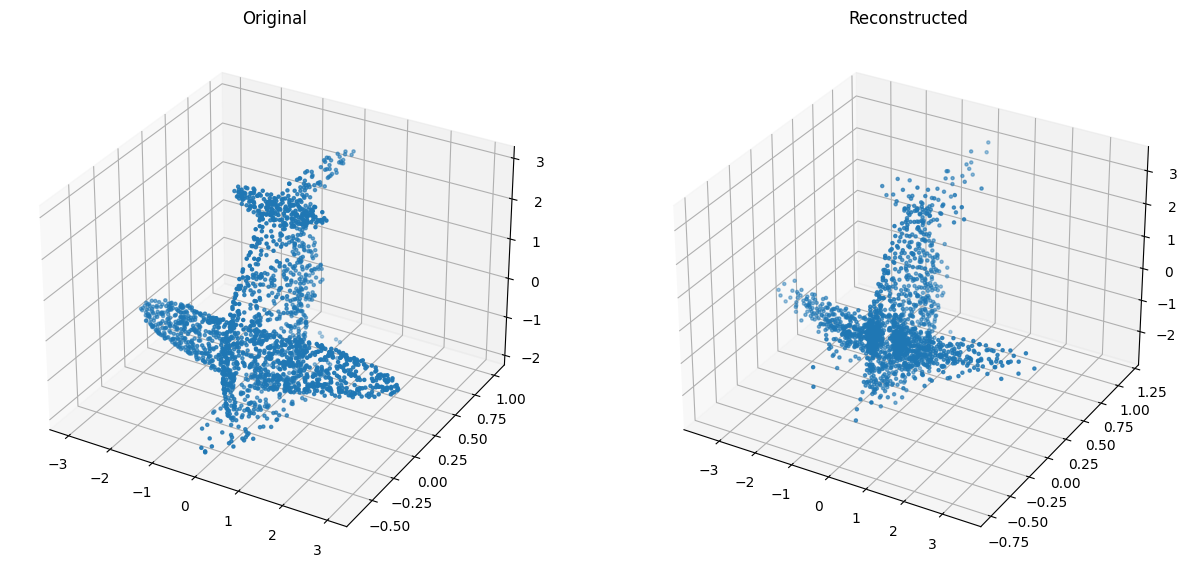

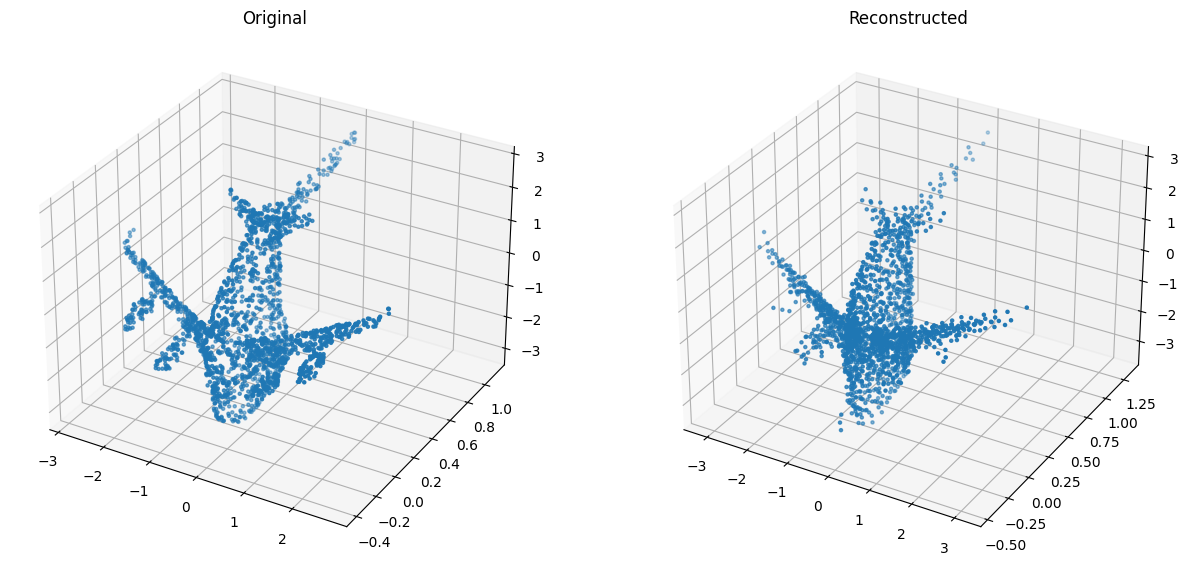

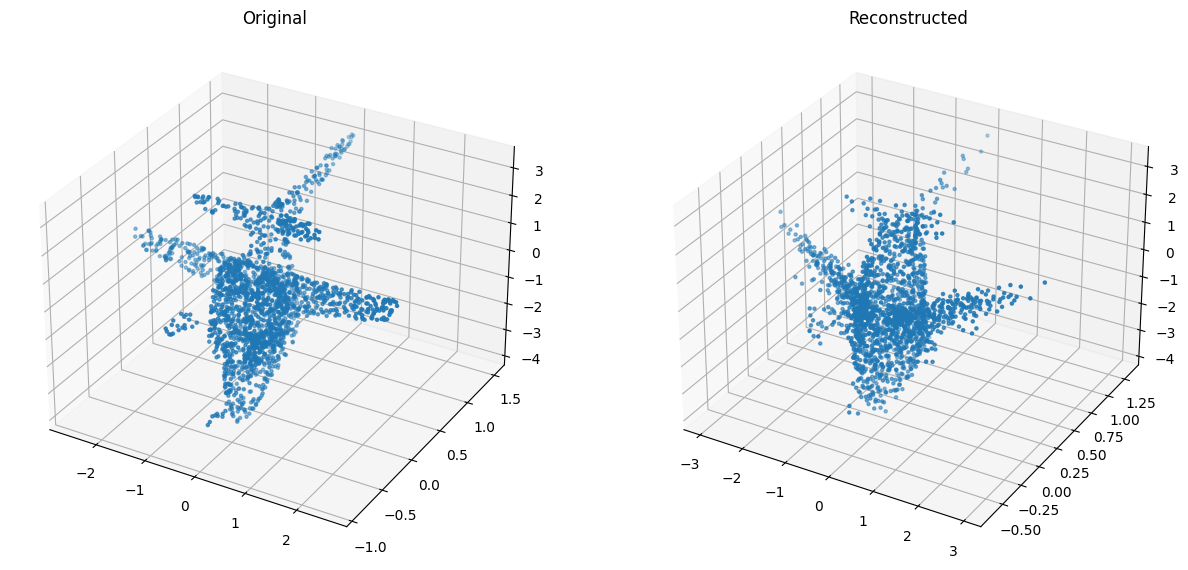

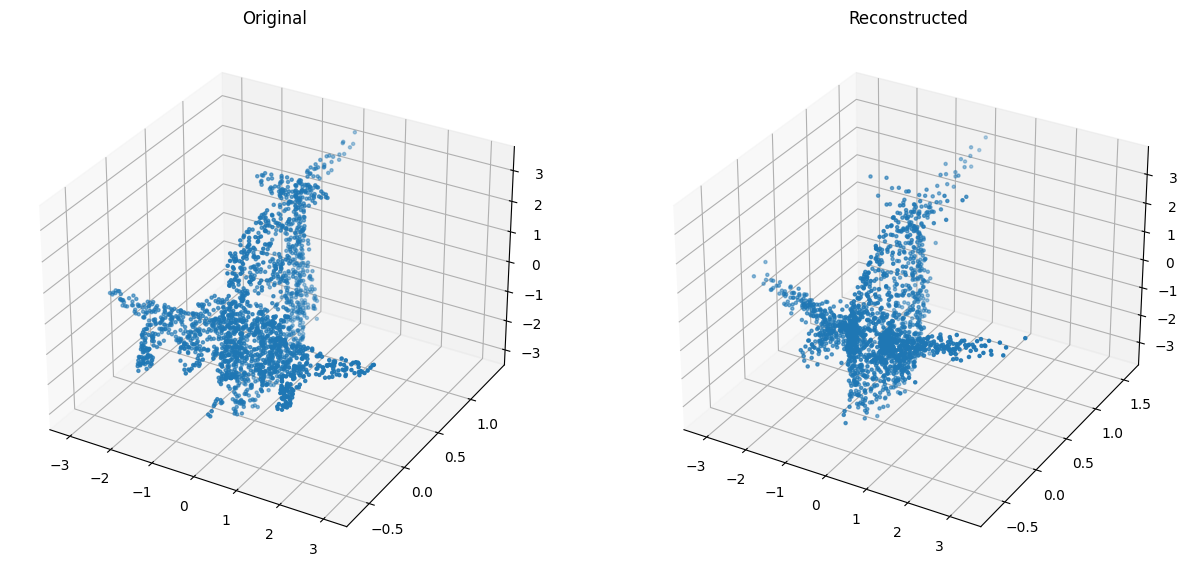

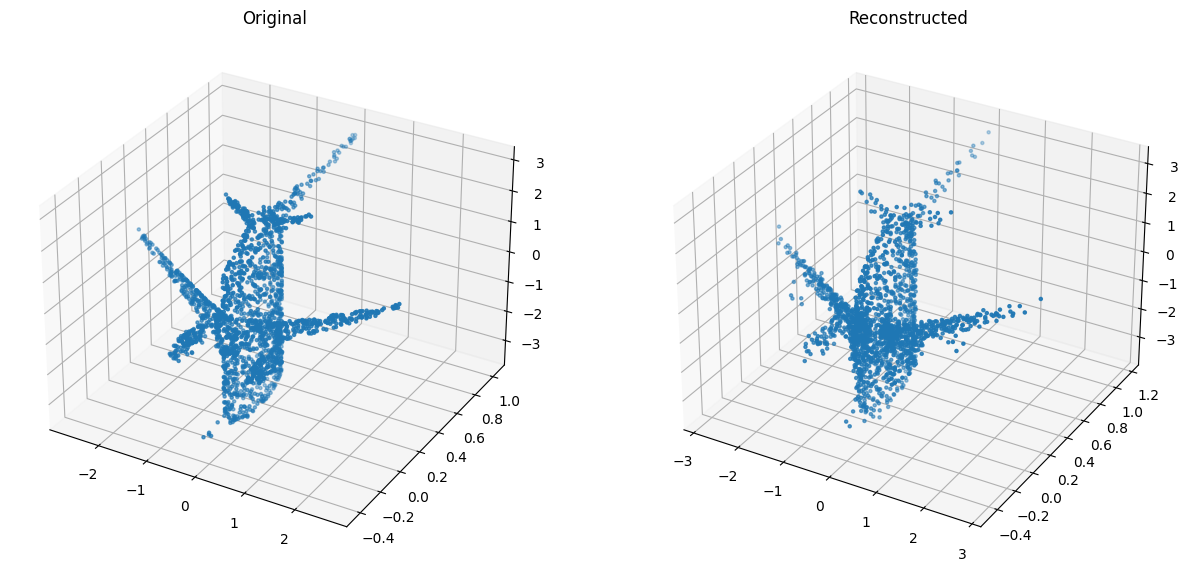

In [16]:
visualize_reconstruction(vae, val_dset) 

Generate a new model

In [ ]:
def sample_from_vae(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    从VAE模型中采样点云。
    """
    model.eval()
    with torch.no_grad():
        # 从标准正态分布中采样潜在向量
        z_sampled = torch.randn(num_samples, latent_dim).to(device)
        generated_point_clouds = model.decoder(z_sampled)
    return generated_point_clouds


In [ ]:
def visualize_generated_point_clouds(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    可视化从VAE中生成的点云。
    """
    generated_point_clouds = sample_from_vae(model, num_samples, latent_dim, device)
    for i in range(num_samples):
        points = generated_point_clouds[i].cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax.set_title(f"Generated Point Cloud {i+1}")

        plt.show()


In [ ]:
visualize_generated_point_clouds(vae)
